In [1]:
# RealWorld-HAR (RealWorld2016, University of Mannheim)
!mkdir -p /content/data/rwhar
%cd /content/data/rwhar

# Attempt HTTPS first (disabling certificate verification due to an SNI mismatch on the host); on failure, fall back to HTTP
!wget -c --no-check-certificate "https://wifo5-14.informatik.uni-mannheim.de/sensor/dataset/realworld2016/realworld2016_dataset.zip" -O realworld2016_dataset.zip || wget -c "http://wifo5-14.informatik.uni-mannheim.de/sensor/dataset/realworld2016/realworld2016_dataset.zip" -O realworld2016_dataset.zip

# Decompress and perform a brief inspection
!unzip -q -o realworld2016_dataset.zip
!echo "=== top-level ==="
!ls -lah
!echo "=== dirs (depth<=2) ==="
!find . -maxdepth 2 -type d | sort | head -n 20

/content/data/rwhar
--2025-12-02 09:37:55--  https://wifo5-14.informatik.uni-mannheim.de/sensor/dataset/realworld2016/realworld2016_dataset.zip
Resolving wifo5-14.informatik.uni-mannheim.de (wifo5-14.informatik.uni-mannheim.de)... 134.155.98.56
Connecting to wifo5-14.informatik.uni-mannheim.de (wifo5-14.informatik.uni-mannheim.de)|134.155.98.56|:443... connected.
	requested host name ‘wifo5-14.informatik.uni-mannheim.de’.
HTTP request sent, awaiting response... 403 Forbidden
2025-12-02 09:37:56 ERROR 403: Forbidden.

--2025-12-02 09:37:56--  http://wifo5-14.informatik.uni-mannheim.de/sensor/dataset/realworld2016/realworld2016_dataset.zip
Resolving wifo5-14.informatik.uni-mannheim.de (wifo5-14.informatik.uni-mannheim.de)... 134.155.98.56
Connecting to wifo5-14.informatik.uni-mannheim.de (wifo5-14.informatik.uni-mannheim.de)|134.155.98.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3721016476 (3.5G) [application/zip]
Saving to: ‘realworld2016_dataset.zip’

re

In [2]:
# ================ Step 0: Project Initialization ================
import os
from datetime import datetime

# Create directory structure
dirs = ['data/raw', 'interim', 'proc', 'features', 'models', 'logs', 'figures', 'configs']
for d in dirs:
    os.makedirs(f'/content/{d}', exist_ok=True)
print("✓ Directory structure created")

# Git Initialization
%cd /content
!git init
!git config user.name "HAR-Project"
!git config user.email "har@project.local"
print("✓ Git repository initialized")

# Persist environment information
!pip freeze > logs/env.txt
print("✓ Environment dependencies saved to logs/env.txt")

# Persist random seed list and hardware information
import json
import subprocess

meta = {
    "timestamp": datetime.now().isoformat(),
    "random_seeds": [42, 123, 456, 789, 2024],  # predefined seeds
    "hardware": {
        "gpu": subprocess.getoutput("nvidia-smi --query-gpu=name --format=csv,noheader"),
        "cpu": subprocess.getoutput("cat /proc/cpuinfo | grep 'model name' | head -1").split(':')[1].strip(),
    }
}

with open('logs/init_meta.json', 'w') as f:
    json.dump(meta, f, indent=2)
print("✓ Metadata saved to logs/init_meta.json")

# Initial commit
!git add .
!git commit -m "init: project structure and environment"
git_hash = subprocess.getoutput("git rev-parse HEAD")
print(f"✓ Git commit hash: {git_hash[:8]}")


# ================ Step 1: Data Acquisition (Compliance) ================
# Move raw data to data/raw/ and retain structure
!mv /content/data/rwhar/* /content/data/raw/ 2>/dev/null || true
!rm -rf /content/data/rwhar
print("✓ Raw data moved to data/raw/")

# Compute checksums
import hashlib

def calc_checksum(filepath):
    h = hashlib.sha256()
    with open(filepath, 'rb') as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

checksums = {}
for root, _, files in os.walk('/content/data/raw'):
    for f in files:
        path = os.path.join(root, f)
        rel_path = os.path.relpath(path, '/content/data/raw')
        checksums[rel_path] = calc_checksum(path)

with open('/content/logs/checksums.txt', 'w') as f:
    f.write(f"# RealWorld2016 dataset checksums (SHA256)\n")
    f.write(f"# Generated at: {datetime.now().isoformat()}\n\n")
    for path, sha in sorted(checksums.items()):
        f.write(f"{sha}  {path}\n")

print(f"✓ Computed checksums for {len(checksums)} files → logs/checksums.txt")

# Record data source
with open('/content/logs/data_source.txt', 'w') as f:
    f.write("RealWorld2016 Human Activity Recognition Dataset\n")
    f.write("=" * 50 + "\n")
    f.write("Source: University of Mannheim\n")
    f.write("URL: https://wifo5-14.informatik.uni-mannheim.de/sensor/dataset/realworld2016/\n")
    f.write("Citation: Sztyler, T., & Stuckenschmidt, H. (2016). On-body localization of wearable devices.\n")
    f.write(f"Downloaded: {datetime.now().isoformat()}\n")

print("✓ Data source recorded to logs/data_source.txt")

# Commit data acquisition records
!git add logs/
!git commit -m "data: add RealWorld2016 checksums and source"
print(f"\n{'='*60}\nProject initialization and data acquisition completed\n{'='*60}")

✓ Directory structure created
/content
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
✓ Git repository initialized
✓ Environment dependencies saved to logs/env.txt
✓ Metadata saved to logs/init_meta.json
[master (root-commit) 98fdb5b] init: project structure and environment
 1837 files changed, 51748 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_co

In [3]:
# ================ Step 2: Sensor/Location Selection (Revised) ================
import pandas as pd
from pathlib import Path
import json
import zipfile

print("Step 2: Sensor/Location Selection")
print("=" * 60)

raw_dir = Path('/content/data/raw')

# Decompress all zip files first
print("Extracting sensor data...")
zip_files = list(raw_dir.rglob('*.zip'))
print(f"Found {len(zip_files)} zip files")

for zip_path in zip_files:
    if 'csv.zip' in zip_path.name:
        extract_dir = zip_path.parent / zip_path.stem
        if not extract_dir.exists():
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)

print("✓ Extraction complete")

# Search for CSV files under acc and gyr directories
print("\nSearching for sensor directories...")
acc_dirs = list(raw_dir.rglob('acc_*_csv'))
gyr_dirs = list(raw_dir.rglob('gyr_*_csv'))

print(f"✓ Found {len(acc_dirs)} ACC directories")
print(f"✓ Found {len(gyr_dirs)} GYR directories")

if acc_dirs:
    print(f"\nExample ACC directory: {acc_dirs[0].relative_to(raw_dir)}")
    sample_files = list(acc_dirs[0].glob('*.csv'))
    print(f"Number of files under {acc_dirs[0].name}: {len(sample_files)}")
    if sample_files:
        print(f"Example file: {sample_files[0].name}")

# Find all files containing "waist"
waist_files = {'acc': [], 'gyr': []}

for acc_dir in acc_dirs:
    for f in acc_dir.glob('*waist*.csv'):
        waist_files['acc'].append(f)

for gyr_dir in gyr_dirs:
    for f in gyr_dir.glob('*waist*.csv'):
        waist_files['gyr'].append(f)

print(f"\n✓ Found Waist-ACC files: {len(waist_files['acc'])}")
print(f"✓ Found Waist-GYR files: {len(waist_files['gyr'])}")

# Display example files
if waist_files['acc']:
    print(f"\nExample ACC file: {waist_files['acc'][0].relative_to(raw_dir)}")
    sample_acc = pd.read_csv(waist_files['acc'][0])
    print(f"Columns: {list(sample_acc.columns)}")
    print(f"Shape: {sample_acc.shape}")
    print(sample_acc.head(3))

if waist_files['gyr']:
    print(f"\nExample GYR file: {waist_files['gyr'][0].relative_to(raw_dir)}")
    sample_gyr = pd.read_csv(waist_files['gyr'][0])
    print(f"Columns: {list(sample_gyr.columns)}")
    print(f"Shape: {sample_gyr.shape}")
    print(sample_gyr.head(3))

# Collect metadata
waist_metadata = []
for sensor_type in ['acc', 'gyr']:
    for filepath in waist_files[sensor_type]:
        parts = filepath.parts
        subject = [p for p in parts if p.startswith('proband')][0]
        activity = filepath.parent.name.split('_')[1]

        df = pd.read_csv(filepath)
        waist_metadata.append({
            'subject': subject,
            'activity': activity,
            'sensor': sensor_type,
            'original_path': str(filepath.relative_to(raw_dir)),
            'shape': list(df.shape),
            'columns': list(df.columns)
        })

# Persist selection report
with open('/content/logs/sensor_selection.json', 'w') as f:
    json.dump({
        'selection': {
            'position': 'waist',
            'sensors': ['acc', 'gyr'],
            'channels': 6,
            'rationale': 'Single position to avoid domain shift; ACC+GYRO is the standard configuration for HAR'
        },
        'files_found': {
            'acc': len(waist_files['acc']),
            'gyr': len(waist_files['gyr'])
        },
        'metadata': waist_metadata[:10]
    }, f, indent=2)

print(f"\n✓ Selection report saved: logs/sensor_selection.json")

!git add logs/sensor_selection.json
!git commit -m "data: select waist position with acc+gyr sensors"


# ================ Step 3: Column Alignment and Naming ================
print("\n\nStep 3: Column Alignment and Naming")
print("=" * 60)

# Analyze column names
acc_cols = set()
gyr_cols = set()

for filepath in waist_files['acc'][:3]:
    df = pd.read_csv(filepath)
    acc_cols.update(df.columns)

for filepath in waist_files['gyr'][:3]:
    df = pd.read_csv(filepath)
    gyr_cols.update(df.columns)

print(f"ACC column names: {sorted(acc_cols)}")
print(f"GYR column names: {sorted(gyr_cols)}")

# Define standard mapping
standard_mapping = {
    'acc': {
        'attr_x': 'acc_x',
        'attr_y': 'acc_y',
        'attr_z': 'acc_z',
        'attr_time': 'timestamp'
    },
    'gyr': {
        'attr_x': 'gyro_x',
        'attr_y': 'gyro_y',
        'attr_z': 'gyro_z',
        'attr_time': 'timestamp'
    }
}

cols_config = {
    'standard_columns': ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'],
    'units': {
        'acc_x': 'm/s²', 'acc_y': 'm/s²', 'acc_z': 'm/s²',
        'gyro_x': 'rad/s', 'gyro_y': 'rad/s', 'gyro_z': 'rad/s'
    },
    'mapping': standard_mapping,
    'timestamp_col': 'timestamp'
}

with open('/content/configs/cols.json', 'w') as f:
    json.dump(cols_config, f, indent=2)

print("\n✓ Column mapping configuration saved: configs/cols.json")

# Generate schema report
report = [
    "# RealWorld2016 Data Schema Report\n\n",
    f"Generated at: {datetime.now().isoformat()}\n\n",
    "## Standard column definitions\n\n",
    "| Column | Unit | Description |\n|------|------|------|\n"
]

for col in cols_config['standard_columns']:
    unit = cols_config['units'][col]
    sensor = 'Accelerometer' if 'acc' in col else 'Gyroscope'
    axis = col.split('_')[1].upper()
    report.append(f"| {col} | {unit} | {sensor} {axis}-axis |\n")

report.append("\n## Original column mapping\n\n### Accelerometer\n")
for orig, std in standard_mapping['acc'].items():
    report.append(f"- `{orig}` → `{std}`\n")

report.append("\n### Gyroscope\n")
for orig, std in standard_mapping['gyr'].items():
    report.append(f"- `{orig}` → `{std}`\n")

# Missing-value statistics
report.append("\n## Data quality checks\n\n")
for sensor in ['acc', 'gyr']:
    report.append(f"### {sensor.upper()} Missing values (sample of 5 files)\n\n")
    has_missing = False
    for fp in waist_files[sensor][:5]:
        df = pd.read_csv(fp)
        missing = df.isnull().sum()
        if missing.sum() > 0:
            report.append(f"- {fp.name}: {missing[missing > 0].to_dict()}\n")
            has_missing = True
    if not has_missing:
        report.append("- No missing values ✓\n")
    report.append("\n")

with open('/content/logs/schema_report.md', 'w') as f:
    f.writelines(report)

print("✓ Schema report saved: logs/schema_report.md")
print("\n" + "".join(report))

!git add configs/cols.json logs/schema_report.md
!git commit -m "data: standardize column names and units"

print(f"\n{'='*60}")
print("Steps 2–3 completed")
print(f"{'='*60}")

Step 2: Sensor/Location Selection
Extracting sensor data...
Found 1441 zip files
✓ Extraction complete

Searching for sensor directories...
✓ Found 120 ACC directories
✓ Found 120 GYR directories

Example ACC directory: proband14/data/acc_walking_csv
Number of files under acc_walking_csv: 7
Example file: acc_walking_shin.csv

✓ Found Waist-ACC files: 114
✓ Found Waist-GYR files: 114

Example ACC file: proband14/data/acc_walking_csv/acc_walking_waist.csv
Columns: ['id', 'attr_time', 'attr_x', 'attr_y', 'attr_z']
Shape: (33578, 5)
   id      attr_time    attr_x    attr_y    attr_z
0   1  1437139316413  9.765948 -0.834379  1.520917
1   2  1437139316434  9.859921 -0.903213  1.561020
2   3  1437139316456  9.850345 -0.930746  1.546654

Example GYR file: proband14/data/gyr_standing_csv/Gyroscope_standing_waist.csv
Columns: ['id', 'attr_time', 'attr_x', 'attr_y', 'attr_z']
Shape: (31188, 5)
   id      attr_time    attr_x    attr_y    attr_z
0   1  1437154490049  0.004581  0.008552 -0.033903
1 

In [4]:
# ================ Step 4: Timeline Normalization (Final) ================
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from pathlib import Path
import json
import zipfile

print("\n\nStep 4: Timeline Normalization")
print("=" * 60)

raw_dir = Path('/content/data/raw')

# Decompression
print("Extracting waist data...")
for proband_dir in raw_dir.glob('proband*'):
    data_dir = proband_dir / 'data'
    if data_dir.exists():
        for zip_file in data_dir.glob('*_csv.zip'):
            if zip_file.stem.startswith(('acc_', 'gyr_')):
                extract_dir = zip_file.parent / zip_file.stem
                if not extract_dir.exists():
                    with zipfile.ZipFile(zip_file, 'r') as zf:
                        if any('waist' in f.lower() for f in zf.namelist()):
                            zf.extractall(extract_dir)

# Scan
waist_files = {'acc': [], 'gyr': []}
for csv_file in raw_dir.rglob('*.csv'):
    if 'waist' in csv_file.name.lower():
        if csv_file.parent.name.startswith('acc_'):
            waist_files['acc'].append(csv_file)
        elif csv_file.parent.name.startswith('gyr_'):
            waist_files['gyr'].append(csv_file)

print(f"✓ ACC: {len(waist_files['acc'])}, GYR: {len(waist_files['gyr'])}")

# Improved pairing: directory mapping + same-name preference
def find_gyr_for_acc(acc_path):
    gyr_dir = acc_path.parent.parent / acc_path.parent.name.replace('acc_', 'gyr_')
    if not gyr_dir.exists():
        return None
    cand = gyr_dir / acc_path.name.replace('acc_', 'gyr_')
    if cand.exists():
        return cand
    cands = sorted(gyr_dir.glob('*waist*.csv'))
    return cands[0] if cands else None

file_pairs = []
for acc_path in waist_files['acc']:
    gyr_path = find_gyr_for_acc(acc_path)
    if not gyr_path:
        continue
    proband = next(p for p in acc_path.parts if p.startswith('proband'))
    activity = acc_path.parent.name.split('_')[1]
    file_pairs.append((acc_path, gyr_path, proband, activity))

print(f"✓ File pairs: {len(file_pairs)}")

with open('/content/configs/cols.json', 'r') as f:
    cols_config = json.load(f)

TARGET_FS = 50
MAX_GAP_MS = 200
MIN_DURATION_S = 1.0
interim_dir = Path('/content/interim')
interim_dir.mkdir(exist_ok=True)

def detect_time_unit(df, col='timestamp'):
    ts = df[col].sort_values().iloc[:200].values
    diffs = np.diff(ts)
    diffs = diffs[diffs > 0]
    if len(diffs) == 0:
        return None, None
    dt = np.median(diffs)

    if 0.01 < dt < 5:
        return df[col] * 1e9, 's'
    elif 10 < dt < 100:
        return df[col] * 1e6, 'ms'
    elif 10000 < dt < 100000:
        return df[col] * 1e3, 'us'
    elif 1e7 < dt < 1e8:
        return df[col], 'ns'
    else:
        return None, None

all_stats = []
skipped = []

for idx, (acc_path, gyr_path, proband, activity) in enumerate(file_pairs):
    print(f"\n[{idx+1}/{len(file_pairs)}] {proband}/{activity}")

    acc_df = pd.read_csv(acc_path).rename(columns=cols_config['mapping']['acc'])
    gyr_df = pd.read_csv(gyr_path).rename(columns=cols_config['mapping']['gyr'])

    acc_ts_ns, acc_unit = detect_time_unit(acc_df)
    gyr_ts_ns, gyr_unit = detect_time_unit(gyr_df)

    if acc_ts_ns is None or gyr_ts_ns is None:
        print(f"  ⚠️ Skipped: unable to determine timestamp unit")
        skipped.append(f"{proband}_{activity}")
        continue

    acc_df['timestamp_ns'] = acc_ts_ns
    gyr_df['timestamp_ns'] = gyr_ts_ns
    acc_df = acc_df[['timestamp_ns', 'acc_x', 'acc_y', 'acc_z']].sort_values('timestamp_ns').drop_duplicates('timestamp_ns')
    gyr_df = gyr_df[['timestamp_ns', 'gyro_x', 'gyro_y', 'gyro_z']].sort_values('timestamp_ns').drop_duplicates('timestamp_ns')

    df = None
    merge_mode = 'absolute'
    merge_tol = None
    offset_ns = 0

    # Adaptive tolerance
    for tol_ms in [10, 30, 50, 100]:
        tol_ns = int(tol_ms * 1e6)
        df_try = pd.merge_asof(acc_df, gyr_df, on='timestamp_ns', direction='nearest', tolerance=tol_ns).dropna()
        if len(df_try) >= TARGET_FS:
            df = df_try
            merge_tol = tol_ms
            break

    # Fallback 1: relative time (relaxed thresholds)
    if df is None:
        for tol_ms in [10, 30, 50]:
            acc_tmp = acc_df.copy()
            gyr_tmp = gyr_df.copy()
            acc_tmp['t_rel'] = acc_tmp['timestamp_ns'] - acc_tmp['timestamp_ns'].iloc[0]
            gyr_tmp['t_rel'] = gyr_tmp['timestamp_ns'] - gyr_tmp['timestamp_ns'].iloc[0]

            df_try = pd.merge_asof(acc_tmp.sort_values('t_rel'), gyr_tmp.sort_values('t_rel'),
                                   on='t_rel', direction='nearest', tolerance=int(tol_ms*1e6)).dropna()

            if len(df_try) > 1:
                p99 = (df_try['t_rel'].diff() / 1e6).quantile(0.99)
                match_rate = len(df_try) / max(1, min(len(acc_df), len(gyr_df)))

                if len(df_try) >= TARGET_FS and p99 <= 40 and match_rate >= 0.5:
                    df = df_try.rename(columns={'t_rel': 'timestamp_ns'})
                    merge_mode = 'relative'
                    merge_tol = tol_ms
                    break

    # Fallback 2: offset search (broaden range and thresholds)
    if df is None:
        best_df, best_matches, best_offset = None, -1, 0
        for offset_ms in range(-3000, 3001, 50):
            gyr_shift = gyr_df.copy()
            gyr_shift['timestamp_ns'] = gyr_shift['timestamp_ns'] + int(offset_ms * 1e6)
            df_try = pd.merge_asof(acc_df, gyr_shift, on='timestamp_ns',
                                   direction='nearest', tolerance=int(30*1e6)).dropna()
            if len(df_try) > best_matches:
                best_df, best_matches, best_offset = df_try, len(df_try), offset_ms

        if best_matches >= TARGET_FS and best_df is not None and len(best_df) > 1:
            p99 = (best_df['timestamp_ns'].diff() / 1e6).quantile(0.99)
            match_rate = best_matches / max(1, min(len(acc_df), len(gyr_df)))

            if p99 <= 40 and match_rate >= 0.5:
                df = best_df
                merge_mode = 'offset_search'
                merge_tol = 30
                offset_ns = int(best_offset * 1e6)

    # Fallback 3: intersection window resampling
    if df is None:
        t0 = max(acc_df['timestamp_ns'].iloc[0], gyr_df['timestamp_ns'].iloc[0])
        t1 = min(acc_df['timestamp_ns'].iloc[-1], gyr_df['timestamp_ns'].iloc[-1])

        if t1 - t0 >= 1e9:
            STEP_NS = int(1e9 / TARGET_FS)
            t_grid = np.arange(t0, t1, STEP_NS, dtype=np.int64)

            acc_interp = interpolate.interp1d(acc_df['timestamp_ns'].values,
                                              acc_df[['acc_x', 'acc_y', 'acc_z']].values,
                                              axis=0, kind='linear', bounds_error=True)
            gyr_interp = interpolate.interp1d(gyr_df['timestamp_ns'].values,
                                              gyr_df[['gyro_x', 'gyro_y', 'gyro_z']].values,
                                              axis=0, kind='linear', bounds_error=True)

            acc_vals = acc_interp(t_grid)
            gyr_vals = gyr_interp(t_grid)

            df = pd.DataFrame({
                'timestamp': t_grid,
                'segment_id': 0,
                'proband': proband,
                'activity': activity,
                'acc_x': acc_vals[:, 0], 'acc_y': acc_vals[:, 1], 'acc_z': acc_vals[:, 2],
                'gyro_x': gyr_vals[:, 0], 'gyro_y': gyr_vals[:, 1], 'gyro_z': gyr_vals[:, 2]
            })

            out_name = f"{proband}_{activity}_waist.csv"
            df.to_csv(interim_dir / out_name, index=False)

            all_stats.append({
                'file': out_name,
                'proband': proband,
                'activity': activity,
                'acc_unit': acc_unit,
                'gyr_unit': gyr_unit,
                'merge_mode': 'intersection',
                'segments': 1,
                'samples': len(df)
            })

            print(f"  {acc_unit}/{gyr_unit}, intersection, 1 segment, {len(df)} samples")
            continue

    if df is None or len(df) < TARGET_FS:
        print(f"  ⚠️ Skipped: merge failed")
        skipped.append(f"{proband}_{activity}")
        continue

    df = df.reset_index(drop=True)
    df['dt_ms'] = df['timestamp_ns'].diff() / 1e6

    # Segmentation
    gaps = df['dt_ms'].values
    large_gap_idx = np.where(gaps > MAX_GAP_MS)[0]
    split_points = [0] + large_gap_idx.tolist() + [len(df)]

    segments = []
    for i in range(len(split_points) - 1):
        seg = df.iloc[split_points[i]:split_points[i + 1]].copy()
        if len(seg) > 1:
            duration_s = (seg['timestamp_ns'].iloc[-1] - seg['timestamp_ns'].iloc[0]) / 1e9
            if duration_s >= MIN_DURATION_S:
                segments.append(seg)

    if len(segments) == 0:
        print(f"  ⚠️ Skipped: no valid segments")
        skipped.append(f"{proband}_{activity}")
        continue

    # Resampling
    STEP_NS = int(1e9 / TARGET_FS)
    all_resampled = []
    for seg_id, seg in enumerate(segments):
        t_start = seg['timestamp_ns'].iloc[0]
        t_end = seg['timestamp_ns'].iloc[-1]
        t_grid = np.arange(t_start, t_end + 1, STEP_NS, dtype=np.int64)

        df_seg = pd.DataFrame({
            'timestamp': t_grid,
            'segment_id': seg_id,
            'proband': proband,
            'activity': activity
        })
        for col in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
            f = interpolate.interp1d(seg['timestamp_ns'], seg[col], kind='linear', bounds_error=True)
            df_seg[col] = f(t_grid)

        all_resampled.append(df_seg)

    df_final = pd.concat(all_resampled, ignore_index=True)

    out_name = f"{proband}_{activity}_waist.csv"
    df_final.to_csv(interim_dir / out_name, index=False)

    stat = {
        'file': out_name,
        'proband': proband,
        'activity': activity,
        'acc_unit': acc_unit,
        'gyr_unit': gyr_unit,
        'merge_mode': merge_mode,
        'merge_tolerance_ms': merge_tol,
        'segments': len(segments),
        'samples': len(df_final)
    }
    if merge_mode == 'offset_search':
        stat['offset_ns'] = offset_ns

    all_stats.append(stat)

    mode_str = f"{merge_mode}" + (f"(Δ={offset_ns/1e6:.0f}ms)" if merge_mode=='offset_search' else '')
    print(f"  {acc_unit}/{gyr_unit}, {mode_str}, {len(segments)} segments, {len(df_final)} samples")

print(f"\n✓ Completed {len(all_stats)} files")
if skipped:
    print(f"⚠️ Skipped {len(skipped)}: {skipped}")

# Plotting
if all_stats:
    first_file = all_stats[0]
    first_pair = [(p[0], p[1], p[2], p[3]) for p in file_pairs if p[2] == first_file['proband'] and p[3] == first_file['activity']][0]

    acc_df = pd.read_csv(first_pair[0]).rename(columns=cols_config['mapping']['acc'])
    gyr_df = pd.read_csv(first_pair[1]).rename(columns=cols_config['mapping']['gyr'])
    acc_ts_ns, _ = detect_time_unit(acc_df)
    gyr_ts_ns, _ = detect_time_unit(gyr_df)
    acc_df['timestamp_ns'] = acc_ts_ns
    gyr_df['timestamp_ns'] = gyr_ts_ns
    acc_df = acc_df[['timestamp_ns', 'acc_x', 'acc_y', 'acc_z']].sort_values('timestamp_ns').drop_duplicates('timestamp_ns')
    gyr_df = gyr_df[['timestamp_ns', 'gyro_x', 'gyro_y', 'gyro_z']].sort_values('timestamp_ns').drop_duplicates('timestamp_ns')

    df = pd.merge_asof(acc_df, gyr_df, on='timestamp_ns', direction='nearest', tolerance=int(100*1e6)).dropna()
    intervals = df['timestamp_ns'].diff() / 1e6

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(intervals[intervals < 100], bins=100, edgecolor='black', linewidth=0.5)
    ax.axvline(20, color='red', linestyle='--', label='Ideal (50Hz=20ms)')
    ax.axvline(MAX_GAP_MS, color='orange', linestyle='--', label=f'Threshold ({MAX_GAP_MS}ms)')
    ax.set_xlabel('Sampling Interval (ms)')
    ax.set_ylabel('Count')
    ax.set_title(f'Sampling Interval Distribution - {first_pair[2]}/{first_pair[3]}')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('/content/figures/step4_interval_hist.png', dpi=150)
    plt.close()

with open('/content/logs/step4_summary.json', 'w') as f:
    json.dump({'files': all_stats, 'skipped': skipped}, f, indent=2)

!git add figures/ logs/step4_*.json interim/
!git commit -m "preproc: final time normalization with all fallbacks"

print(f"\n{'='*60}\nStep 4 completed\n{'='*60}")



Step 4: Timeline Normalization
Extracting waist data...
✓ ACC: 114, GYR: 114
✓ File pairs: 114

[1/114] proband14/walking
  ms/ms, absolute, 50 segments, 32007 samples

[2/114] proband14/jumping
  ms/ms, absolute, 5 segments, 4642 samples

[3/114] proband14/sitting
  ms/ms, absolute, 31 segments, 30562 samples

[4/114] proband14/standing
  ms/ms, absolute, 34 segments, 30114 samples

[5/114] proband14/lying
  ms/ms, absolute, 27 segments, 30563 samples

[6/114] proband14/running
  ms/ms, absolute, 33 segments, 29786 samples

[7/114] proband2/walking
  ms/ms, absolute, 38 segments, 28946 samples

[8/114] proband2/jumping
  ms/ms, absolute, 3 segments, 4512 samples

[9/114] proband2/sitting
  ms/ms, absolute, 17 segments, 29887 samples

[10/114] proband2/climbingdown
  ms/ms, absolute, 24 segments, 23939 samples

[11/114] proband2/standing
  ms/ms, absolute, 49 segments, 28717 samples

[12/114] proband2/lying
  ms/ms, absolute, 28 segments, 30002 samples

[13/114] proband2/running
  ms

In [5]:
# ================ Step 5: Gravity Removal / Detrending (Batch Processing) ================
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from pathlib import Path
import json

print("\n\nStep 5: Gravity Removal / Detrending")
print("=" * 60)

interim_dir = Path('/content/interim')
proc_dir = Path('/content/proc')
proc_dir.mkdir(exist_ok=True)

TARGET_FS = 50
CUTOFF_HZ = 0.3

def highpass_filter(data, cutoff, fs, order=3):
    """Third-order Butterworth high-pass filter"""
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

# Process all files
interim_files = sorted(interim_dir.glob('*.csv'))
print(f"Found {len(interim_files)} files")

all_static_means = []

for idx, filepath in enumerate(interim_files):
    print(f"\n[{idx+1}/{len(interim_files)}] {filepath.name}")

    df = pd.read_csv(filepath)
    print(f"  Original: {df.shape}, {df['segment_id'].nunique()} segments")

    processed_segments = []

    # Filter per segment
    for seg_id, seg_df in df.groupby('segment_id'):
        seg_df = seg_df.copy()

        # Accelerometer high-pass filtering
        for axis in ['x', 'y', 'z']:
            col = f'acc_{axis}'
            seg_df[col] = highpass_filter(seg_df[col].values, CUTOFF_HZ, TARGET_FS, order=3)

        # Gyroscope mean removal
        for axis in ['x', 'y', 'z']:
            col = f'gyro_{axis}'
            seg_df[col] = seg_df[col] - seg_df[col].mean()

        processed_segments.append(seg_df)

    df_filtered = pd.concat(processed_segments, ignore_index=True)

    # Validate static segment (from the longest segment)
    longest_seg = df_filtered.groupby('segment_id').size().idxmax()
    seg_for_verify = df_filtered[df_filtered['segment_id'] == longest_seg].reset_index(drop=True)

    window_size = TARGET_FS * 2
    acc_mag = np.sqrt(seg_for_verify['acc_x']**2 + seg_for_verify['acc_y']**2 + seg_for_verify['acc_z']**2)
    static_idx = acc_mag.rolling(window_size).std().idxmin()
    static_seg = seg_for_verify.iloc[static_idx:static_idx+window_size]

    static_means = {f'acc_{ax}': static_seg[f'acc_{ax}'].mean() for ax in ['x', 'y', 'z']}
    all_static_means.append({'file': filepath.name, **static_means})

    # Save
    df_filtered.to_csv(proc_dir / filepath.name, index=False)
    print(f"  ✓ {len(df_filtered)} samples → proc/{filepath.name}")

print(f"\n✓ Completed {len(interim_files)} files")

# Plot verification figure for the first file
if interim_files:
    first_file = interim_files[0]
    df = pd.read_csv(proc_dir / first_file.name)
    longest_seg = df.groupby('segment_id').size().idxmax()
    seg = df[df['segment_id'] == longest_seg].reset_index(drop=True)

    window_size = TARGET_FS * 2
    acc_mag = np.sqrt(seg['acc_x']**2 + seg['acc_y']**2 + seg['acc_z']**2)
    static_idx = acc_mag.rolling(window_size).std().idxmin()
    static_seg = seg.iloc[static_idx:static_idx+window_size]

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    time_sec = np.arange(len(seg)) / TARGET_FS

    for i, axis in enumerate(['x', 'y', 'z']):
        ax = axes[i]
        col = f'acc_{axis}'
        ax.plot(time_sec, seg[col], linewidth=0.5, alpha=0.7)
        ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)

        static_t = static_idx / TARGET_FS
        static_mean = static_seg[col].mean()
        ax.axvspan(static_t, static_t + 2, color='green', alpha=0.2,
                   label=f'Static (mean={static_mean:.4f})')

        ax.set_ylabel(f'ACC {axis.upper()} (m/s²)')
        ax.grid(alpha=0.3)
        ax.legend(loc='upper right')

    axes[-1].set_xlabel('Time (s)')
    axes[0].set_title(f'Detrended Signal - {first_file.name} (segment {longest_seg})')
    plt.tight_layout()
    plt.savefig('/content/figures/step5_detrend_verify.png', dpi=150)
    plt.close()
    print(f"\n✓ Verification figure: figures/step5_detrend_verify.png")

# Save parameters
filter_params = {
    'acc_highpass': {'cutoff_hz': CUTOFF_HZ, 'order': 3, 'filter_type': 'Butterworth'},
    'gyro_detrend': 'mean_removal',
    'sampling_rate': TARGET_FS,
    'filtering_method': 'per_segment',
    'files_processed': len(interim_files),
    'static_means_samples': all_static_means[:5]
}

with open('/content/logs/step5_filter_params.json', 'w') as f:
    json.dump(filter_params, f, indent=2)

get_ipython().system('git add figures/step5_detrend_verify.png logs/step5_filter_params.json proc/')
get_ipython().system('git commit -m "preproc: batch filtering for all files"')

print(f"\n{'='*60}\nStep 5 completed\n{'='*60}")



Step 5: Gravity Removal / Detrending
Found 112 files

[1/112] proband10_climbingdown_waist.csv
  Original: (21216, 10), 20 segments
  ✓ 21216 samples → proc/proband10_climbingdown_waist.csv

[2/112] proband10_climbingup_waist.csv
  Original: (22201, 10), 21 segments
  ✓ 22201 samples → proc/proband10_climbingup_waist.csv

[3/112] proband10_jumping_waist.csv
  Original: (5193, 10), 1 segments
  ✓ 5193 samples → proc/proband10_jumping_waist.csv

[4/112] proband10_lying_waist.csv
  Original: (31164, 10), 22 segments
  ✓ 31164 samples → proc/proband10_lying_waist.csv

[5/112] proband10_running_waist.csv
  Original: (31071, 10), 31 segments
  ✓ 31071 samples → proc/proband10_running_waist.csv

[6/112] proband10_sitting_waist.csv
  Original: (30836, 10), 32 segments
  ✓ 30836 samples → proc/proband10_sitting_waist.csv

[7/112] proband10_standing_waist.csv
  Original: (31946, 10), 27 segments
  ✓ 31946 samples → proc/proband10_standing_waist.csv

[8/112] proband10_walking_waist.csv
  Origin

In [6]:
# ================ Step 6: Class Mapping ================
import pandas as pd
from pathlib import Path
import json

print("\n\nStep 6: Class Mapping")
print("=" * 60)

proc_dir = Path('/content/proc')
TARGET_FS = 50

# Fixed order of 8 standard classes (consistent across folds)
STANDARD_CLASSES = ['walking', 'running', 'sitting', 'standing',
                    'lying', 'stairs_up', 'stairs_down', 'jumping']

# Mapping from original activity names
activity_mapping = {
    'climbingdown': 'stairs_down',
    'climbingup': 'stairs_up',
    'jumping': 'jumping',
    'lying': 'lying',
    'running': 'running',
    'sitting': 'sitting',
    'standing': 'standing',
    'walking': 'walking'
}

# Sliding-window parameters (aligned with subsequent feature extraction)
WINDOW_SEC = 3
OVERLAP = 0.5
WINDOW_SAMPLES = int(TARGET_FS * WINDOW_SEC)
STRIDE_SAMPLES = int(WINDOW_SAMPLES * (1 - OVERLAP))
MIN_WINDOWS_THRESHOLD = 50

print(f"Sliding window: {WINDOW_SEC}s ({WINDOW_SAMPLES} samples), overlap {OVERLAP*100:.0f}%, stride {STRIDE_SAMPLES}")

# Scan files and count windows per segment
proc_files = sorted(proc_dir.glob('*.csv'))
print(f"\nFound {len(proc_files)} files")

activity_stats = {}
proband_class_matrix = {}

for filepath in proc_files:
    df = pd.read_csv(filepath)

    # Prefer reading from columns
    activity = df['activity'].iloc[0] if 'activity' in df.columns else filepath.stem.split('_')[1]
    proband = df['proband'].iloc[0] if 'proband' in df.columns else filepath.stem.split('_')[0]

    # Count windows per segment (without crossing segments)
    n_windows = 0
    for _, seg in df.groupby('segment_id'):
        seg_len = len(seg)
        if seg_len >= WINDOW_SAMPLES:
            n_windows += 1 + (seg_len - WINDOW_SAMPLES) // STRIDE_SAMPLES

    # Accumulate statistics for original activities
    if activity not in activity_stats:
        activity_stats[activity] = {'samples': 0, 'windows': 0, 'files': 0}
    activity_stats[activity]['samples'] += len(df)
    activity_stats[activity]['windows'] += n_windows
    activity_stats[activity]['files'] += 1

    # Build proband × class matrix
    if activity in activity_mapping:
        std_act = activity_mapping[activity]
        if proband not in proband_class_matrix:
            proband_class_matrix[proband] = {c: 0 for c in STANDARD_CLASSES}
        proband_class_matrix[proband][std_act] += n_windows

print("\nOriginal activity statistics:")
for act in sorted(activity_stats.keys()):
    stats = activity_stats[act]
    print(f"  {act:15s}: {stats['files']:2d} files, {stats['samples']:6d} samples, {stats['windows']:4d} windows")

# Map to the 8 standard classes
mapped_stats = {c: {'windows': 0, 'samples': 0, 'files': 0, 'original_names': []}
                for c in STANDARD_CLASSES}
tail_classes_original = []

for orig_act, stats in activity_stats.items():
    if orig_act in activity_mapping:
        std_act = activity_mapping[orig_act]
        mapped_stats[std_act]['windows'] += stats['windows']
        mapped_stats[std_act]['samples'] += stats['samples']
        mapped_stats[std_act]['files'] += stats['files']
        if orig_act not in mapped_stats[std_act]['original_names']:
            mapped_stats[std_act]['original_names'].append(orig_act)

        if stats['windows'] < MIN_WINDOWS_THRESHOLD:
            tail_classes_original.append({'original': orig_act, 'mapped': std_act, 'windows': stats['windows']})

# Tail-class determination at the standard-class level
tail_standard_classes = [c for c in STANDARD_CLASSES if mapped_stats[c]['windows'] < MIN_WINDOWS_THRESHOLD]
included_flags = {c: (mapped_stats[c]['windows'] >= MIN_WINDOWS_THRESHOLD) for c in STANDARD_CLASSES}

print("\nStatistics for the 8 standard classes:")
for std_act in STANDARD_CLASSES:
    stats = mapped_stats[std_act]
    status = " [TAIL]" if std_act in tail_standard_classes else ""
    status = " [MISSING]" if stats['windows'] == 0 else status
    print(f"  {std_act:15s}: {stats['files']:2d} files, {stats['samples']:6d} samples, {stats['windows']:4d} windows{status}")

# Fixed encoding
label_to_id = {c: i for i, c in enumerate(STANDARD_CLASSES)}
id_to_label = {i: c for c, i in label_to_id.items()}

print("\nLabel encoding:")
for i, c in id_to_label.items():
    print(f"  {i}: {c}")

# Proband coverage matrix
print("\nProband × Class coverage (number of windows):")
print(f"{'Proband':<12}", end='')
for c in STANDARD_CLASSES:
    print(f"{c[:4]:>6}", end='')
print()
for p in sorted(proband_class_matrix.keys()):
    print(f"{p:<12}", end='')
    for c in STANDARD_CLASSES:
        cnt = proband_class_matrix[p][c]
        print(f"{cnt:>6}", end='')
    print()

# Save configuration
classes_config = {
    'standard_classes': STANDARD_CLASSES,
    'num_classes': len(STANDARD_CLASSES),
    'label_to_id': label_to_id,
    'id_to_label': id_to_label,
    'activity_mapping': activity_mapping,
    'window_config': {
        'window_size_sec': WINDOW_SEC,
        'window_samples': WINDOW_SAMPLES,
        'overlap': OVERLAP,
        'stride_samples': STRIDE_SAMPLES,
        'sampling_rate_hz': TARGET_FS
    },
    'statistics': {
        'per_class': {c: {**mapped_stats[c], 'id': label_to_id[c]} for c in STANDARD_CLASSES},
        'tail_classes_original': tail_classes_original,
        'tail_standard_classes': tail_standard_classes,
        'included_flags': included_flags,
        'min_windows_threshold': MIN_WINDOWS_THRESHOLD,
        'proband_coverage': proband_class_matrix
    }
}

with open('/content/configs/classes.json', 'w') as f:
    json.dump(classes_config, f, indent=2)

print(f"\n✓ Class configuration saved: configs/classes.json")

if tail_standard_classes:
    print(f"\n⚠️ Tail classes at the standard level (windows < {MIN_WINDOWS_THRESHOLD}): {tail_standard_classes}")

included_classes = [c for c in STANDARD_CLASSES if included_flags[c]]
print(f"✓ Classes included for training ({len(included_classes)}/{len(STANDARD_CLASSES)}): {included_classes}")

get_ipython().system('git add configs/classes.json')
get_ipython().system('git commit -m "data: add standard-level tail classes and inclusion flags"')

print(f"\n{'='*60}\nStep 6 completed\n{'='*60}")



Step 6: Class Mapping
Sliding window: 3s (150 samples), overlap 50%, stride 75

Found 112 files

Original activity statistics:
  climbingdown   : 12 files, 284118 samples, 3425 windows
  climbingup     : 12 files, 357605 samples, 4331 windows
  jumping        : 15 files,  70663 samples,  842 windows
  lying          : 14 files, 436907 samples, 5343 windows
  running        : 15 files, 518843 samples, 6230 windows
  sitting        : 14 files, 433818 samples, 5259 windows
  standing       : 15 files, 459881 samples, 5574 windows
  walking        : 15 files, 468686 samples, 5618 windows

Statistics for the 8 standard classes:
  walking        : 15 files, 468686 samples, 5618 windows
  running        : 15 files, 518843 samples, 6230 windows
  sitting        : 14 files, 433818 samples, 5259 windows
  standing       : 15 files, 459881 samples, 5574 windows
  lying          : 14 files, 436907 samples, 5343 windows
  stairs_up      : 12 files, 357605 samples, 4331 windows
  stairs_down    : 

In [7]:
# ================ Step 7: LOSO Subject Splits ================
import pandas as pd
from pathlib import Path
import json

print("\n\nStep 7: LOSO Subject Splits")
print("=" * 60)

proc_dir = Path('/content/proc')

# Scan all files and extract subjects
proc_files = sorted(proc_dir.glob('*.csv'))
print(f"Found {len(proc_files)} files")

subjects = set()
file_subject_map = {}

for filepath in proc_files:
    df = pd.read_csv(filepath)
    subject = df['proband'].iloc[0] if 'proband' in df.columns else filepath.stem.split('_')[0]
    subjects.add(subject)
    file_subject_map[filepath.name] = subject

subjects = sorted(subjects)
print(f"\n✓ Total subjects: {len(subjects)}")
print(f"Subject list: {subjects}")

# Create LOSO folds
loso_splits = []

for fold_id, test_subject in enumerate(subjects):
    train_subjects = [s for s in subjects if s != test_subject]

    loso_splits.append({
        'fold': fold_id,
        'test_subject': test_subject,
        'train_subjects': train_subjects,
        'n_train': len(train_subjects),
        'n_test': 1
    })

    print(f"\nFold {fold_id}: Test={test_subject}, Train={train_subjects}")

# Save as CSV
splits_csv = []
for split in loso_splits:
    splits_csv.append({
        'fold': split['fold'],
        'test_subject': split['test_subject'],
        'train_subjects': ','.join(split['train_subjects']),
        'n_train': split['n_train'],
        'n_test': split['n_test']
    })

df_splits = pd.DataFrame(splits_csv)
df_splits.to_csv('/content/logs/splits.csv', index=False)
print(f"\n✓ Splits saved: logs/splits.csv")
print("\n" + df_splits.to_string(index=False))

# Save as JSON (for convenient downstream loading)
splits_config = {
    'split_method': 'LOSO',
    'n_folds': len(subjects),
    'subjects': subjects,
    'file_subject_map': file_subject_map,
    'folds': loso_splits
}

with open('/content/configs/splits.json', 'w') as f:
    json.dump(splits_config, f, indent=2)

print(f"\n✓ Split configuration saved: configs/splits.json")

# Validation: each subject is used exactly once as test set
test_subjects_count = pd.Series([s['test_subject'] for s in loso_splits]).value_counts()
assert (test_subjects_count == 1).all(), "Each subject should appear exactly once as the test set"
print(f"\n✓ Validation passed: each subject appears exactly once as the test set")

get_ipython().system('git add logs/splits.csv configs/splits.json')
get_ipython().system('git commit -m "split: create LOSO folds (leave-one-subject-out)"')

print(f"\n{'='*60}\nStep 7 completed\n{'='*60}")



Step 7: LOSO Subject Splits
Found 112 files

✓ Total subjects: 15
Subject list: ['proband1', 'proband10', 'proband11', 'proband12', 'proband13', 'proband14', 'proband15', 'proband2', 'proband3', 'proband4', 'proband5', 'proband6', 'proband7', 'proband8', 'proband9']

Fold 0: Test=proband1, Train=['proband10', 'proband11', 'proband12', 'proband13', 'proband14', 'proband15', 'proband2', 'proband3', 'proband4', 'proband5', 'proband6', 'proband7', 'proband8', 'proband9']

Fold 1: Test=proband10, Train=['proband1', 'proband11', 'proband12', 'proband13', 'proband14', 'proband15', 'proband2', 'proband3', 'proband4', 'proband5', 'proband6', 'proband7', 'proband8', 'proband9']

Fold 2: Test=proband11, Train=['proband1', 'proband10', 'proband12', 'proband13', 'proband14', 'proband15', 'proband2', 'proband3', 'proband4', 'proband5', 'proband6', 'proband7', 'proband8', 'proband9']

Fold 3: Test=proband12, Train=['proband1', 'proband10', 'proband11', 'proband13', 'proband14', 'proband15', 'proban

In [8]:
# ================ Step 8: Sliding Windowing and Label Assignment ================
import numpy as np
import pandas as pd
from pathlib import Path
import json
from collections import defaultdict

print("\n\nStep 8: Sliding Windowing and Label Assignment")
print("=" * 60)

# Load configuration
with open('/content/configs/classes.json', 'r') as f:
    classes_cfg = json.load(f)

with open('/content/configs/splits.json', 'r') as f:
    splits_cfg = json.load(f)

proc_dir = Path('/content/proc')
features_dir = Path('/content/features')
features_dir.mkdir(exist_ok=True)

# Window parameters
WINDOW_SEC = 3
OVERLAP = 0.5
TARGET_FS = 50
WINDOW_SAMPLES = int(TARGET_FS * WINDOW_SEC)
STRIDE_SAMPLES = int(WINDOW_SAMPLES * (1 - OVERLAP))
DOMINANT_THRESHOLD = 0.8

label_to_id = classes_cfg['label_to_id']

print(f"Window parameters: {WINDOW_SEC}s ({WINDOW_SAMPLES} samples), overlap {OVERLAP*100:.0f}%, stride {STRIDE_SAMPLES}")
print(f"Dominant-label threshold: {DOMINANT_THRESHOLD*100:.0f}%\n")

# Process each file to generate all windows
proc_files = sorted(proc_dir.glob('*.csv'))
print(f"Processing {len(proc_files)} files...\n")

all_windows = []
discarded_windows = 0

for file_idx, filepath in enumerate(proc_files):
    df = pd.read_csv(filepath)

    subject = df['proband'].iloc[0]
    activity = df['activity'].iloc[0]
    std_label = classes_cfg['activity_mapping'].get(activity, activity)
    label_id = label_to_id[std_label]

    file_windows = 0
    for seg_id, seg_df in df.groupby('segment_id'):
        seg_df = seg_df.reset_index(drop=True)
        seg_len = len(seg_df)

        if seg_len < WINDOW_SAMPLES:
            continue

        for start_idx in range(0, seg_len - WINDOW_SAMPLES + 1, STRIDE_SAMPLES):
            end_idx = start_idx + WINDOW_SAMPLES
            window = seg_df.iloc[start_idx:end_idx]

            # Check dominant label
            window_labels = window['activity'].values
            unique_labels, counts = np.unique(window_labels, return_counts=True)
            dominant_idx = counts.argmax()
            dominant_label = unique_labels[dominant_idx]
            dominant_ratio = counts[dominant_idx] / len(window_labels)

            if dominant_ratio < DOMINANT_THRESHOLD:
                discarded_windows += 1
                continue

            # Save window
            window_data = {
                'subject': subject,
                'activity': std_label,
                'label': label_id,
                'file': filepath.name,
                'segment_id': seg_id,
                'start_idx': start_idx,
                'dominant_ratio': dominant_ratio
            }

            for col in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
                window_data[col] = window[col].values.tolist()

            all_windows.append(window_data)
            file_windows += 1

    print(f"[{file_idx+1}/{len(proc_files)}] {filepath.name}: {file_windows} windows ({std_label}, {subject})")

print(f"\n✓ Total windows: {len(all_windows)}")
print(f"✓ Discarded windows: {discarded_windows} (dominant label < {DOMINANT_THRESHOLD*100:.0f}%)")

# Save window metadata (excluding sensor data)
windows_meta = pd.DataFrame([{k: v for k, v in w.items()
                              if k not in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']}
                             for w in all_windows])

# Add window IDs
windows_meta['window_id'] = (windows_meta['file'] + ':' +
                              windows_meta['segment_id'].astype(str) + ':' +
                              windows_meta['start_idx'].astype(str))

windows_meta.to_csv(features_dir / 'windows_meta.csv', index=False)
print(f"\n✓ Global window metadata: features/windows_meta.csv")

# Save complete window data
with open(features_dir / 'windows_raw.json', 'w') as f:
    json.dump(all_windows, f)
print(f"✓ Raw window data: features/windows_raw.json")

# Generate train/test split per fold
print("\n" + "="*60)
print("Generate train/test splits per fold:")
print("="*60)

per_fold_totals = []

for fold in splits_cfg['folds']:
    k = fold['fold']
    test_subj = fold['test_subject']

    # Mark train/test
    fold_meta = windows_meta.copy()
    fold_meta['fold'] = k
    fold_meta['split'] = np.where(fold_meta['subject'] == test_subj, 'test', 'train')

    # Save metadata for this fold
    fold_meta.to_csv(features_dir / f'windows_meta_fold{k}.csv', index=False)

    # Per-fold statistics
    stats = fold_meta.groupby(['split', 'activity', 'subject']).size().reset_index(name='windows')
    stats.to_csv(f'/content/logs/window_stats_fold{k}.csv', index=False)

    n_train = int((fold_meta['split'] == 'train').sum())
    n_test = int((fold_meta['split'] == 'test').sum())

    per_fold_totals.append({
        'fold': k,
        'test_subject': test_subj,
        'n_train_windows': n_train,
        'n_test_windows': n_test,
        'n_total': n_train + n_test
    })

    print(f"Fold {k}: Train={n_train}, Test={n_test}, test subject={test_subj}")

# Save fold-level summary
df_fold_totals = pd.DataFrame(per_fold_totals)
df_fold_totals.to_csv('/content/logs/window_fold_totals.csv', index=False)
print(f"\n✓ Fold-level summary: logs/window_fold_totals.csv")

# Global summary
summary = {
    'total_windows': len(all_windows),
    'discarded_windows': discarded_windows,
    'window_params': {
        'window_size_sec': WINDOW_SEC,
        'window_samples': WINDOW_SAMPLES,
        'overlap': OVERLAP,
        'stride_samples': STRIDE_SAMPLES,
        'dominant_threshold': DOMINANT_THRESHOLD
    },
    'per_class_totals': windows_meta.groupby('activity')['window_id'].count().to_dict(),
    'per_subject_totals': windows_meta.groupby('subject')['window_id'].count().to_dict()
}

with open('/content/logs/window_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\nGlobal statistics:")
print(f"  Per class: {summary['per_class_totals']}")
print(f"  Per subject: {summary['per_subject_totals']}")

get_ipython().system('git add features/ logs/window_*.csv logs/window_*.json')
get_ipython().system('git commit -m "feature: windowing with per-fold train/test splits"')

print(f"\n{'='*60}\nStep 8 completed\n{'='*60}")



Step 8: Sliding Windowing and Label Assignment
Window parameters: 3s (150 samples), overlap 50%, stride 75
Dominant-label threshold: 80%

Processing 112 files...

[1/112] proband10_climbingdown_waist.csv: 254 windows (stairs_down, proband10)
[2/112] proband10_climbingup_waist.csv: 264 windows (stairs_up, proband10)
[3/112] proband10_jumping_waist.csv: 68 windows (jumping, proband10)
[4/112] proband10_lying_waist.csv: 384 windows (lying, proband10)
[5/112] proband10_running_waist.csv: 367 windows (running, proband10)
[6/112] proband10_sitting_waist.csv: 366 windows (sitting, proband10)
[7/112] proband10_standing_waist.csv: 388 windows (standing, proband10)
[8/112] proband10_walking_waist.csv: 372 windows (walking, proband10)
[9/112] proband11_climbingdown_waist.csv: 293 windows (stairs_down, proband11)
[10/112] proband11_climbingup_waist.csv: 367 windows (stairs_up, proband11)
[11/112] proband11_jumping_waist.csv: 53 windows (jumping, proband11)
[12/112] proband11_lying_waist.csv: 396

In [9]:
# ================ Step 9: Per-Fold Standardization (Performance-Optimized) ================
import numpy as np
import pandas as pd
from pathlib import Path
import json

print("\n\nStep 9: Per-Fold Standardization (z-score)")
print("=" * 60)

# Load configuration
with open('/content/configs/splits.json', 'r') as f:
    splits_cfg = json.load(f)

# Load window data
with open('/content/features/windows_raw.json', 'r') as f:
    all_windows = json.load(f)

features_dir = Path('/content/features')
proc_dir = Path('/content/proc')

CHANNELS = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
EPS = 1e-8

print(f"Channels: {CHANNELS}")
print(f"Total windows: {len(all_windows)}\n")

scaler_summary = []

for fold in splits_cfg['folds']:
    k = fold['fold']
    test_subj = fold['test_subject']

    print(f"\nFold {k}: test subject={test_subj}")

    fold_meta = pd.read_csv(features_dir / f'windows_meta_fold{k}.csv')
    assert len(all_windows) == len(fold_meta), f"Window count mismatch: {len(all_windows)} vs {len(fold_meta)}"

    train_indices = set(fold_meta[fold_meta['split'] == 'train'].index.tolist())
    test_indices = set(fold_meta[fold_meta['split'] == 'test'].index.tolist())

    print(f"  Train windows: {len(train_indices)}, Test windows: {len(test_indices)}")

    # Vectorized collection of training data
    train_data = {ch: [] for ch in CHANNELS}
    for idx in train_indices:
        window = all_windows[idx]
        for ch in CHANNELS:
            train_data[ch].extend(window[ch])

    # Convert to NumPy arrays and compute parameters
    scaler_params = {}
    for ch in CHANNELS:
        data = np.array(train_data[ch], dtype=np.float32)
        mean = float(data.mean())
        std = float(max(data.std(), EPS))
        scaler_params[ch] = {'mean': mean, 'std': std}

    print(f"  Scaler parameters:")
    for ch in CHANNELS:
        print(f"    {ch}: mean={scaler_params[ch]['mean']:.4f}, std={scaler_params[ch]['std']:.4f}")

    # Vectorized standardization and save as NPZ
    norm_data = {
        'window_ids': [],
        'subjects': [],
        'activities': [],
        'labels': [],
        'splits': []
    }
    for ch in CHANNELS:
        norm_data[ch] = []

    train_norm = {ch: [] for ch in CHANNELS}
    test_norm = {ch: [] for ch in CHANNELS}

    for idx in range(len(all_windows)):
        window = all_windows[idx]

        if idx in train_indices:
            split = 'train'
        elif idx in test_indices:
            split = 'test'
        else:
            continue

        norm_data['window_ids'].append(fold_meta.loc[idx, 'window_id'])
        norm_data['subjects'].append(window['subject'])
        norm_data['activities'].append(window['activity'])
        norm_data['labels'].append(window['label'])
        norm_data['splits'].append(split)

        for ch in CHANNELS:
            data = np.array(window[ch], dtype=np.float32)
            normalized = (data - scaler_params[ch]['mean']) / scaler_params[ch]['std']
            norm_data[ch].append(normalized)

            # Collect statistics for validation
            if split == 'train':
                train_norm[ch].extend(normalized)
            else:
                test_norm[ch].extend(normalized)

    # Post-standardization validation: training set
    print(f"  Training-set validation after standardization:")
    for ch in CHANNELS:
        mean_val = np.mean(train_norm[ch])
        std_val = np.std(train_norm[ch])
        print(f"    {ch}: mean={mean_val:.6f}, std={std_val:.6f}")

    # Post-standardization validation: test set
    print(f"  Test-set validation after standardization:")
    for ch in CHANNELS:
        if test_norm[ch]:
            mean_val = np.mean(test_norm[ch])
            print(f"    {ch}: mean={mean_val:.6f}")

    # Persist scaler parameters
    scaler_file = proc_dir / f'scaler_fold{k}.npz'
    np.savez(scaler_file, **{f'{ch}_mean': scaler_params[ch]['mean'] for ch in CHANNELS},
                          **{f'{ch}_std': scaler_params[ch]['std'] for ch in CHANNELS})

    # Persist standardized windows as NPZ (float32)
    norm_file = features_dir / f'windows_normalized_fold{k}.npz'
    np.savez_compressed(norm_file,
                       window_ids=np.array(norm_data['window_ids']),
                       subjects=np.array(norm_data['subjects']),
                       activities=np.array(norm_data['activities']),
                       labels=np.array(norm_data['labels'], dtype=np.int32),
                       splits=np.array(norm_data['splits']),
                       **{ch: np.array(norm_data[ch], dtype=np.float32) for ch in CHANNELS})

    print(f"  ✓ Saved: {scaler_file.name}, {norm_file.name}")

    scaler_summary.append({
        'fold': k,
        'test_subject': test_subj,
        'n_train': len(train_indices),
        'n_test': len(test_indices),
        'scaler_params': scaler_params
    })

with open('/content/logs/scaler_summary.json', 'w') as f:
    json.dump(scaler_summary, f, indent=2)

print(f"\n{'='*60}")
print(f"✓ Completed standardization across {len(splits_cfg['folds'])} folds")
print(f"✓ Scaler parameters: proc/scaler_fold*.npz")
print(f"✓ Standardized data: features/windows_normalized_fold*.npz (NPZ/float32)")
print(f"✓ Summary: logs/scaler_summary.json")

get_ipython().system('git add proc/scaler_fold*.npz features/windows_normalized_fold*.npz logs/scaler_summary.json')
get_ipython().system('git commit -m "preproc: optimized z-score with NPZ storage and validation"')

print(f"\n{'='*60}\nStep 9 completed\n{'='*60}")



Step 9: Per-Fold Standardization (z-score)
Channels: ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
Total windows: 36622


Fold 0: test subject=proband1
  Train windows: 34727, Test windows: 1895
  Scaler parameters:
    acc_x: mean=-0.0001, std=3.8156
    acc_y: mean=0.0000, std=1.8273
    acc_z: mean=0.0001, std=2.0051
    gyro_x: mean=-0.0001, std=0.5433
    gyro_y: mean=-0.0000, std=0.6868
    gyro_z: mean=-0.0001, std=0.3573
  Training-set validation after standardization:
    acc_x: mean=0.000000, std=1.000000
    acc_y: mean=0.000000, std=1.000000
    acc_z: mean=-0.000000, std=1.000000
    gyro_x: mean=0.000000, std=1.000000
    gyro_y: mean=0.000000, std=1.000000
    gyro_z: mean=0.000000, std=1.000000
  Test-set validation after standardization:
    acc_x: mean=-0.000124
    acc_y: mean=0.000252
    acc_z: mean=0.000556
    gyro_x: mean=0.001704
    gyro_y: mean=-0.000234
    gyro_z: mean=0.000859
  ✓ Saved: scaler_fold0.npz, windows_normalized_fold0.npz

Fold 1:

In [11]:
# ================ Step 11: RCCMix-HAR++ Training and Evaluation ================
# Summary：
#   1. WindowEncoderV2:
#      - 6-axis IMU + acc_norm + gyro_norm with channel SE attention
#      - 3-branch multi-scale depthwise convolution (k = 7, 15, 31 / dilation = 1, 2, 3)
#      - [avg pool + max pool] project back after concatenation d_model
#      - geometric conditioning vector g: 8-dimensional statistics (RMS, energy, mean norm, variance) → d_model
#   2. GeoContextHARV2:
#      - d_model=192, n_heads=6, n_layers=3
#      - Use [CLS || mean of all tokens] as the final representation
#   3. Training strategy：
#      - SEQ_STRIDE=2（denser sequences）
#      - EPOCHS=30
#      - CosineAnnealingLR scheduling
# ======================================================================================================

import os, json, math, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# ---------------------------
# 0) Basic configuration
# ---------------------------
print("\n\nStep 11: RCCMix-HAR++ Training and Evaluation ")
print("=" * 80)

# Directories
BASE = Path("/content")
features_dir = BASE / "features"
configs_dir  = BASE / "configs"
logs_dir     = BASE / "logs"
fig_dir      = BASE / "figures"
models_dir   = BASE / "models"

for d in [logs_dir, fig_dir, models_dir]:
    d.mkdir(parents=True, exist_ok=True)

# Random seed
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
SEQ_LEN        = 8        # Number of consecutive windows per sequence
SEQ_STRIDE     = 2        # Denser sequences than Step 10
BATCH_SIZE     = 32
EPOCHS         = 30
LR             = 1e-3
WEIGHT_DECAY   = 1e-4
CLIP_NORM      = 1.0
D_MODEL        = 192      # MUST be divisible by 3 in WindowEncoderV2
N_HEADS        = 6
N_LAYERS       = 3
D_FF           = 4 * D_MODEL
DROPOUT        = 0.2
VAL_SPLIT      = 0.1      # Same LOSO-safe splitting策略
LABEL_SMOOTH   = 0.05

# ---------------------------
# 1) Load configuration
# ---------------------------
with open(configs_dir / 'classes.json', 'r') as f:
    classes_cfg = json.load(f)
with open(configs_dir / 'splits.json', 'r') as f:
    splits_cfg = json.load(f)

CLASS_NAMES = [classes_cfg['id_to_label'][str(i)] for i in range(classes_cfg['num_classes'])]
NUM_CLASSES = classes_cfg['num_classes']
WINDOW_SAMPLES = classes_cfg['window_config']['window_samples']  # Typically 150
print(f"Number of classes: {NUM_CLASSES} | Classes: {CLASS_NAMES}")
print(f"Samples per window: {WINDOW_SAMPLES}")

# ---------------------------
# 2) Dataset and sequence construction
# ---------------------------
def parse_window_id(wid: str):
    # Format: "filename.csv:segment_id:start_idx"
    parts = wid.split(':')
    if len(parts) != 3:
        return wid, 0, 0
    return parts[0], int(parts[1]), int(parts[2])

class SeqDataset(Dataset):
    """
    Group by subject/file/segment, and slide along the window dimension to construct sequences
    """
    def __init__(self, npz_path: Path, split: str, seq_len=8, seq_stride=4):
        super().__init__()
        self.npz = np.load(npz_path, allow_pickle=True)
        self.split = split
        self.seq_len = seq_len
        self.seq_stride = seq_stride

        # Channel arrays: shape (N, T)
        self.ax = self.npz['acc_x']; self.ay = self.npz['acc_y']; self.az = self.npz['acc_z']
        self.gx = self.npz['gyro_x']; self.gy = self.npz['gyro_y']; self.gz = self.npz['gyro_z']
        self.labels  = self.npz['labels'].astype(np.int64)
        self.splits  = np.array(self.npz['splits']).astype(str)
        self.win_ids = np.array(self.npz['window_ids']).astype(str)
        self.subjects= np.array(self.npz['subjects']).astype(str)

        assert self.ax.ndim == 2, "Expected acc_x to have shape (N, T)"
        N, T = self.ax.shape
        assert T == WINDOW_SAMPLES, f"Inconsistent window length: {T} vs {WINDOW_SAMPLES}"

        # Indices of windows belonging to this split
        idx_split = np.where(self.splits == split)[0]

        # Group by (subject, file, segment) and sort by start_idx
        groups = defaultdict(list)
        for idx in idx_split:
            f, seg, st = parse_window_id(self.win_ids[idx])
            groups[(self.subjects[idx], f, seg)].append((st, idx))

        # Slide to generate sequences
        self.seq_items = []   # [(seq_indices[L], center_idx, label)]
        for key, lst in groups.items():
            lst.sort(key=lambda x: x[0])      # sort by start_idx ascending
            order = [idx for _, idx in lst]
            if len(order) < seq_len:
                continue
            for i in range(0, len(order) - seq_len + 1, seq_stride):
                seq_idx = order[i:i+seq_len]
                center_idx = seq_idx[seq_len // 2]
                label = int(self.labels[center_idx])
                self.seq_items.append((seq_idx, center_idx, label))

    def __len__(self):
        return len(self.seq_items)

    def __getitem__(self, i):
        seq_idx, center_idx, label = self.seq_items[i]
        L = len(seq_idx); C = 6; T = self.ax.shape[1]
        X = np.zeros((L, C, T), dtype=np.float32)
        for j, idx in enumerate(seq_idx):
            X[j,0,:] = self.ax[idx]; X[j,1,:] = self.ay[idx]; X[j,2,:] = self.az[idx]
            X[j,3,:] = self.gx[idx]; X[j,4,:] = self.gy[idx]; X[j,5,:] = self.gz[idx]
        return torch.from_numpy(X), torch.tensor(label, dtype=torch.long), center_idx

def collate_fn(batch):
    xs, ys, centers = zip(*batch)
    return torch.stack(xs), torch.stack(ys), torch.tensor(centers, dtype=torch.long)

# ---------------------------
# 3) Model: WindowEncoderV2 + rotation-conditioned context
# ---------------------------
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation=1, dropout=0.0):
        super().__init__()
        pad = (k // 2) * dilation
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, padding=pad,
                            dilation=dilation, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        x = self.act(x)
        return self.drop(x)

class SEBlock(nn.Module):
    """ Channel attention applied to the 8 channels """
    def __init__(self, ch, reduction=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        hidden = max(1, ch // reduction)
        self.fc = nn.Sequential(
            nn.Linear(ch, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, ch, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        # x: [B,C,T]
        b, c, t = x.shape
        s = self.pool(x).view(b, c)
        s = self.fc(s).view(b, c, 1)
        return x * s

class WindowEncoderV2(nn.Module):
    """
    improved per-window representation：
      - channel SE attention
      - 3-branch multi-scale DWConv
      - [avg + max] pooling token
      - richer geometric conditioning vector g (8-dimensional)
    """
    def __init__(self, in_ch=6, d_model=192, dropout=0.2):
        super().__init__()
        self.in_ch = in_ch
        self.aug_ch = in_ch + 2   # + acc_norm + gyro_norm
        self.se = SEBlock(self.aug_ch, reduction=4)

        b_dim = d_model // 3
        assert b_dim * 3 == d_model, "D_MODEL must be divisible by 3 for WindowEncoderV2"

        # Multi-scale branches
        self.b1 = DepthwiseSeparableConv1d(self.aug_ch, b_dim, k=7,  dilation=1, dropout=dropout)
        self.b2 = DepthwiseSeparableConv1d(self.aug_ch, b_dim, k=15, dilation=2, dropout=dropout)
        self.b3 = DepthwiseSeparableConv1d(self.aug_ch, b_dim, k=31, dilation=3, dropout=dropout)

        self.mix = nn.Conv1d(d_model, d_model, kernel_size=1, bias=False)
        self.bn  = nn.BatchNorm1d(d_model)
        self.act = nn.GELU()
        self.drop= nn.Dropout(dropout)

        # token pooling: [avg, max] -> 2*d_model projected back to d_model
        self.token_proj = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # richer geometric conditioning (8-d stats)
        self.g_proj = nn.Sequential(
            nn.Linear(8, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model)
        )

    def forward(self, x):
        # x: [B*L, 6, T]
        BL, C, T = x.shape
        # norm channels
        acc_norm = torch.sqrt((x[:,0,:]**2 + x[:,1,:]**2 + x[:,2,:]**2) + 1e-8).unsqueeze(1)
        gyr_norm = torch.sqrt((x[:,3,:]**2 + x[:,4,:]**2 + x[:,5,:]**2) + 1e-8).unsqueeze(1)
        x_aug = torch.cat([x, acc_norm, gyr_norm], dim=1)  # [BL,8,T]

        # channel-wise attention
        x_aug = self.se(x_aug)

        # multi-scale conv
        z1 = self.b1(x_aug)
        z2 = self.b2(x_aug)
        z3 = self.b3(x_aug)
        z = torch.cat([z1, z2, z3], dim=1)  # [BL, d_model, T]

        z = self.mix(z)
        z = self.bn(z)
        z = self.act(z)
        z = self.drop(z)

        # dual pooling
        avg_pool = z.mean(dim=-1)
        max_pool, _ = z.max(dim=-1)
        token = torch.cat([avg_pool, max_pool], dim=-1)
        token = self.token_proj(token)  # [BL, d_model]

        # geometric conditioning stats (8-dim)
        acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        acc_en  = x[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()
        gyr_en  = x[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()

        acc_mean = x[:,0:3,:].mean(dim=-1)
        gyr_mean = x[:,3:6,:].mean(dim=-1)
        acc_mean_norm = acc_mean.pow(2).sum(dim=-1).sqrt()
        gyr_mean_norm = gyr_mean.pow(2).sum(dim=-1).sqrt()

        acc_var = x[:,0:3,:].var(dim=-1).mean(dim=-1)
        gyr_var = x[:,3:6,:].var(dim=-1).mean(dim=-1)

        g_raw = torch.stack(
            [acc_rms, gyr_rms, acc_en, gyr_en,
             acc_mean_norm, gyr_mean_norm, acc_var, gyr_var],
            dim=-1
        )  # [BL, 8]
        g = self.g_proj(g_raw)  # [BL, d_model]

        return token, g

class CondLayerNorm(nn.Module):
    """ FiLM-style conditional LayerNorm: LN(x) * (1 + gamma(g)) + beta(g) """
    def __init__(self, d_model):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.gamma = nn.Linear(d_model, d_model)
        self.beta  = nn.Linear(d_model, d_model)
    def forward(self, x, g):
        y = self.ln(x)
        return y * (1 + self.gamma(g)) + self.beta(g)

class RCCBlock(nn.Module):
    """ Rotation-conditioned Transformer encoder block """
    def __init__(self, d_model=192, n_heads=6, d_ff=768, dropout=0.2):
        super().__init__()
        self.condln1 = CondLayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.drop1 = nn.Dropout(dropout)

        self.condln2 = CondLayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x, g):
        # x,g: [B, L(+1), d]
        y = self.condln1(x, g)
        attn, _ = self.mha(y, y, y, need_weights=False)
        x = x + self.drop1(attn)

        y = self.condln2(x, g)
        y = self.ff(y)
        x = x + self.drop2(y)
        return x

class GeoContextHARV2(nn.Module):
    """ RCCMix-HAR++: WindowEncoderV2 + rotation-conditioned Transformer + [CLS||mean] head """
    def __init__(self, in_ch=6, d_model=192, n_layers=3, n_heads=6, d_ff=768,
                 dropout=0.2, seq_len=8, num_classes=8):
        super().__init__()
        self.seq_len = seq_len
        self.encoder = WindowEncoderV2(in_ch=in_ch, d_model=d_model, dropout=dropout)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos = nn.Parameter(torch.zeros(1, seq_len + 1, d_model))
        self.blocks = nn.ModuleList([RCCBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.head_drop = nn.Dropout(dropout)
        # use [CLS || mean] representation
        self.head = nn.Linear(2 * d_model, num_classes)

        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        # x: [B, L, C, T]
        B, L, C, T = x.shape
        x = x.view(B * L, C, T)
        token, g = self.encoder(x)          # [B*L,d], [B*L,d]
        token = token.view(B, L, -1)        # [B,L,d]
        g     = g.view(B, L, -1)            # [B,L,d]

        # CLS token + global g_cls
        cls = self.cls_token.expand(B, -1, -1) # [B,1,d]
        z = torch.cat([cls, token], dim=1)     # [B,L+1,d]
        g_cls = g.mean(dim=1, keepdim=True)    # [B,1,d]
        g_all = torch.cat([g_cls, g], dim=1)   # [B,L+1,d]

        # Positional encoding
        z = z + self.pos

        # Conditional Transformer
        for blk in self.blocks:
            z = blk(z, g_all)

        z = self.norm(z)
        cls_rep = z[:, 0, :]              # [B,d]
        mean_rep = z[:, 1:, :].mean(dim=1) # [B,d]
        feat = torch.cat([cls_rep, mean_rep], dim=-1)
        feat = self.head_drop(feat)
        logits = self.head(feat)          # [B,num_classes]
        return logits

# Label-smoothed cross-entropy
class SmoothCELoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.0, weight=None):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.weight = weight
    def forward(self, logits, target):
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        log_prob = torch.log_softmax(logits, dim=1)
        if self.weight is not None:
            w = self.weight[target]  # [B]
            loss = -(true_dist * log_prob).sum(dim=1) * w
            return loss.mean()
        else:
            return -(true_dist * log_prob).sum(dim=1).mean()

# ---------------------------
# 4) Training and evaluation utilities
# ---------------------------
def make_loaders(npz_path: Path, seq_len=8, seq_stride=2, batch=32, val_split=0.1):
    ds_train = SeqDataset(npz_path, 'train', seq_len, seq_stride)
    ds_test  = SeqDataset(npz_path, 'test',  seq_len, seq_stride)

    # Further split training into validation (random over sequence samples, no test-subject leakage)
    n_train = len(ds_train)
    idx = np.arange(n_train)
    rng = np.random.default_rng(SEED)
    rng.shuffle(idx)
    n_val = int(n_train * val_split)
    val_idx = set(idx[:n_val].tolist())
    tr_items, va_items = [], []
    for i, item in enumerate(ds_train.seq_items):
        if i in val_idx: va_items.append(item)
        else:            tr_items.append(item)

    ds_train.seq_items = tr_items
    ds_val = SeqDataset(npz_path, 'train', seq_len, seq_stride)
    ds_val.seq_items = va_items  # Only replace the sample list; other cached arrays are shared

    # Class weights (based on labels of center windows in training sequences)
    labels_train = [lab for _,_,lab in ds_train.seq_items]
    counts = np.bincount(labels_train, minlength=NUM_CLASSES) + 1
    cls_weights = (counts.sum() / counts).astype(np.float32)
    weight_t = torch.tensor(cls_weights / cls_weights.mean(), dtype=torch.float32)

    loader_train = DataLoader(ds_train, batch_size=batch, shuffle=True,
                              num_workers=2, pin_memory=True, collate_fn=collate_fn, drop_last=False)
    loader_val   = DataLoader(ds_val,   batch_size=batch, shuffle=False,
                              num_workers=2, pin_memory=True, collate_fn=collate_fn, drop_last=False)
    loader_test  = DataLoader(ds_test,  batch_size=batch, shuffle=False,
                              num_workers=2, pin_memory=True, collate_fn=collate_fn, drop_last=False)

    stats = {
        "train_seqs": len(ds_train), "val_seqs": len(ds_val), "test_seqs": len(ds_test),
        "train_center_labels": counts.tolist()
    }
    return loader_train, loader_val, loader_test, weight_t, stats, ds_test

@torch.no_grad()
def evaluate_seq_acc(model, loader):
    model.eval()
    all_logits, all_labels = [], []
    for X, y, _ in loader:
        X = X.to(device, non_blocking=True)
        logits = model(X)
        all_logits.append(logits.cpu())
        all_labels.append(y)
    if not all_logits:   # to prevent cases where some folds end up with no validation sequences
        return 0.0, 0.0
    all_logits = torch.cat(all_logits, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    preds = all_logits.argmax(axis=1)
    acc = accuracy_score(all_labels, preds)
    macro = f1_score(all_labels, preds, average='macro')
    return acc, macro

@torch.no_grad()
def test_window_level(model, loader_test, ds_test, class_names):
    """
    Same as in Step 10: aggregate the CLS logits based on the “center window ID” to obtain per-window predictions
    """
    model.eval()
    agg_logits = defaultdict(list)
    gt_labels  = {}

    for X, y, centers in loader_test:
        X = X.to(device, non_blocking=True)
        logits = model(X).cpu().numpy()
        y = y.numpy()
        centers = centers.numpy()
        for i in range(len(centers)):
            cidx = int(centers[i])
            agg_logits[cidx].append(logits[i])
            gt_labels[cidx] = y[i]

    win_ids = sorted(agg_logits.keys())
    y_true, y_pred = [], []
    for w in win_ids:
        mean_logit = np.mean(agg_logits[w], axis=0)
        y_pred.append(int(np.argmax(mean_logit)))
        y_true.append(int(gt_labels[w]))

    acc = accuracy_score(y_true, y_pred)
    macro = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    return acc, macro, cm, np.array(y_true), np.array(y_pred)

def plot_confusion(cm, class_names, out_path):
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title('Confusion Matrix (Step 11)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(len(class_names))); ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right'); ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    fig.savefig(out_path, dpi=150); plt.close(fig)

# ---------------------------
# 5) Main pipeline: iterate over all LOSO folds
# ---------------------------
metrics_all = []
active_folds = []

for fold in splits_cfg['folds']:
    k = fold['fold']
    npz_path = features_dir / f'windows_normalized_fold{k}.npz'
    if not npz_path.exists():
        print(f"\n[Fold {k}] ⚠️ {npz_path} not found, skipping this fold (please complete Step 9 first)")
        continue

    print(f"\n{'='*80}\n[Fold {k}] Test subject: {fold['test_subject']}\n{'='*80}")

    # Construct data loaders
    tr_loader, va_loader, te_loader, cls_weight_t, ds_stats, ds_test = make_loaders(
        npz_path, seq_len=SEQ_LEN, seq_stride=SEQ_STRIDE,
        batch=BATCH_SIZE, val_split=VAL_SPLIT
    )
    print(f"[Fold {k}] Data: train_seq={ds_stats['train_seqs']}, val_seq={ds_stats['val_seqs']}, test_seq={ds_stats['test_seqs']}")
    if ds_stats['train_seqs'] == 0 or ds_stats['test_seqs'] == 0:
        print(f"[Fold {k}] ⚠️ Insufficient valid sequences, skipping this fold")
        continue

    # Model and optimizer
    model = GeoContextHARV2(
        in_ch=6, d_model=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS,
        d_ff=D_FF, dropout=DROPOUT, seq_len=SEQ_LEN, num_classes=NUM_CLASSES
    ).to(device)

    criterion = SmoothCELoss(NUM_CLASSES, smoothing=LABEL_SMOOTH, weight=cls_weight_t.to(device))
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

    best_val = -1.0
    best_state = None
    history = []

    # Training
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        for X, y, _ in tr_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            optimizer.step()

            running_loss += float(loss.item()) * X.size(0)

        scheduler.step()
        train_loss = running_loss / max(1, len(tr_loader.dataset))

        # Validation (sequence-level)
        val_acc, val_macro = evaluate_seq_acc(model, va_loader)
        history.append({"epoch": epoch, "train_loss": train_loss, "val_acc": val_acc, "val_macro_f1": val_macro})
        print(f"[Fold {k}] Epoch {epoch:02d} | loss={train_loss:.4f} | val_acc={val_acc:.4f} | val_macroF1={val_macro:.4f}")

        if val_macro > best_val:
            best_val = val_macro
            best_state = {kk: vv.cpu() for kk, vv in model.state_dict().items()}

    # Save best
    if best_state is not None:
        model.load_state_dict({kk: vv.to(device) for kk, vv in best_state.items()})
        torch.save(best_state, models_dir / f"rccmix_har_step11_fold{k}.pt")

    # Test (window-level aggregation)
    test_acc, test_macro, cm, y_true, y_pred = test_window_level(model, te_loader, ds_test, CLASS_NAMES)
    print(f"[Fold {k}] Test (window level) | acc={test_acc:.4f} | macroF1={test_macro:.4f}")

    # Confusion matrix figure
    cm_path = fig_dir / f"step11_confmat_fold{k}.png"
    plot_confusion(cm, CLASS_NAMES, cm_path)

    # Record metrics
    fold_metrics = {
        "fold": k, "test_subject": fold['test_subject'],
        "seq_len": SEQ_LEN, "seq_stride": SEQ_STRIDE,
        "epochs": EPOCHS, "d_model": D_MODEL, "heads": N_HEADS, "layers": N_LAYERS,
        "val_best_macroF1": float(best_val),
        "test_acc_window": float(test_acc),
        "test_macroF1_window": float(test_macro),
        "confusion_matrix_png": str(cm_path)
    }
    with open(logs_dir / f"step11_metrics_fold{k}.json", "w") as f:
        json.dump({"history": history, "metrics": fold_metrics}, f, indent=2)

    metrics_all.append(fold_metrics)
    active_folds.append(k)

# ---------------------------
# 6) Aggregate across folds
# ---------------------------
if metrics_all:
    df = pd.DataFrame(metrics_all).sort_values("fold")
    macro_mean = float(df["test_macroF1_window"].mean())
    acc_mean   = float(df["test_acc_window"].mean())
    summary = {
        "model": "RCCMix-HAR++",
        "num_folds": len(metrics_all),
        "test_macroF1_mean": macro_mean,
        "test_acc_mean": acc_mean,
        "per_fold": metrics_all
    }
    with open(logs_dir / "step11_metrics_summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    print(f"\nSummary (Step 11): Macro-F1(mean)={macro_mean:.4f} | Acc(mean)={acc_mean:.4f}")
else:
    print("\n⚠️ No folds to summarize (Step 9 artifacts may be missing or sequences are insufficient)")

# To avoid overwriting the active_folds.json from Step 10, we create a separate Step 11 version here
with open(logs_dir / "active_folds_step11.json", "w") as f:
    json.dump({"folds": active_folds}, f, indent=2)

print("\nStep 11 completed ✓")



Step 11: RCCMix-HAR++ Training and Evaluation 
Using device: cuda
Number of classes: 8 | Classes: ['walking', 'running', 'sitting', 'standing', 'lying', 'stairs_up', 'stairs_down', 'jumping']
Samples per window: 150

[Fold 0] Test subject: proband1
[Fold 0] Data: train_seq=10224, val_seq=1135, test_seq=681
[Fold 0] Epoch 01 | loss=0.6772 | val_acc=0.7154 | val_macroF1=0.7332
[Fold 0] Epoch 02 | loss=0.4478 | val_acc=0.8000 | val_macroF1=0.8342
[Fold 0] Epoch 03 | loss=0.3801 | val_acc=0.8749 | val_macroF1=0.8958
[Fold 0] Epoch 04 | loss=0.3296 | val_acc=0.9251 | val_macroF1=0.9410
[Fold 0] Epoch 05 | loss=0.3074 | val_acc=0.9163 | val_macroF1=0.9332
[Fold 0] Epoch 06 | loss=0.2934 | val_acc=0.9084 | val_macroF1=0.9269
[Fold 0] Epoch 07 | loss=0.2827 | val_acc=0.9242 | val_macroF1=0.9151
[Fold 0] Epoch 08 | loss=0.2780 | val_acc=0.9463 | val_macroF1=0.9574
[Fold 0] Epoch 09 | loss=0.2676 | val_acc=0.9330 | val_macroF1=0.9471
[Fold 0] Epoch 10 | loss=0.2569 | val_acc=0.9445 | val_macro

RCCMix-HAR++ Interpretability Analysis (Fixed Version)
Using device: cuda
Number of classes: 8 | Classes: ['walking', 'running', 'sitting', 'standing', 'lying', 'stairs_up', 'stairs_down', 'jumping']
Analyzing ALL 15 folds

PART 1: Geometric Conditioning Vector Analysis

PART 2: Multi-scale Branch Contribution Analysis

Starting Interpretability Analysis (All Folds)

Analyzing 15 folds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

[Fold 0] Processing (1/15)...
  ✓ Model loaded: rccmix_har_step11_fold0.pt
  ✓ Test data loaded: 681 sequences

  [Part 1] Extracting geometric statistics...
  [Part 1] Extracting FiLM parameters...
  [Part 1] Running causal intervention experiment...
  Running intervention experiments...
    Original acc: 0.8899
    Zero g acc: 0.5507
    Causal effect: 0.3392

  [Part 2] Extracting branch activations...
  [Part 2] Running branch ablation experiment...
    Original F1: 0.6944
    No B1 F1: 0.4774
    No B2 F1: 0.5820
    No B3 F1: 0.5848

[Fold 1] Pro

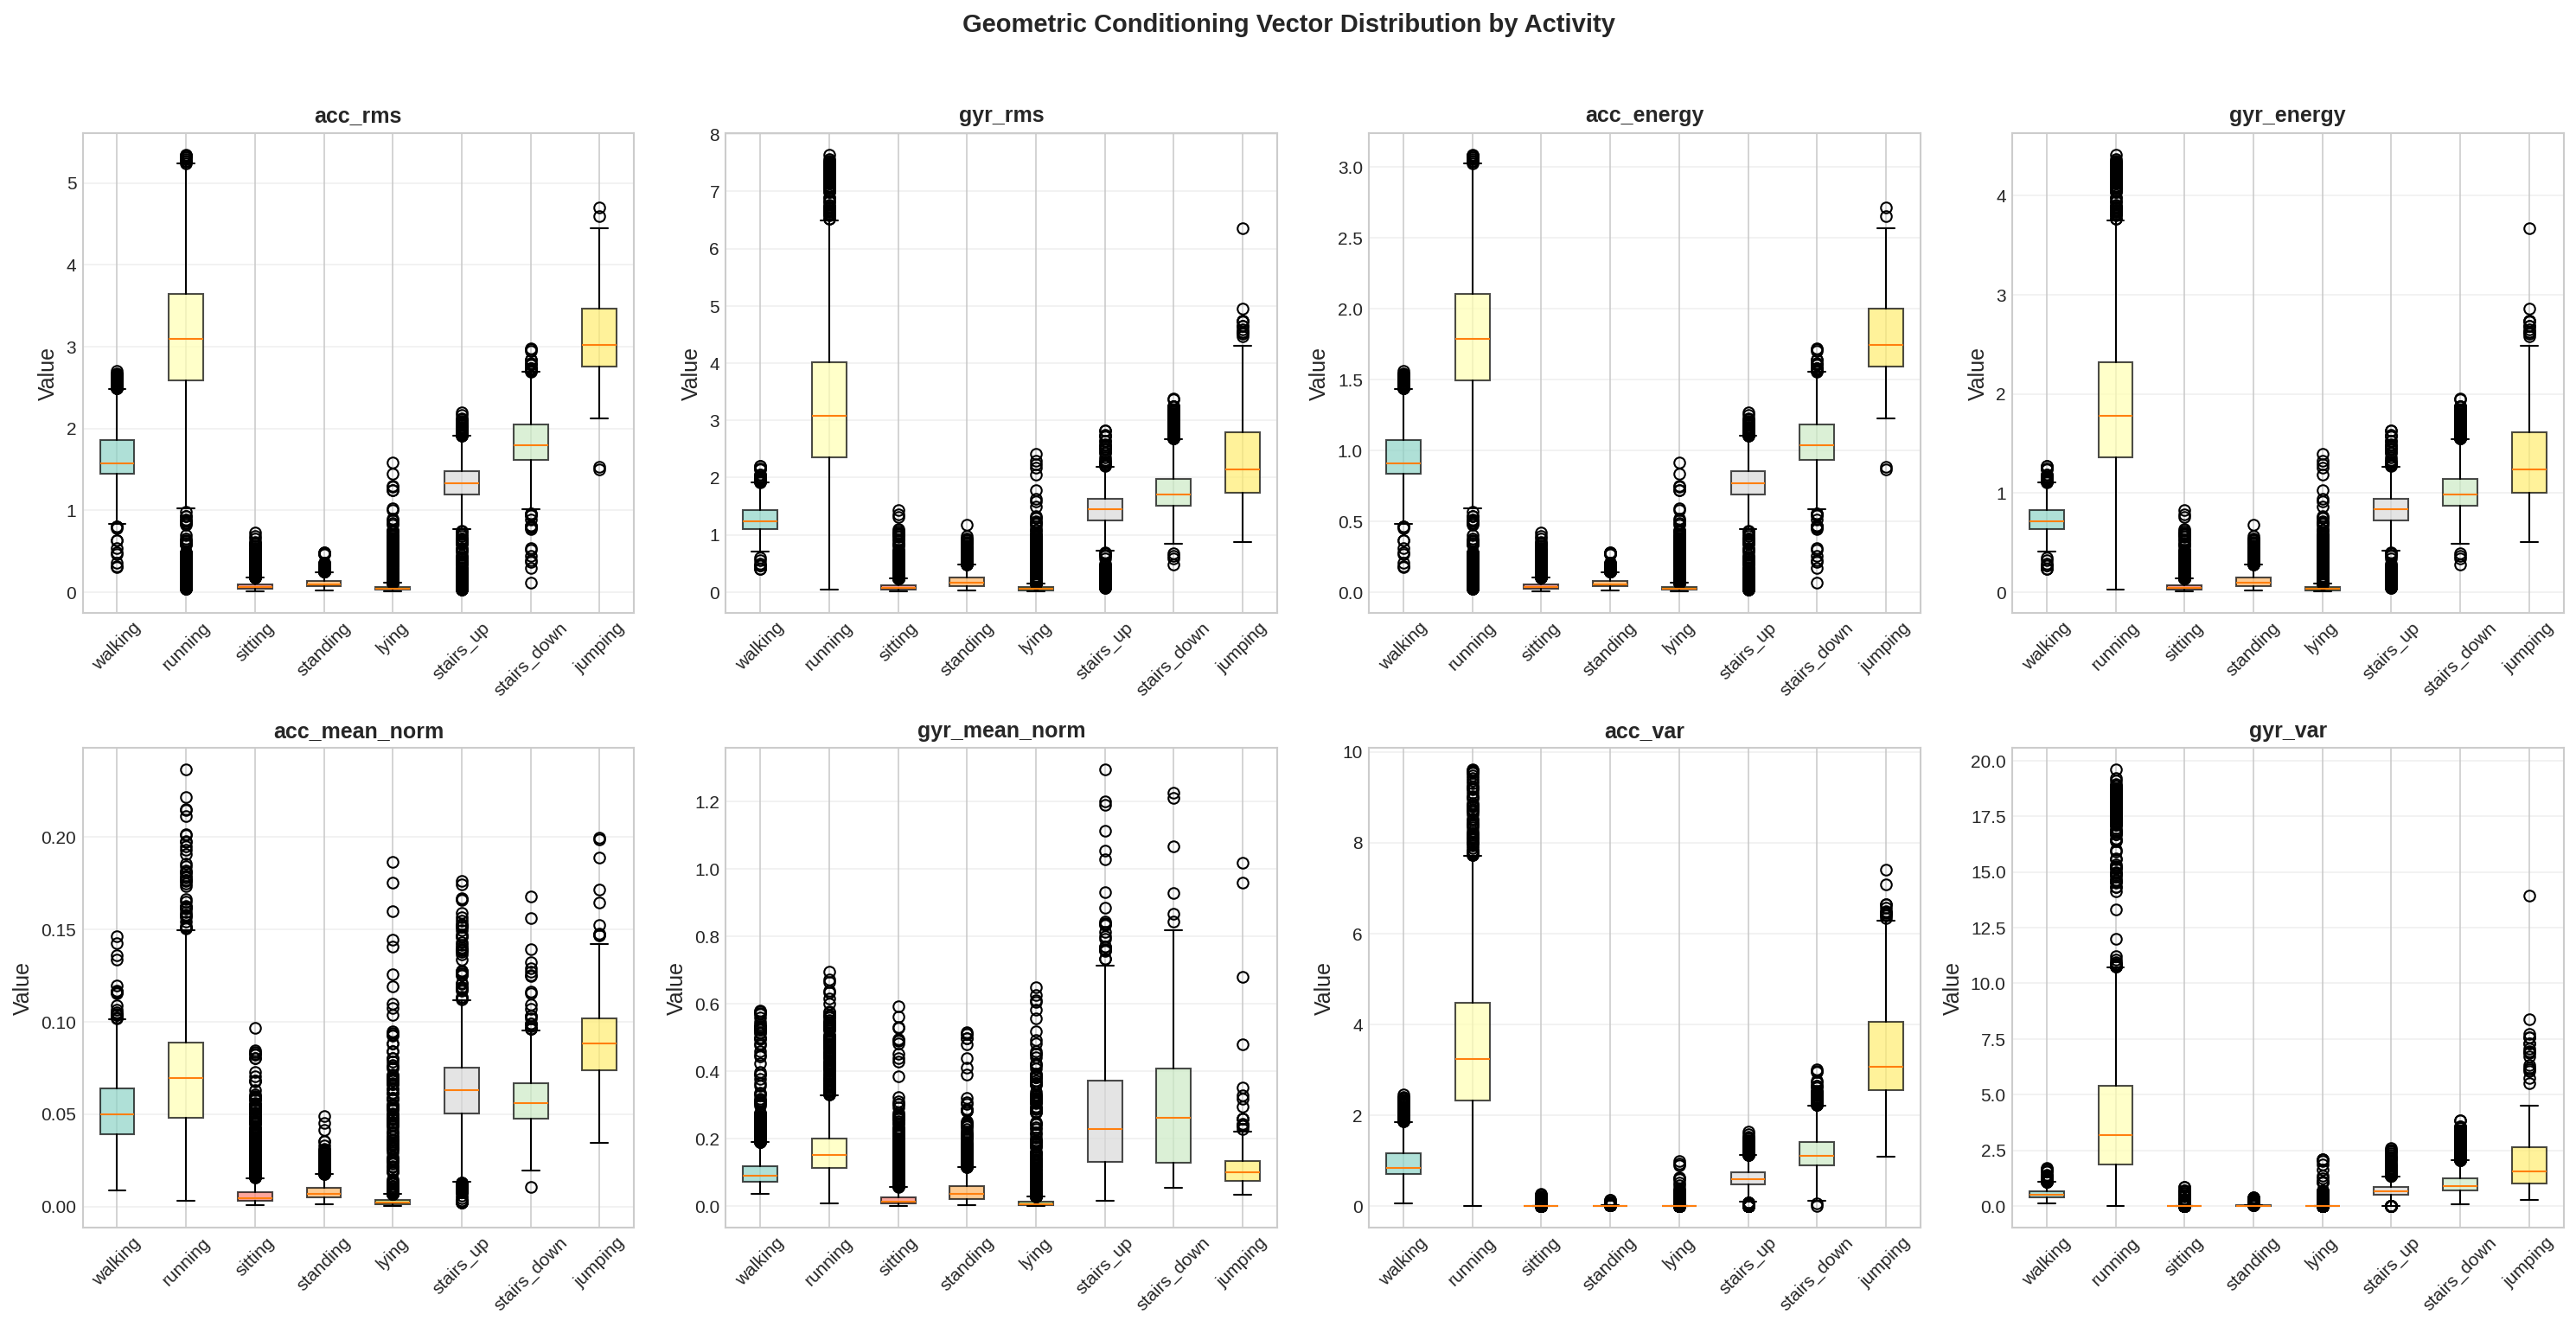

✓ Saved: /content/figures/interpretability/geo_stats_distribution.png


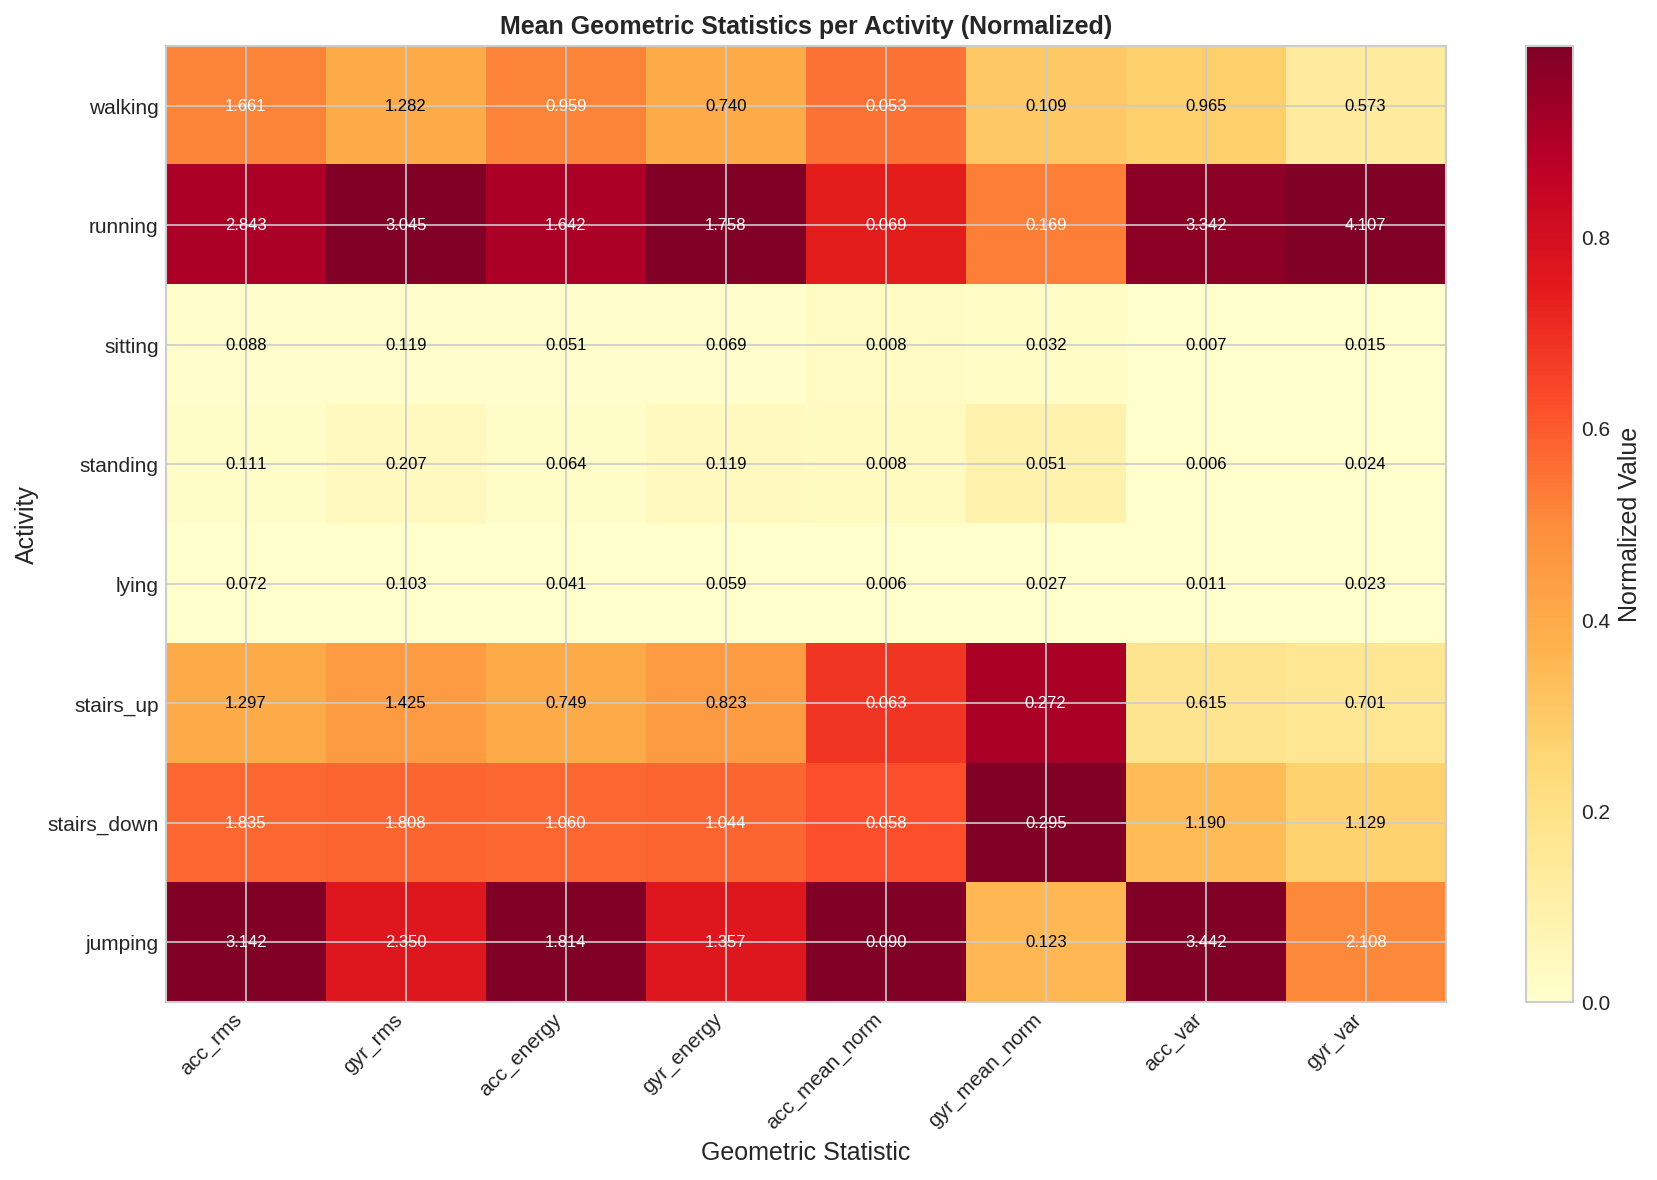

✓ Saved: /content/figures/interpretability/geo_stats_heatmap.png


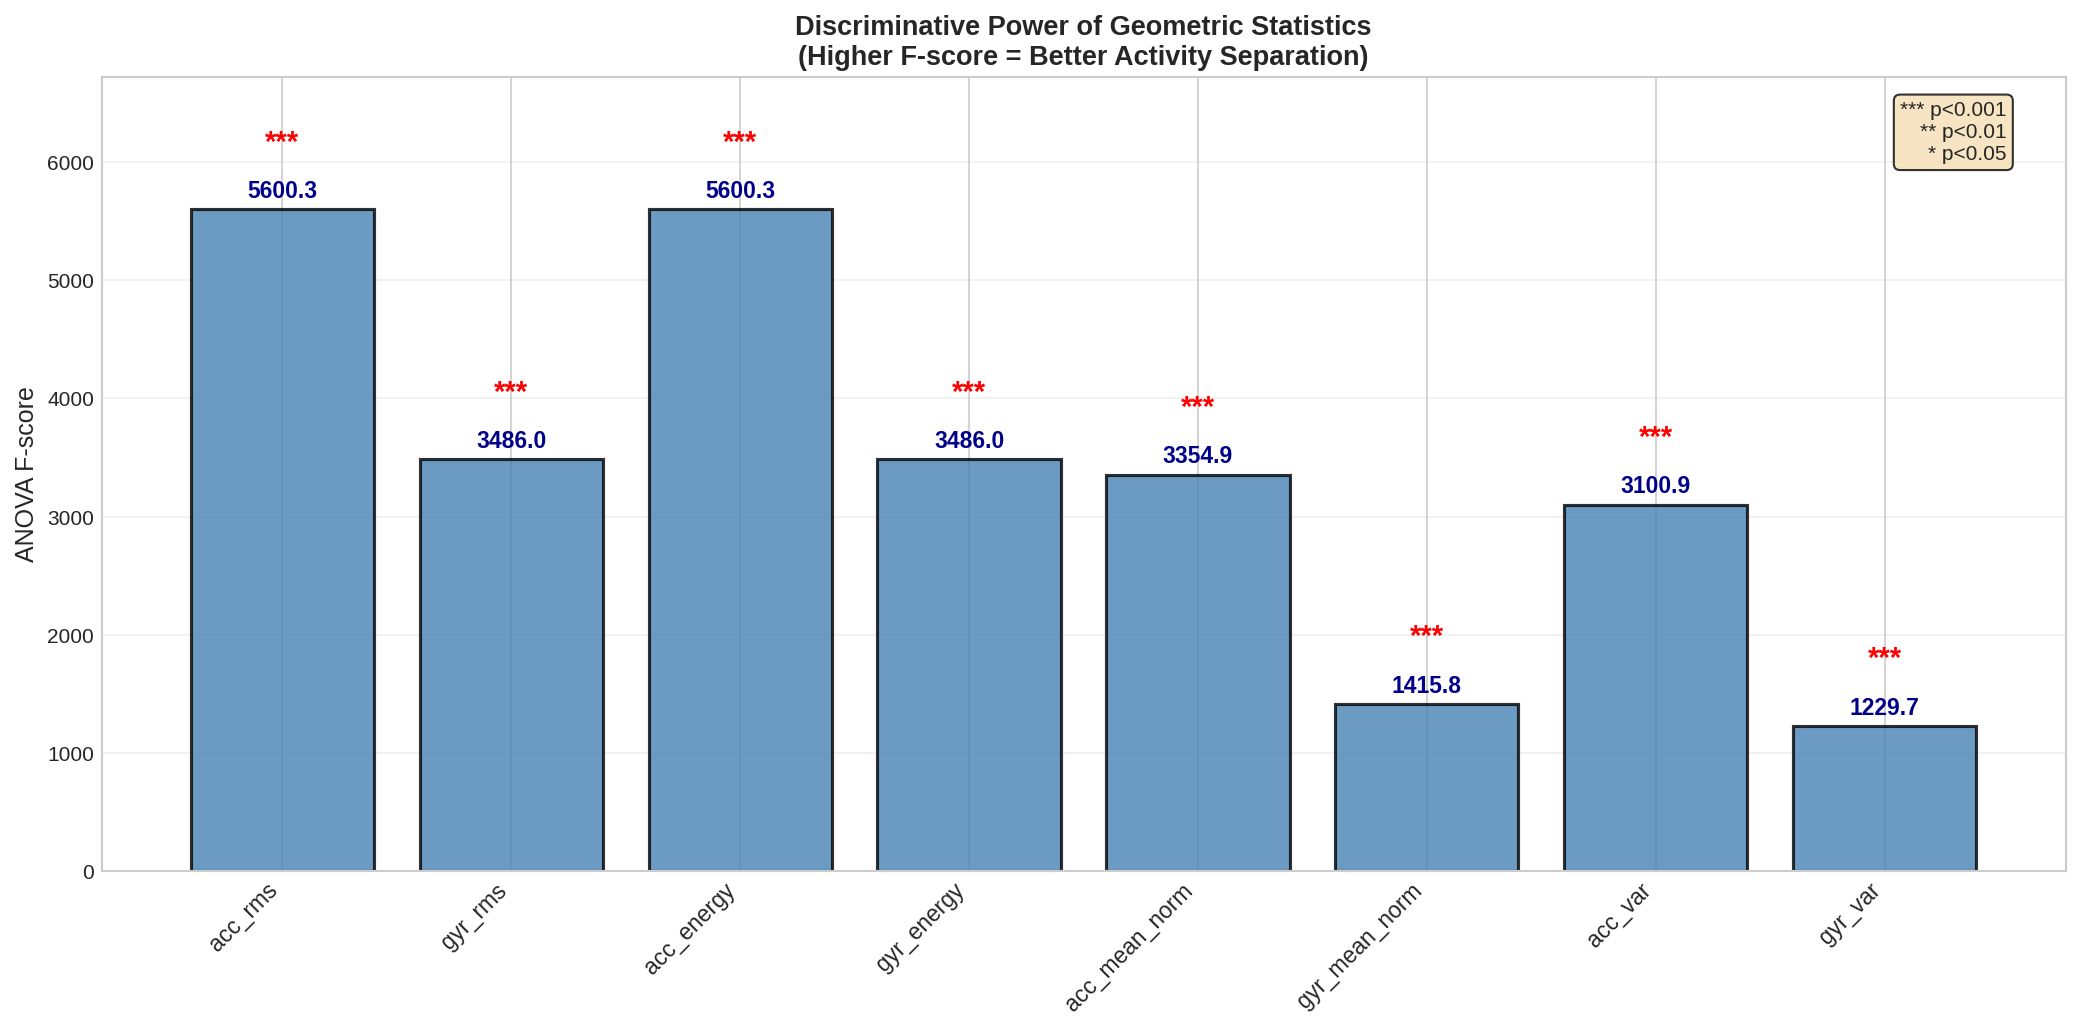

✓ Saved: /content/figures/interpretability/geo_stats_discriminative_power.png

Geometric Statistics Discriminative Power (ANOVA F-score):
  acc_rms        : F=   5600.30, p=0.00e+00 ***
  gyr_rms        : F=   3486.04, p=0.00e+00 ***
  acc_energy     : F=   5600.30, p=0.00e+00 ***
  gyr_energy     : F=   3486.04, p=0.00e+00 ***
  acc_mean_norm  : F=   3354.85, p=0.00e+00 ***
  gyr_mean_norm  : F=   1415.76, p=0.00e+00 ***
  acc_var        : F=   3100.93, p=0.00e+00 ***
  gyr_var        : F=   1229.69, p=0.00e+00 ***


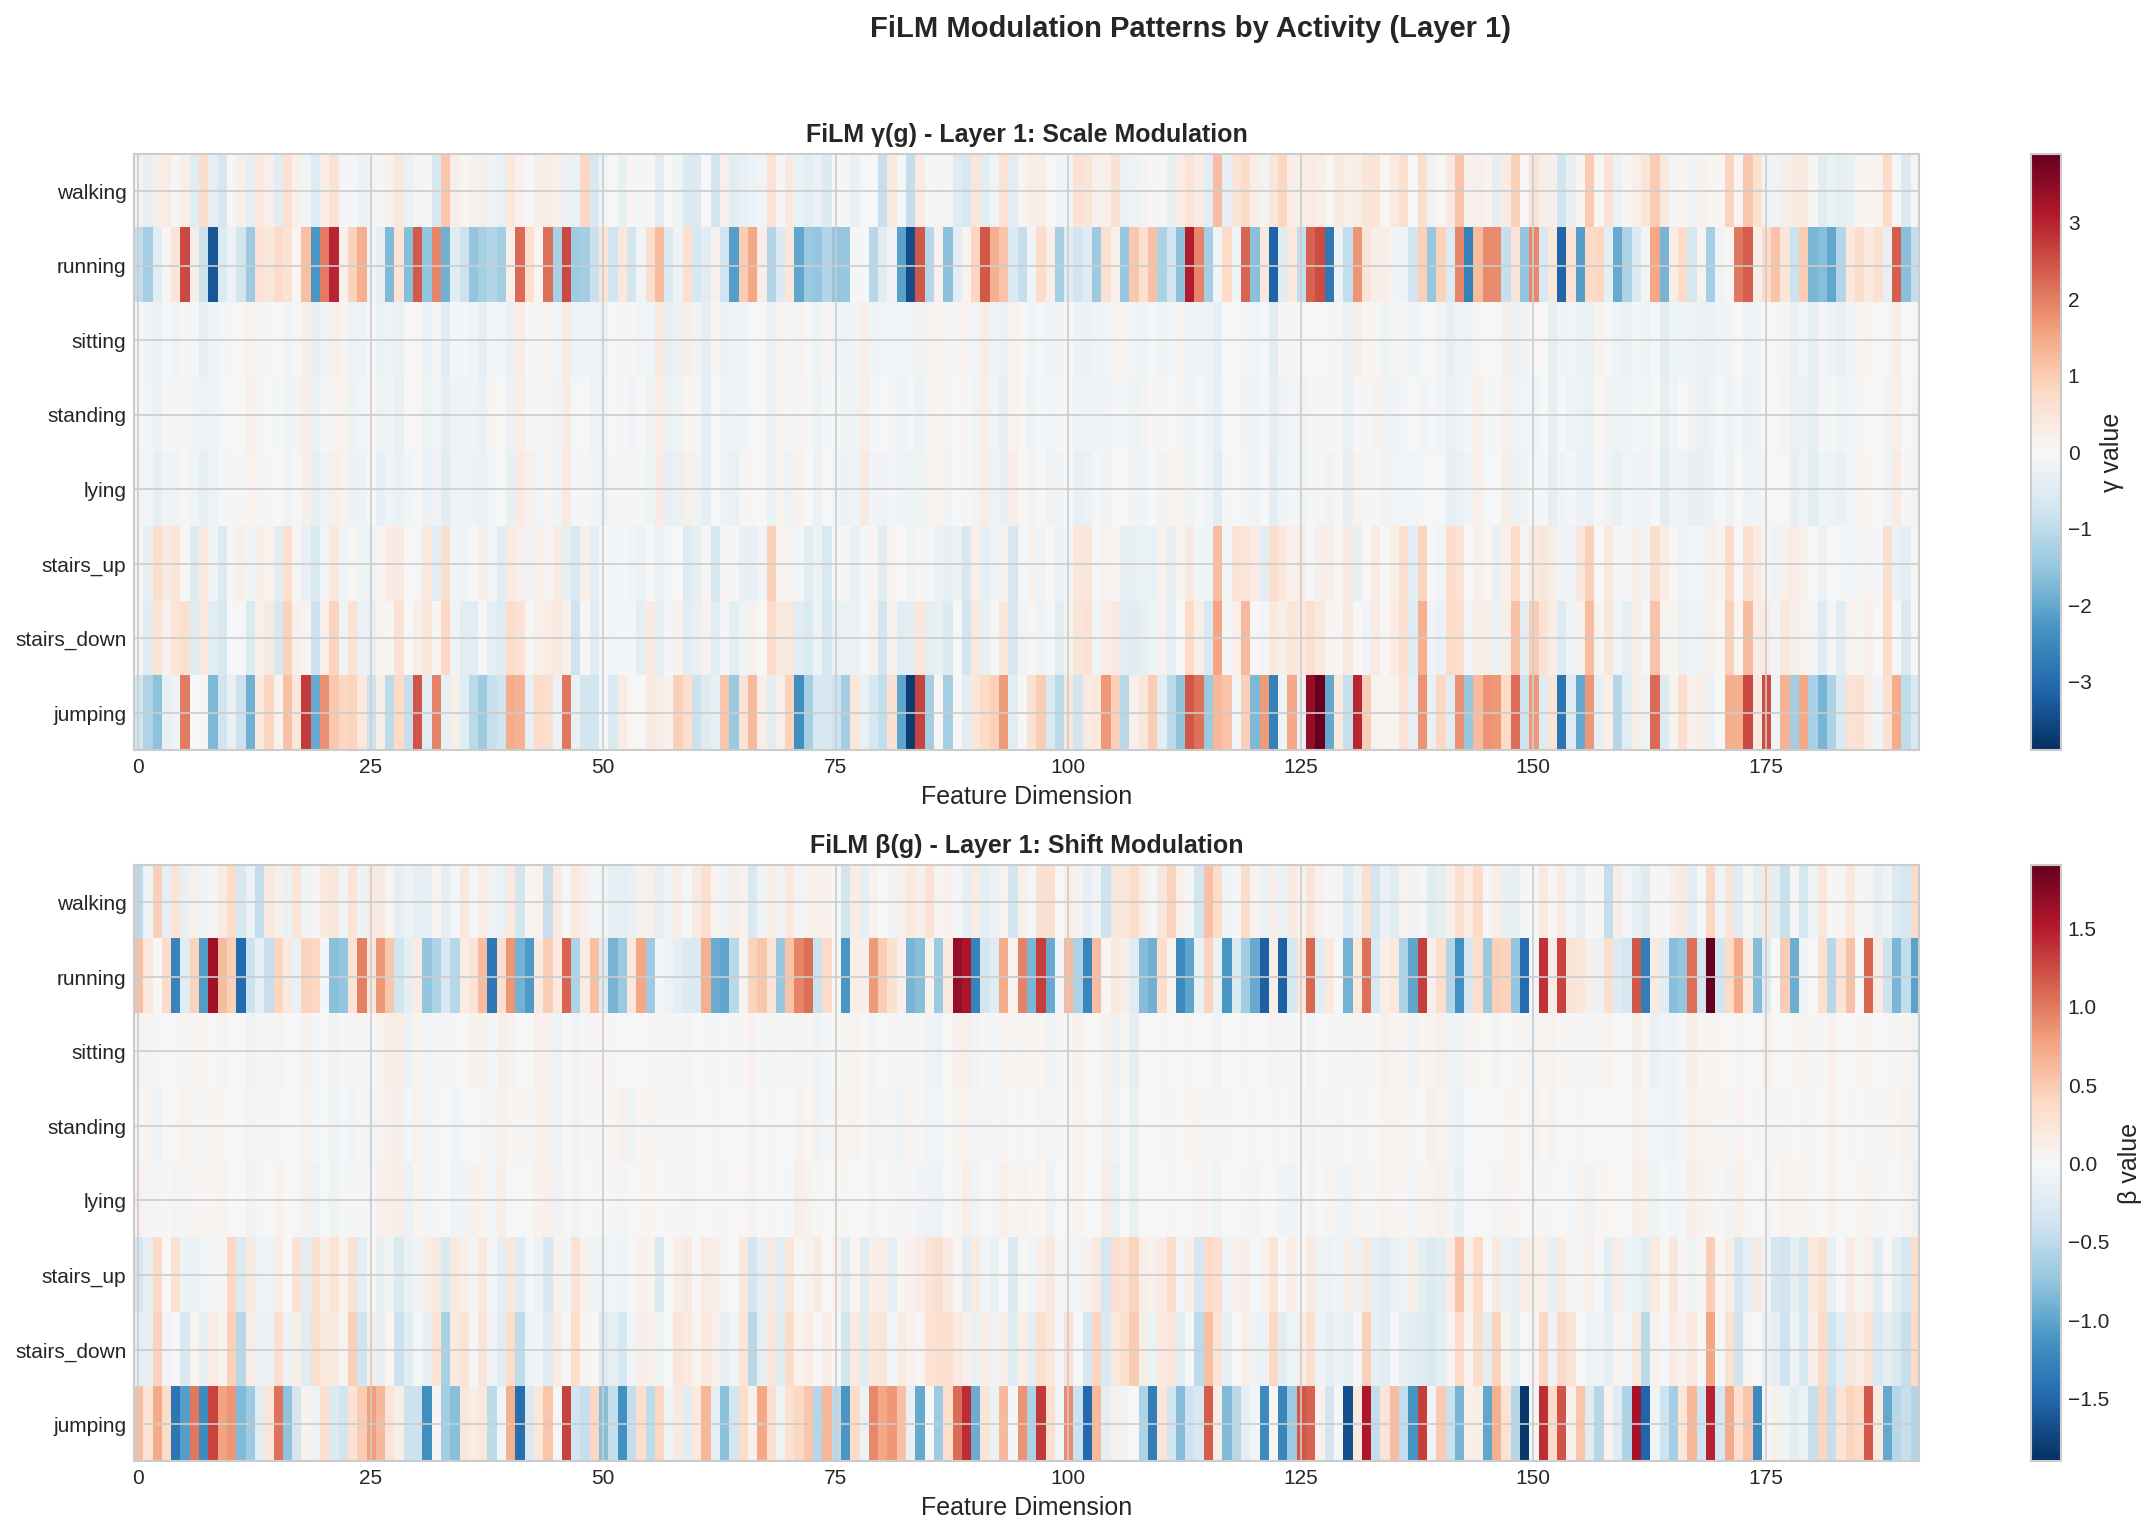

✓ Saved: /content/figures/interpretability/film_modulation_layer1.png


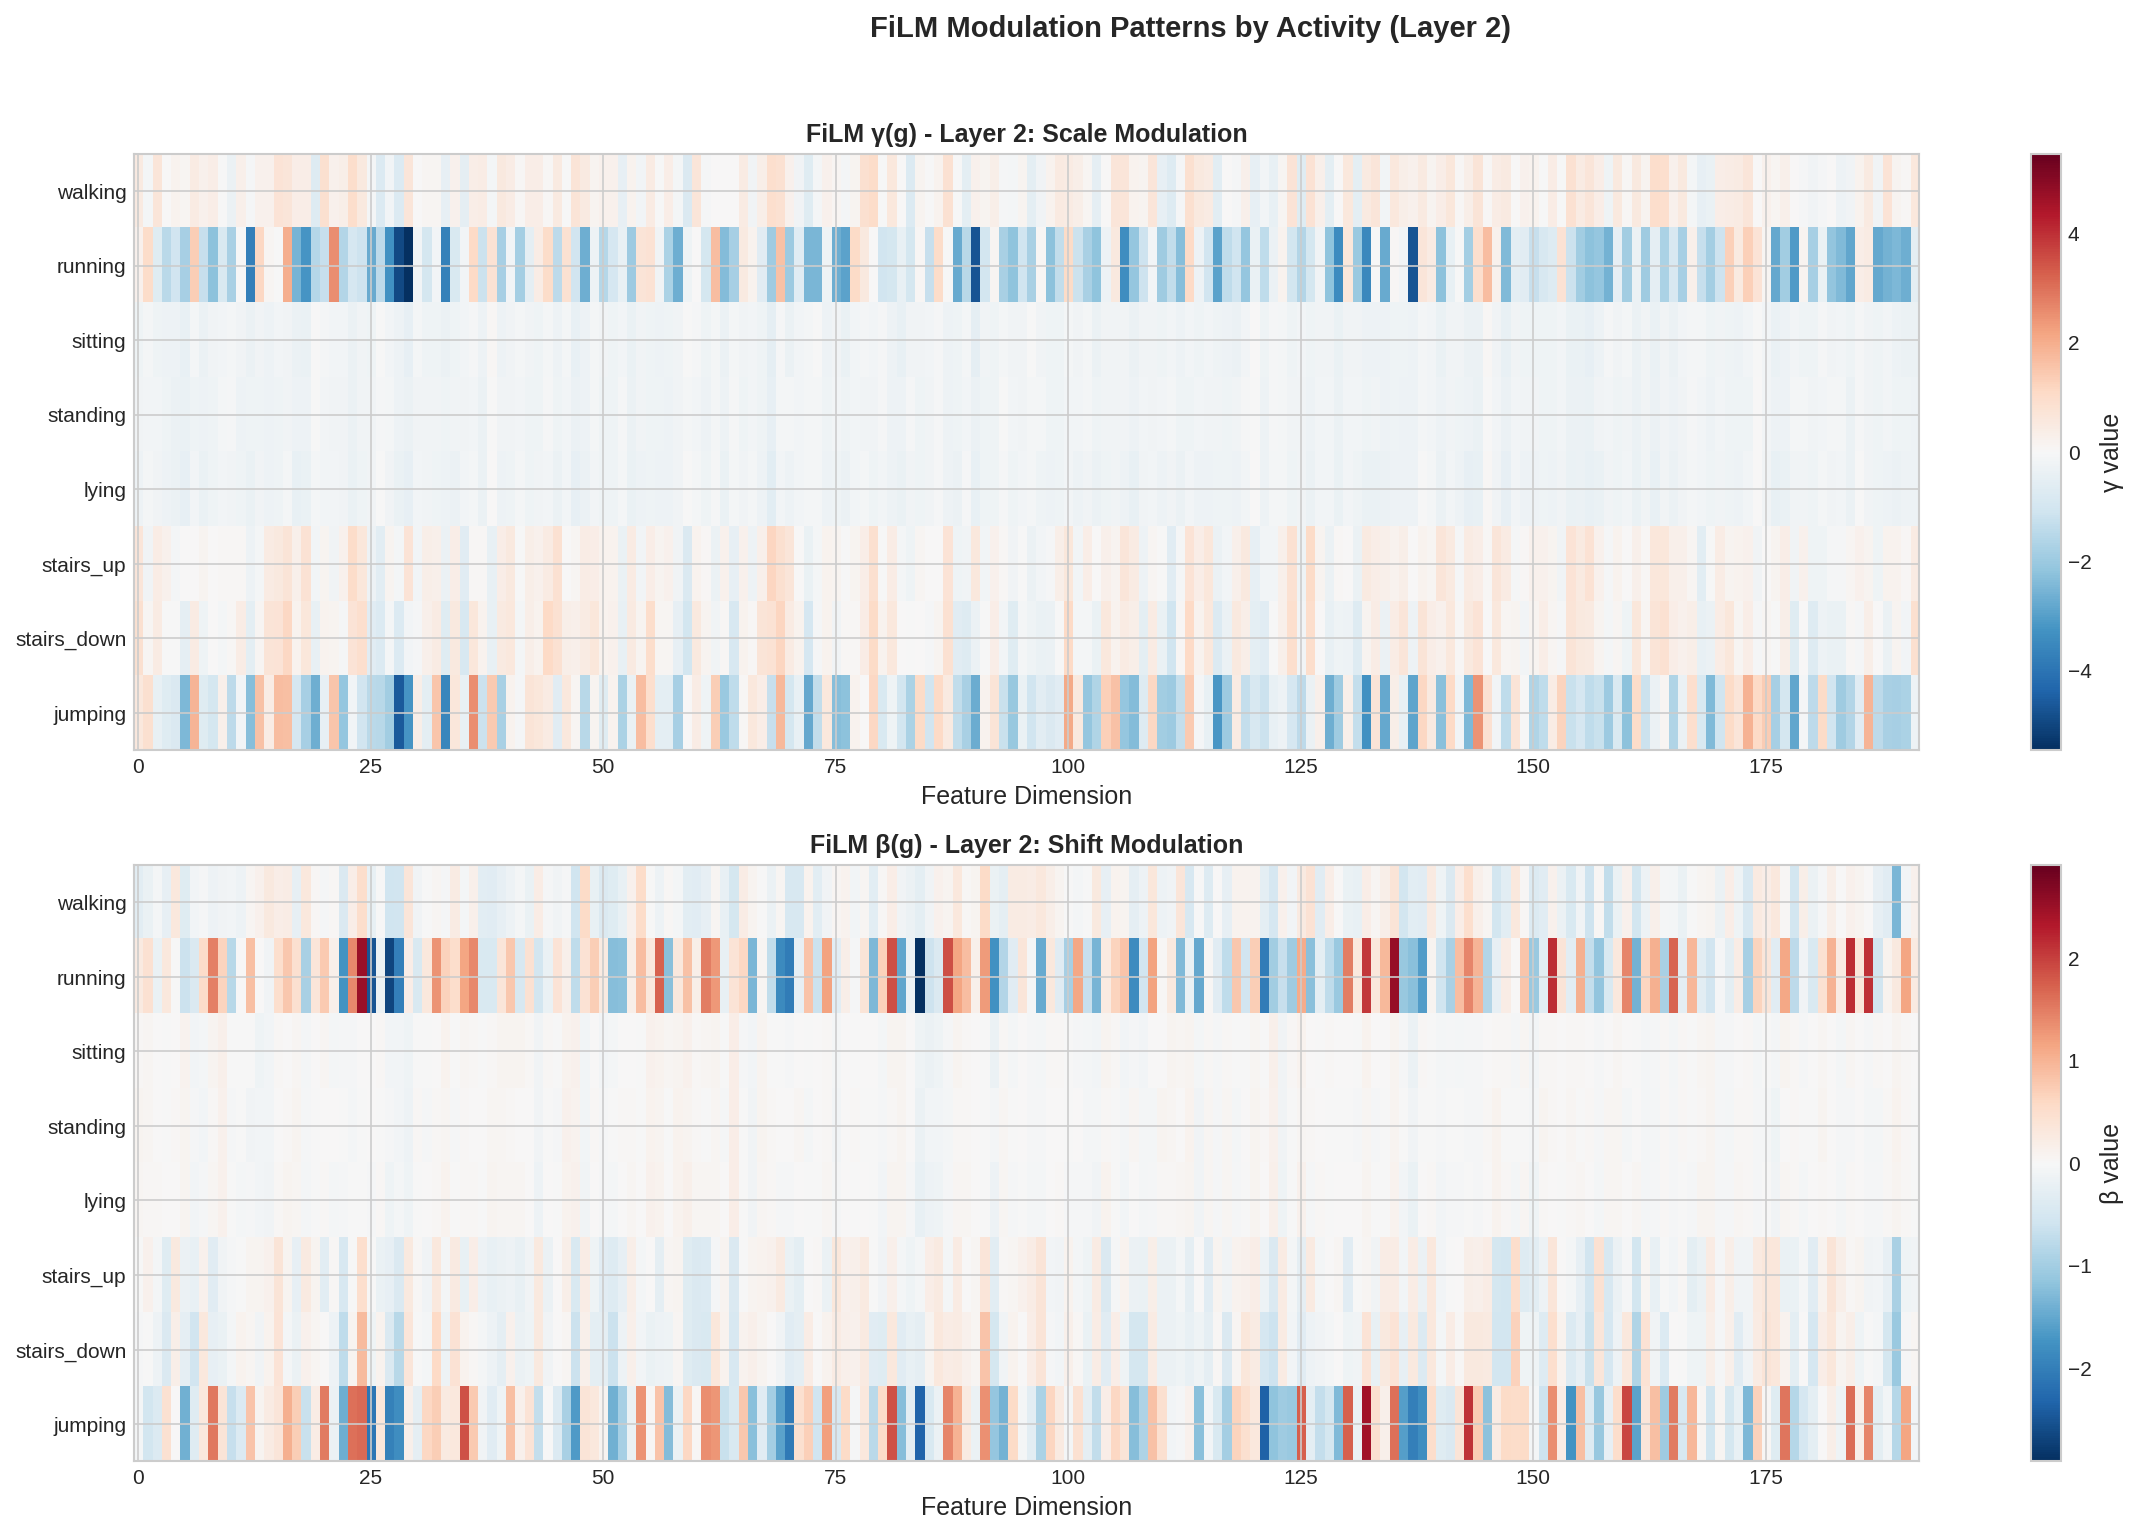

✓ Saved: /content/figures/interpretability/film_modulation_layer2.png


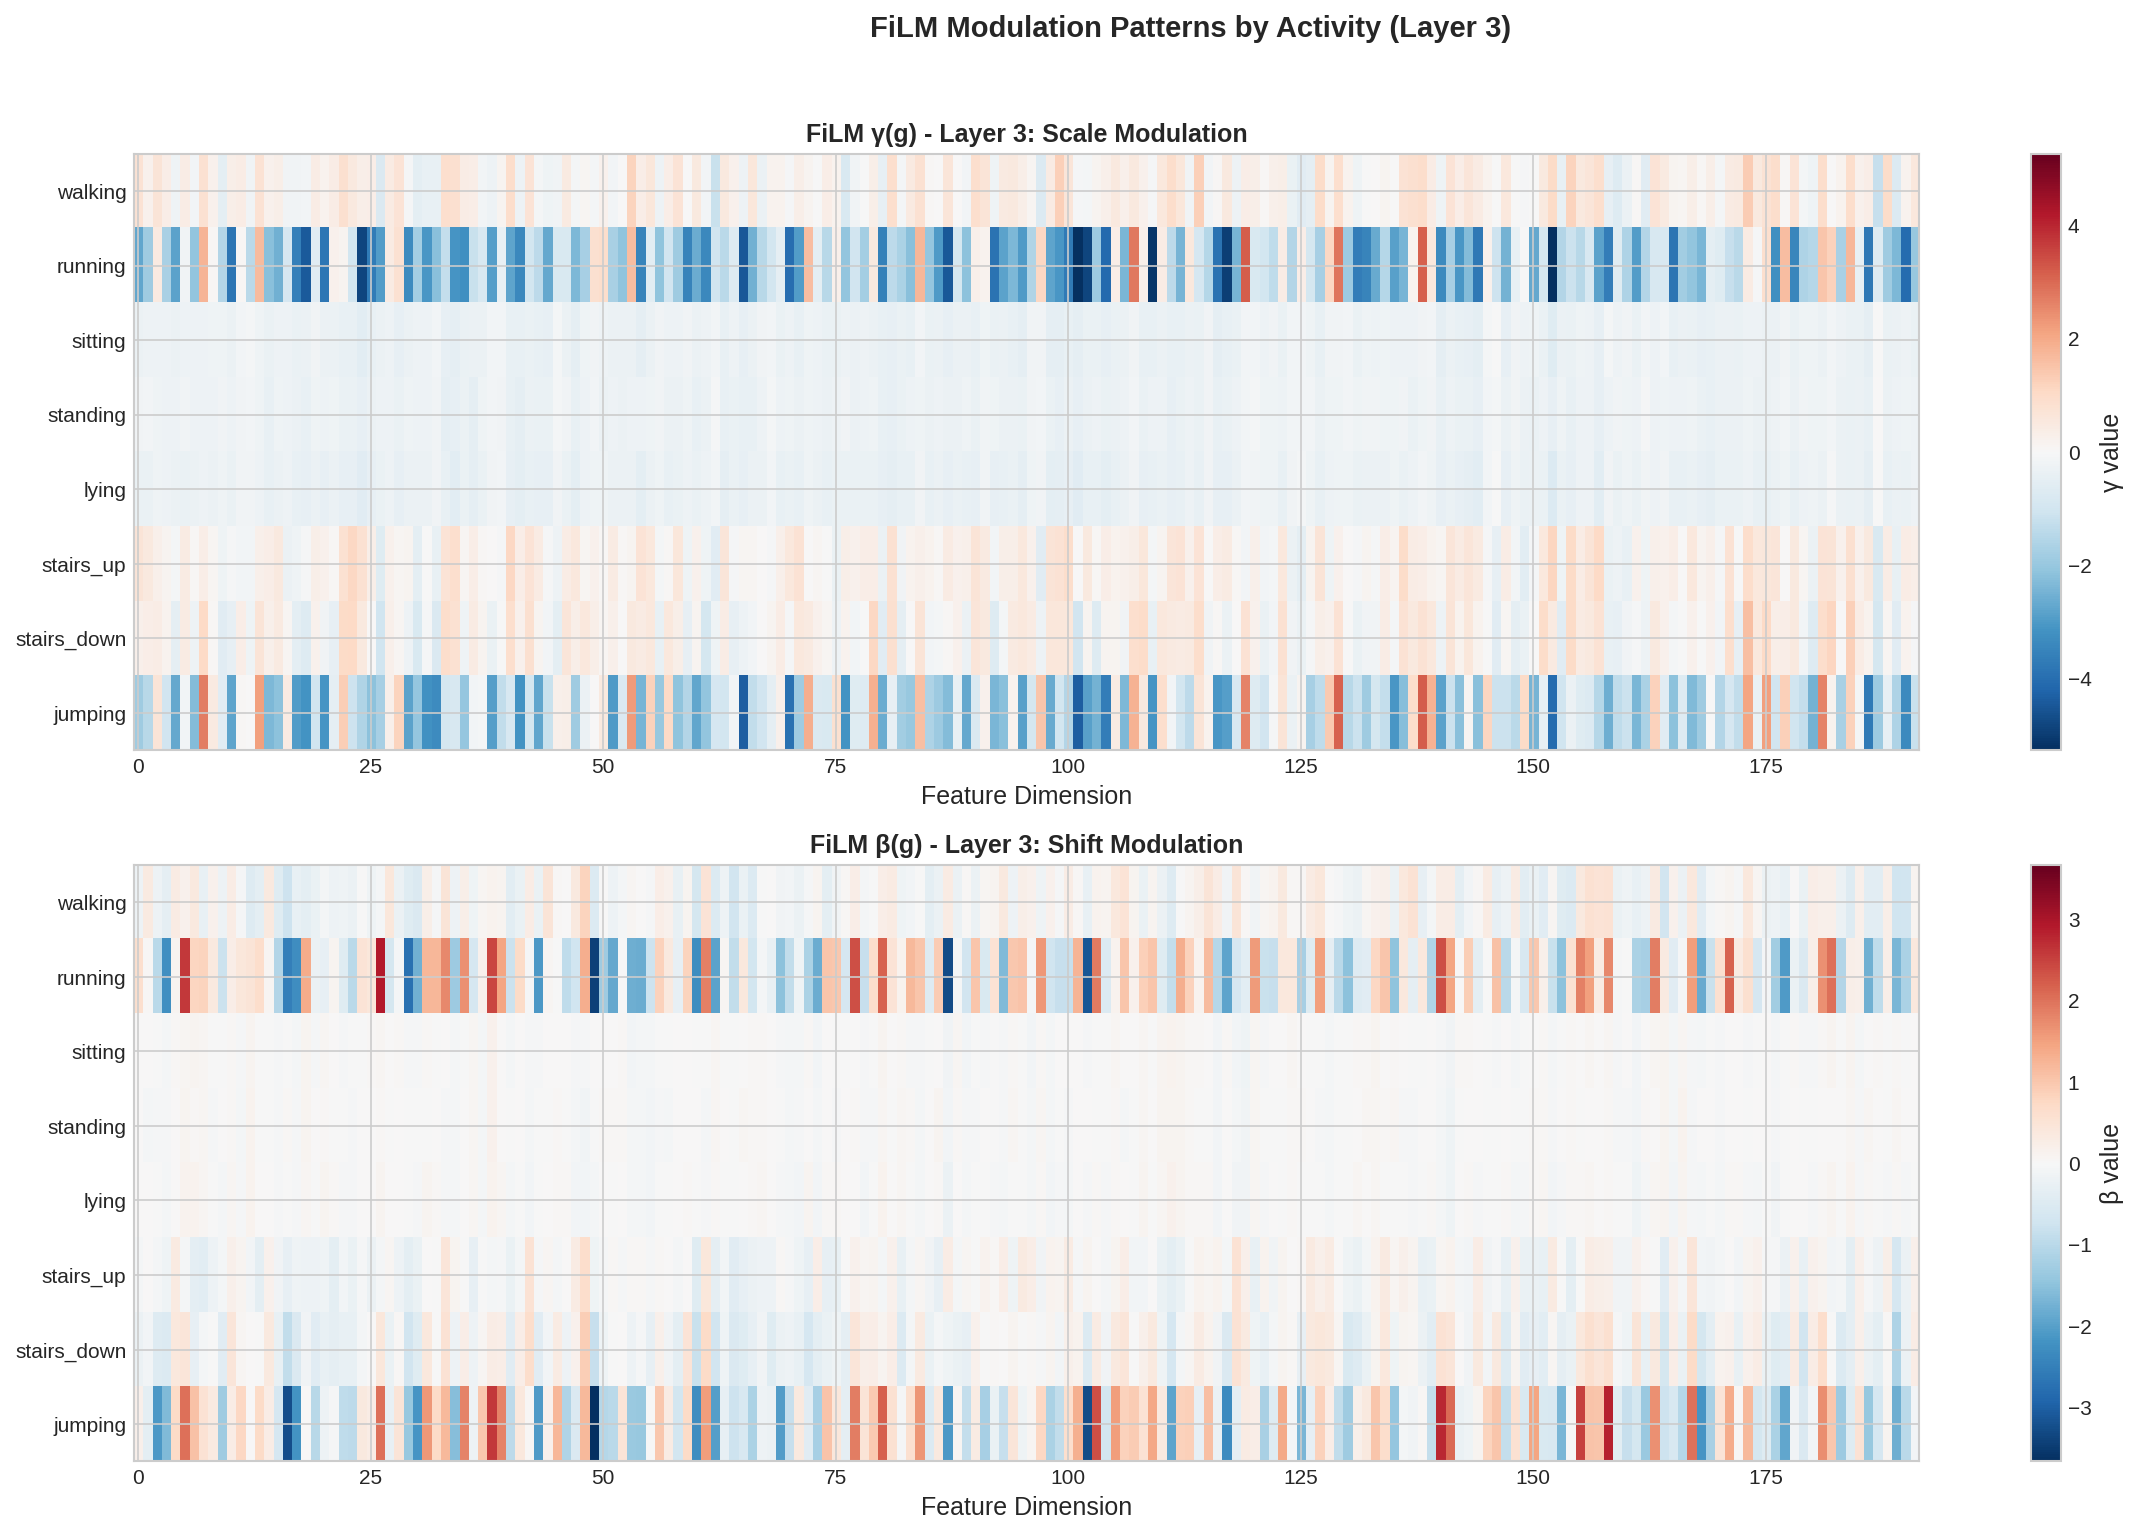

✓ Saved: /content/figures/interpretability/film_modulation_layer3.png


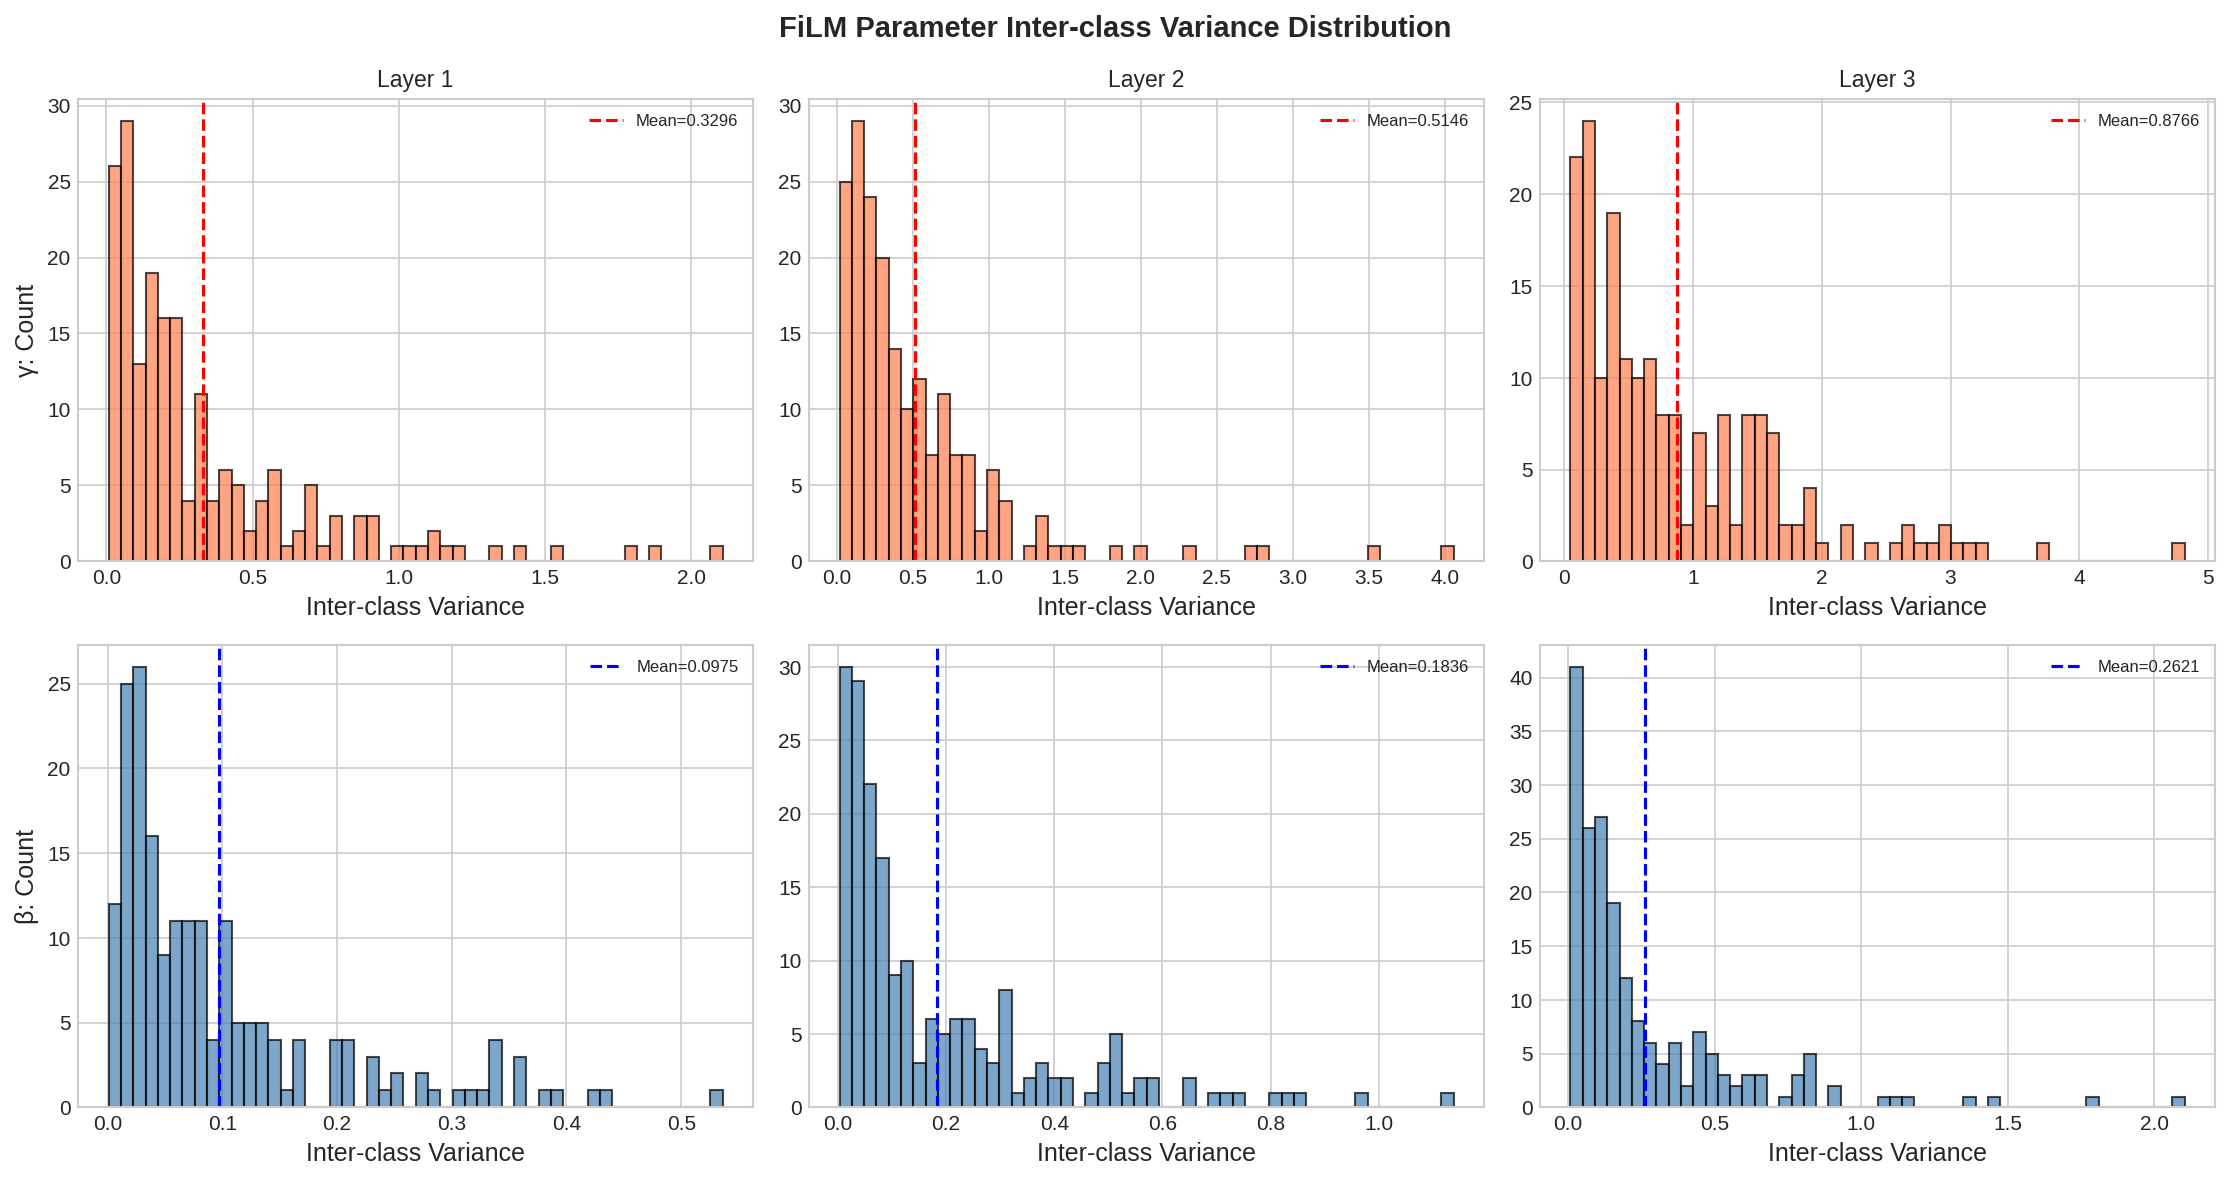

✓ Saved: /content/figures/interpretability/film_variance_analysis.png


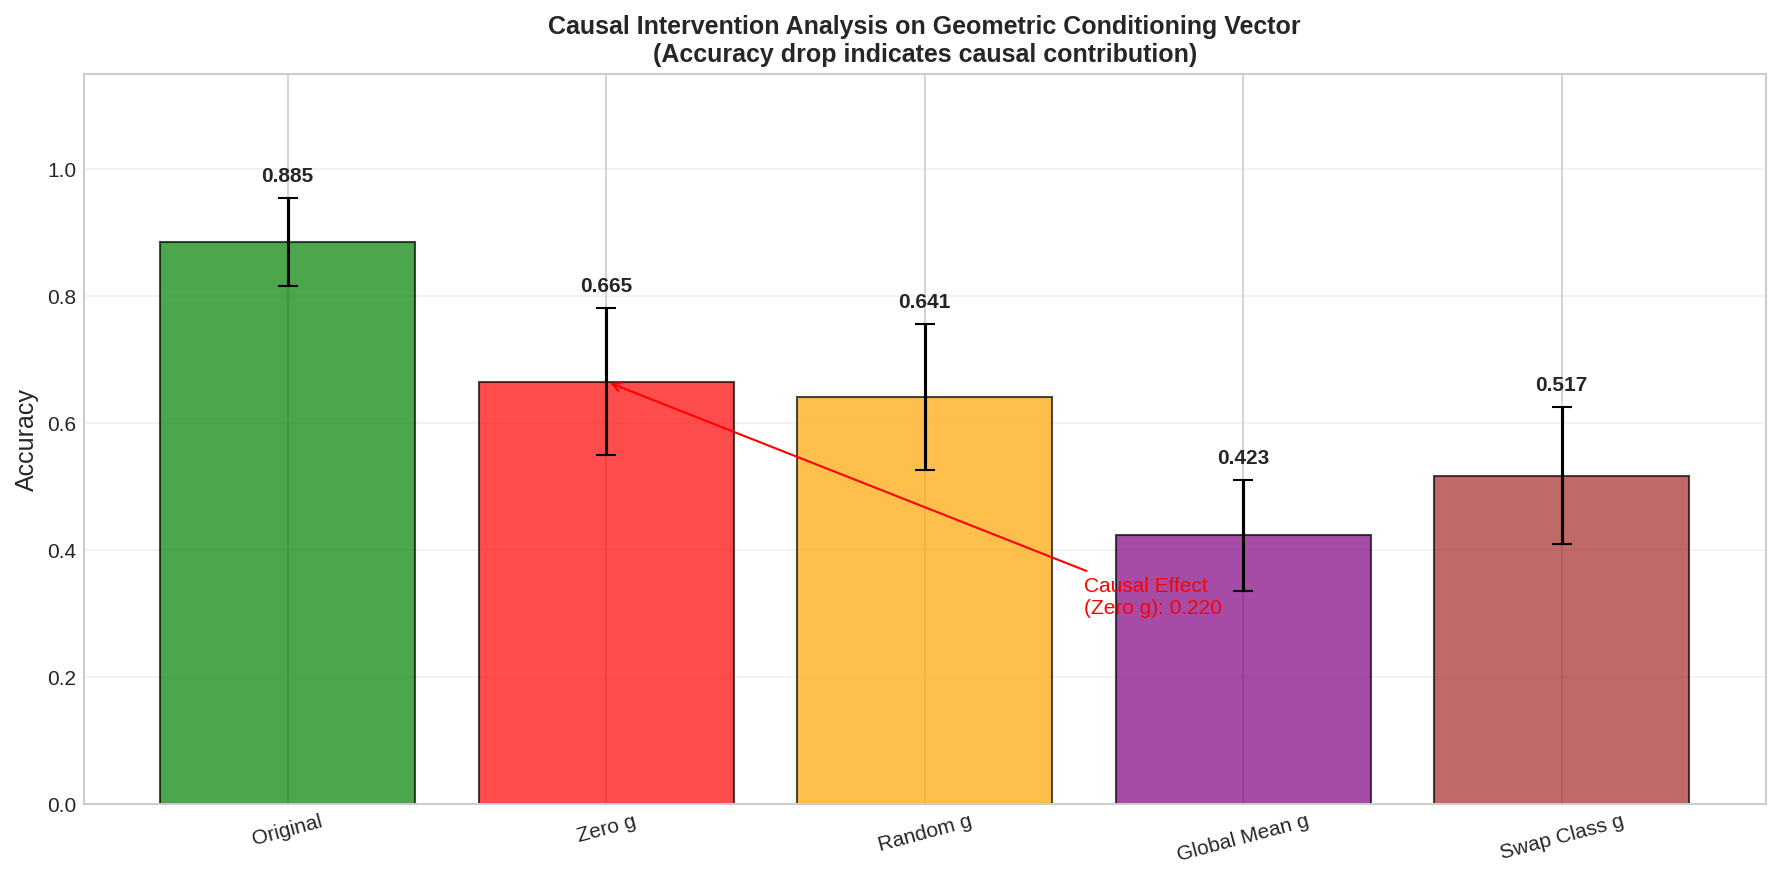

✓ Saved: /content/figures/interpretability/causal_intervention_results.png

Causal Intervention Results (Aggregated across all folds):
  original       : 0.8853 ± 0.0694
  zero_g         : 0.6655 ± 0.1162
  random_g       : 0.6411 ± 0.1149
  global_mean_g  : 0.4234 ± 0.0870
  swap_class_g   : 0.5173 ± 0.1079

  >>> Causal Effect of Geometric Conditioning: 0.2198

[Part 2] Generating multi-scale branch visualizations...


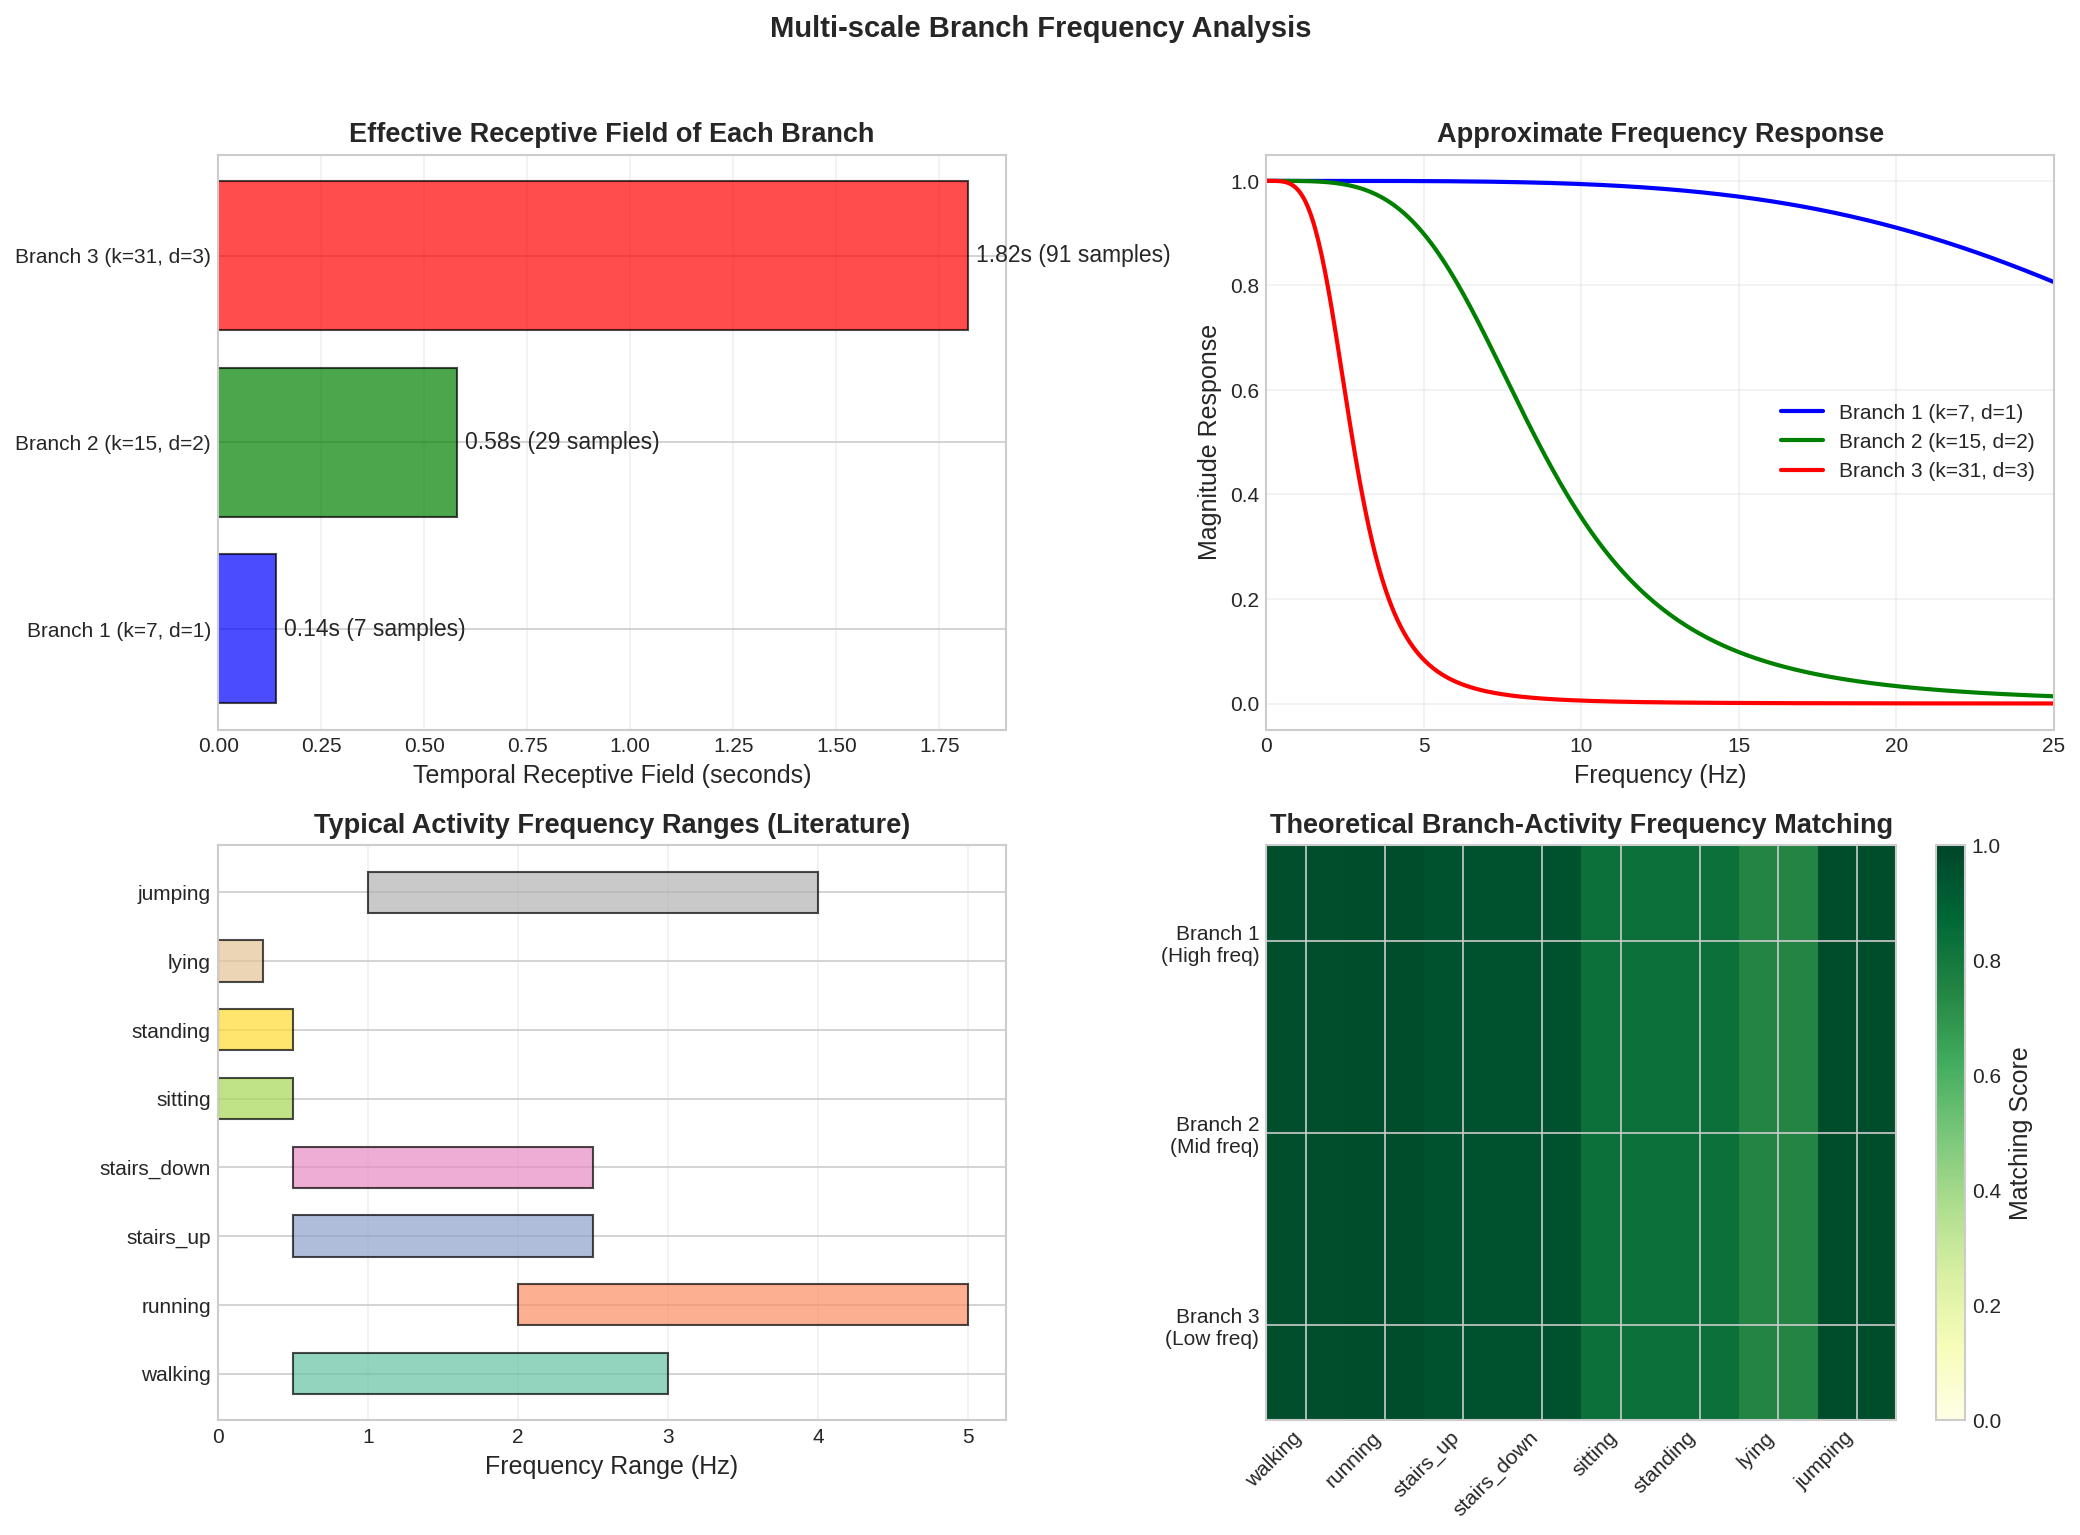

✓ Saved: /content/figures/interpretability/branch_frequency_analysis.png


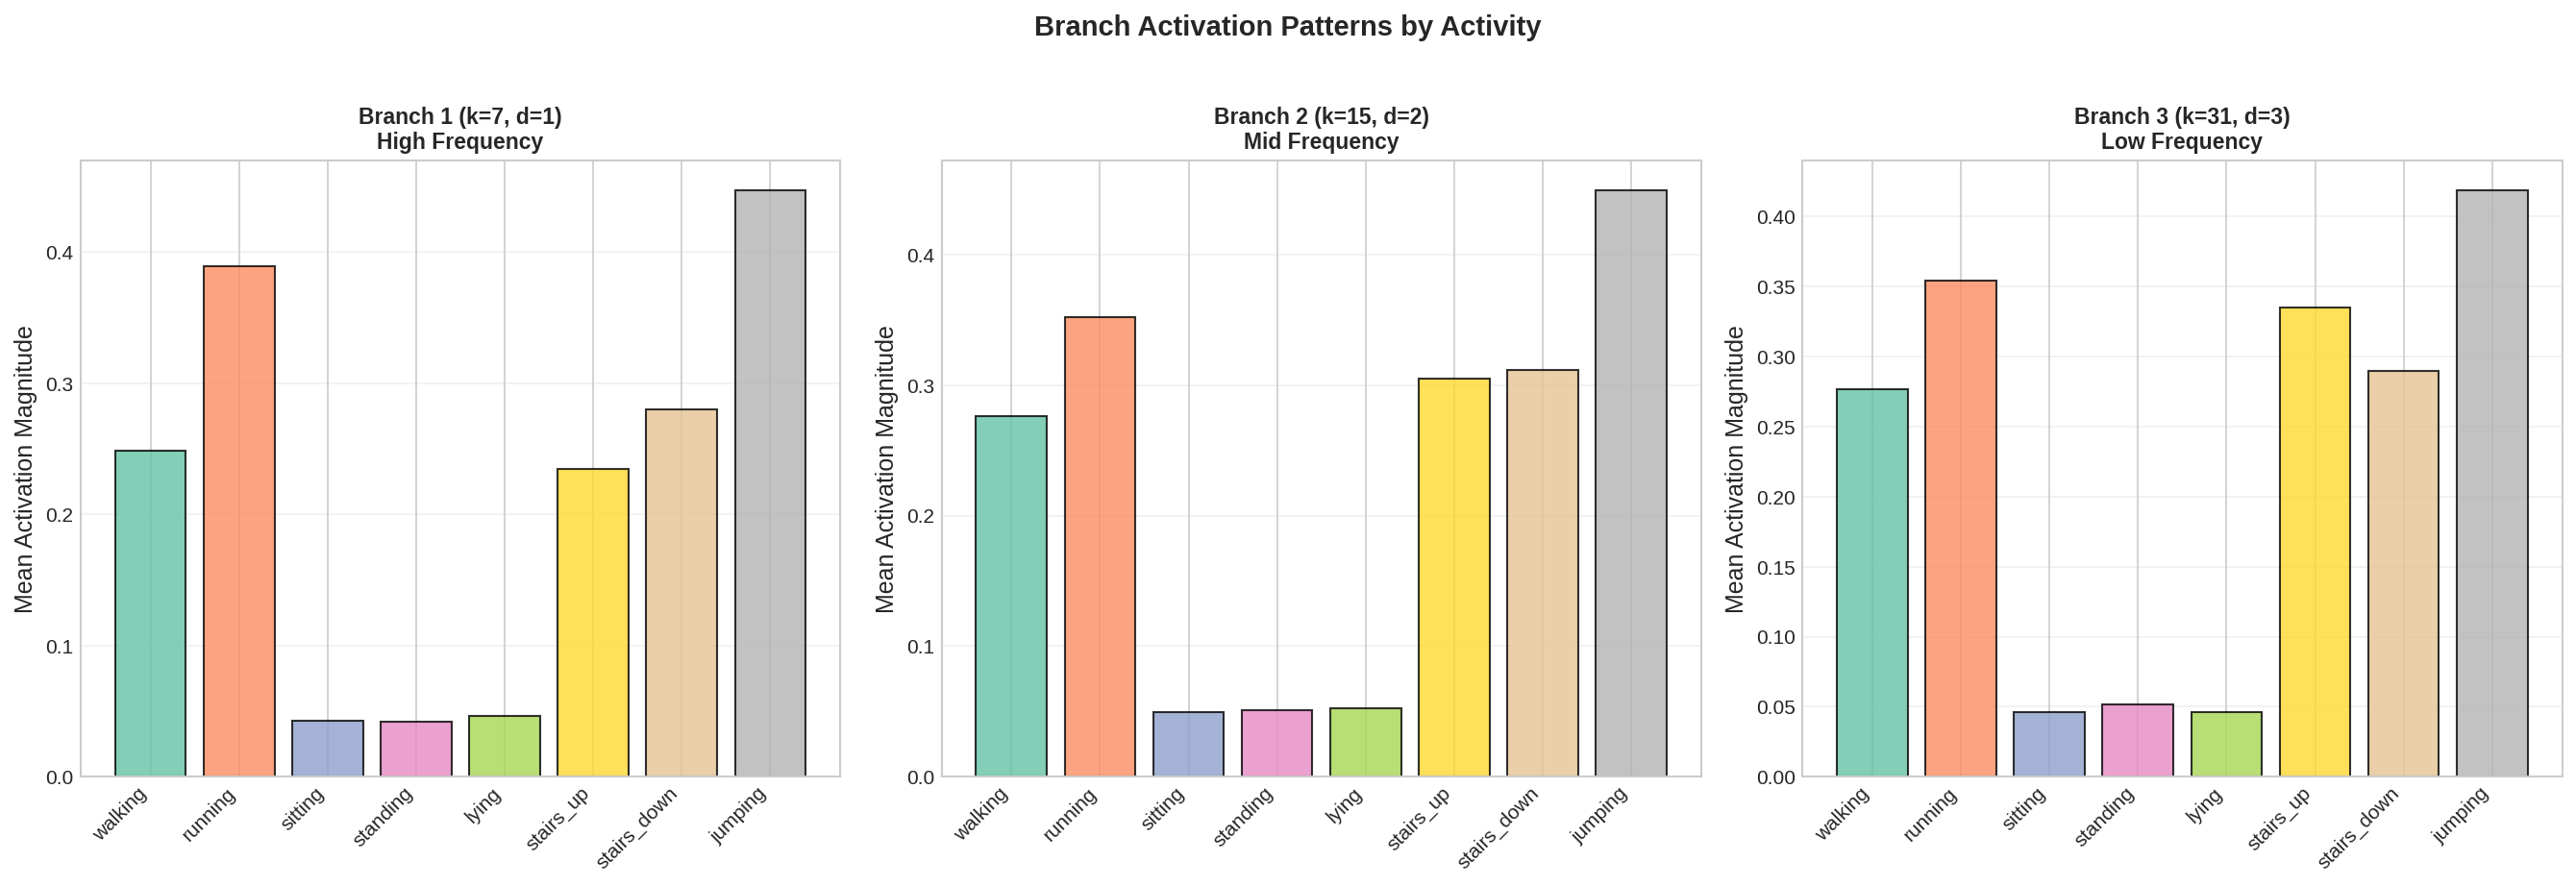

✓ Saved: /content/figures/interpretability/branch_activation_patterns.png


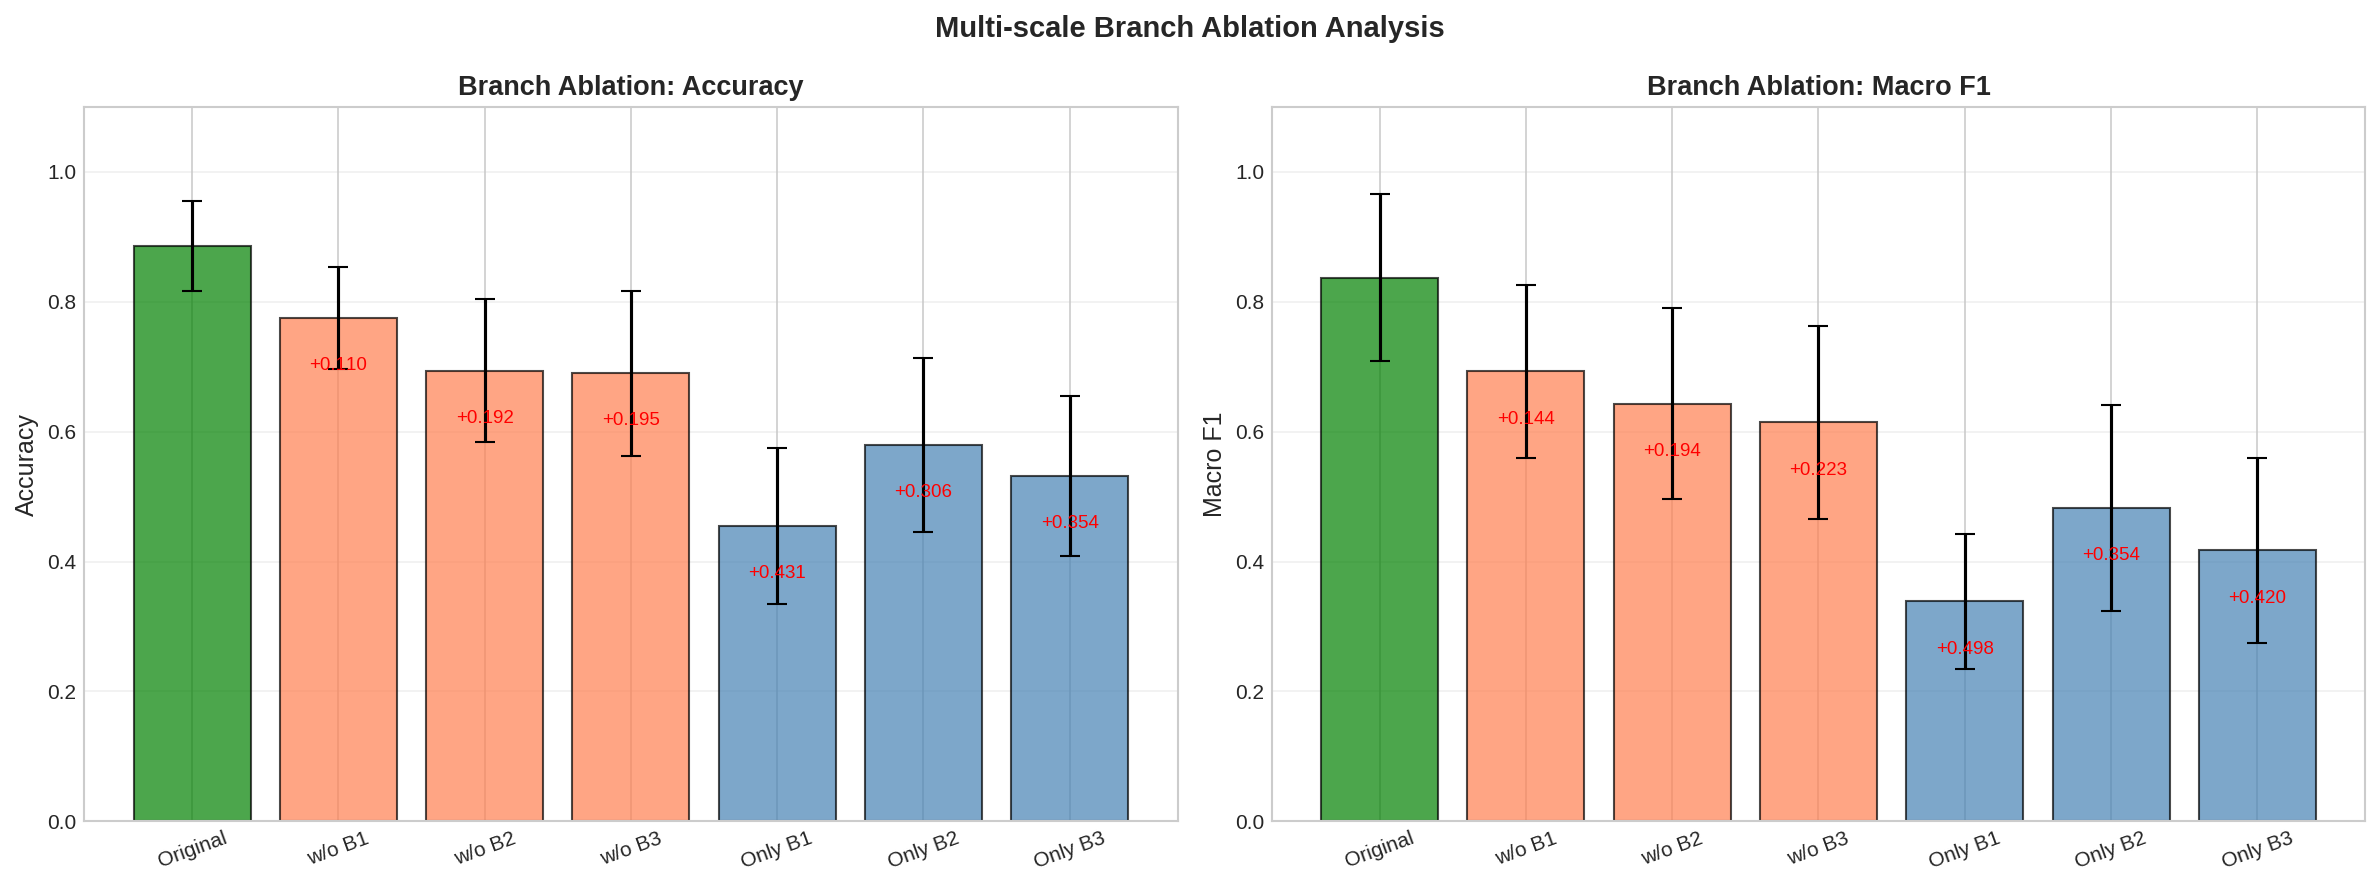

✓ Saved: /content/figures/interpretability/branch_ablation_results.png

Branch Ablation Results (Aggregated across all folds):
  Condition         Accuracy   Macro F1      Δ Acc       Δ F1
  -------------------------------------------------------
  original            0.8853     0.8368    +0.0000    +0.0000
  no_b1               0.7751     0.6926    -0.1102    -0.1442
  no_b2               0.6935     0.6432    -0.1918    -0.1936
  no_b3               0.6902     0.6142    -0.1952    -0.2226
  only_b1             0.4544     0.3385    -0.4309    -0.4983
  only_b2             0.5796     0.4824    -0.3057    -0.3544
  only_b3             0.5313     0.4170    -0.3540    -0.4198


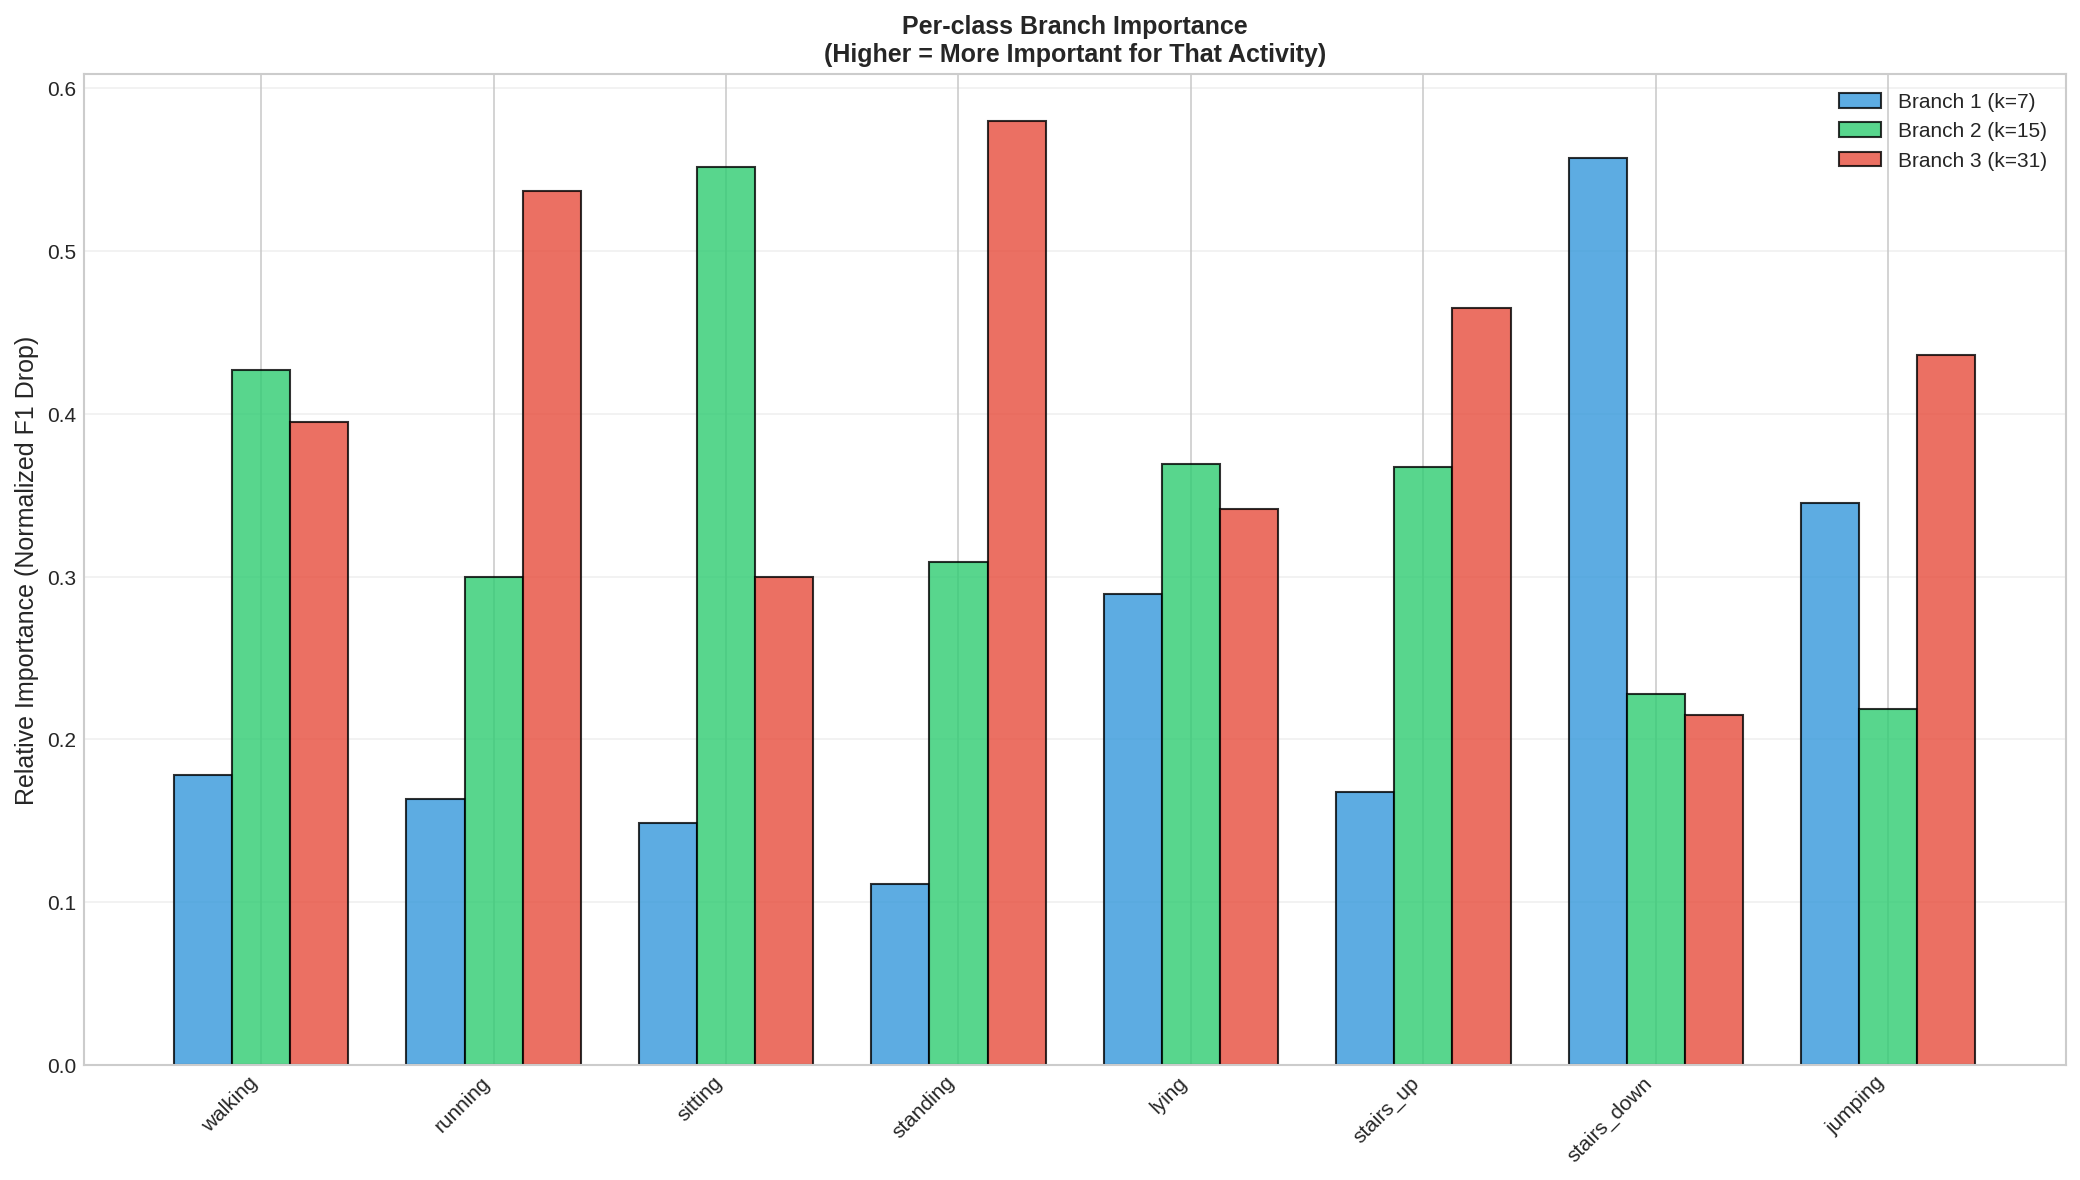

✓ Saved: /content/figures/interpretability/branch_per_class_importance.png

Interpretability Analysis Complete!

All figures saved to: /content/figures/interpretability
Summary saved to: /content/figures/interpretability/interpretability_summary.json

Generated files:
  - acc_vs_gyro_importance.png
  - activity_specific_channels.png
  - attention_distance_analysis.png
  - attention_head_specialization.png
  - attention_heads_layer1.png
  - attention_heads_layer2.png
  - attention_heads_layer3.png
  - attention_layer_evolution.png
  - attention_per_activity_last_layer.png
  - branch_ablation_results.png
  - branch_activation_patterns.png
  - branch_frequency_analysis.png
  - branch_per_class_importance.png
  - causal_intervention_results.png
  - cls_aggregation_pattern.png
  - film_modulation_layer1.png
  - film_modulation_layer2.png
  - film_modulation_layer3.png
  - film_variance_analysis.png
  - geo_stats_discriminative_power.png
  - geo_stats_distribution.png
  - geo_stats_heatmap.p

In [25]:
# ================================================================================
# RCCMix-HAR++ Interpretability Analysis (Fixed Version)
# ================================================================================
# This script provides comprehensive interpretability analysis for the RCCMix-HAR++
# model, focusing on:
#   1. Geometric Conditioning Vector Analysis
#   2. Multi-scale Branch Contribution Analysis
#
# Requirements: Run after Step 11 (model training completed)
# ================================================================================

import os
import sys
import json
import warnings
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import freqz
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")

# ================================================================================
# Configuration
# ================================================================================
print("=" * 80)
print("RCCMix-HAR++ Interpretability Analysis (Fixed Version)")
print("=" * 80)

# Directories - adjust these paths to your environment
BASE = Path("/content")
features_dir = BASE / "features"
configs_dir = BASE / "configs"
logs_dir = BASE / "logs"
fig_dir = BASE / "figures" / "interpretability"
models_dir = BASE / "models"

fig_dir.mkdir(parents=True, exist_ok=True)

# Random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model hyperparameters (must match training)
SEQ_LEN = 8
BATCH_SIZE = 32
D_MODEL = 192
N_HEADS = 6
N_LAYERS = 3
D_FF = 4 * D_MODEL
DROPOUT = 0.0  # Set to 0 for inference
WINDOW_SAMPLES = 150

# Analyze ALL folds (0-14)
ANALYSIS_FOLDS = list(range(15))

# Load configuration
with open(configs_dir / 'classes.json', 'r') as f:
    classes_cfg = json.load(f)
with open(configs_dir / 'splits.json', 'r') as f:
    splits_cfg = json.load(f)

CLASS_NAMES = [classes_cfg['id_to_label'][str(i)] for i in range(classes_cfg['num_classes'])]
NUM_CLASSES = classes_cfg['num_classes']
print(f"Number of classes: {NUM_CLASSES} | Classes: {CLASS_NAMES}")
print(f"Analyzing ALL {len(ANALYSIS_FOLDS)} folds")

# ================================================================================
# Model Definition (same as training, with hooks for interpretability)
# ================================================================================

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation=1, dropout=0.0):
        super().__init__()
        pad = (k // 2) * dilation
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, padding=pad,
                            dilation=dilation, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        x = self.act(x)
        return self.drop(x)


class SEBlock(nn.Module):
    def __init__(self, ch, reduction=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        hidden = max(1, ch // reduction)
        self.fc = nn.Sequential(
            nn.Linear(ch, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, ch, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, t = x.shape
        s = self.pool(x).view(b, c)
        s = self.fc(s).view(b, c, 1)
        return x * s


class WindowEncoderV2(nn.Module):
    def __init__(self, in_ch=6, d_model=192, dropout=0.0):
        super().__init__()
        self.in_ch = in_ch
        self.aug_ch = in_ch + 2
        self.se = SEBlock(self.aug_ch, reduction=4)

        b_dim = d_model // 3
        assert b_dim * 3 == d_model

        self.b1 = DepthwiseSeparableConv1d(self.aug_ch, b_dim, k=7, dilation=1, dropout=dropout)
        self.b2 = DepthwiseSeparableConv1d(self.aug_ch, b_dim, k=15, dilation=2, dropout=dropout)
        self.b3 = DepthwiseSeparableConv1d(self.aug_ch, b_dim, k=31, dilation=3, dropout=dropout)

        self.mix = nn.Conv1d(d_model, d_model, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(d_model)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)

        self.token_proj = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        self.g_proj = nn.Sequential(
            nn.Linear(8, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model)
        )

        # Storage for interpretability
        self.branch_outputs = {}
        self.geo_stats_raw = None
        self.se_weights = None

    def forward(self, x):
        BL, C, T = x.shape

        # Norm channels
        acc_norm = torch.sqrt((x[:,0,:]**2 + x[:,1,:]**2 + x[:,2,:]**2) + 1e-8).unsqueeze(1)
        gyr_norm = torch.sqrt((x[:,3,:]**2 + x[:,4,:]**2 + x[:,5,:]**2) + 1e-8).unsqueeze(1)
        x_aug = torch.cat([x, acc_norm, gyr_norm], dim=1)

        # SE attention (store weights)
        b, c, t = x_aug.shape
        s = self.se.pool(x_aug).view(b, c)
        se_weights = self.se.fc(s)
        self.se_weights = se_weights.detach()
        x_aug = x_aug * se_weights.view(b, c, 1)

        # Multi-scale conv (store branch outputs)
        z1 = self.b1(x_aug)
        z2 = self.b2(x_aug)
        z3 = self.b3(x_aug)

        self.branch_outputs['b1'] = z1.detach()
        self.branch_outputs['b2'] = z2.detach()
        self.branch_outputs['b3'] = z3.detach()

        z = torch.cat([z1, z2, z3], dim=1)

        z = self.mix(z)
        z = self.bn(z)
        z = self.act(z)
        z = self.drop(z)

        avg_pool = z.mean(dim=-1)
        max_pool, _ = z.max(dim=-1)
        token = torch.cat([avg_pool, max_pool], dim=-1)
        token = self.token_proj(token)

        # Geometric conditioning stats
        acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        acc_en = x[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()
        gyr_en = x[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()

        acc_mean = x[:,0:3,:].mean(dim=-1)
        gyr_mean = x[:,3:6,:].mean(dim=-1)
        acc_mean_norm = acc_mean.pow(2).sum(dim=-1).sqrt()
        gyr_mean_norm = gyr_mean.pow(2).sum(dim=-1).sqrt()

        acc_var = x[:,0:3,:].var(dim=-1).mean(dim=-1)
        gyr_var = x[:,3:6,:].var(dim=-1).mean(dim=-1)

        g_raw = torch.stack(
            [acc_rms, gyr_rms, acc_en, gyr_en,
             acc_mean_norm, gyr_mean_norm, acc_var, gyr_var],
            dim=-1
        )

        self.geo_stats_raw = g_raw.detach()

        g = self.g_proj(g_raw)

        return token, g


class CondLayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.gamma = nn.Linear(d_model, d_model)
        self.beta = nn.Linear(d_model, d_model)

        # Storage for interpretability
        self.gamma_out = None
        self.beta_out = None

    def forward(self, x, g):
        y = self.ln(x)
        gamma_out = self.gamma(g)
        beta_out = self.beta(g)

        self.gamma_out = gamma_out.detach()
        self.beta_out = beta_out.detach()

        return y * (1 + gamma_out) + beta_out


class RCCBlock(nn.Module):
    def __init__(self, d_model=192, n_heads=6, d_ff=768, dropout=0.0):
        super().__init__()
        self.condln1 = CondLayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.drop1 = nn.Dropout(dropout)

        self.condln2 = CondLayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.drop2 = nn.Dropout(dropout)

        # Storage for attention weights
        self.attn_weights = None

    def forward(self, x, g):
        y = self.condln1(x, g)
        attn, attn_weights = self.mha(y, y, y, need_weights=True)
        self.attn_weights = attn_weights.detach()
        x = x + self.drop1(attn)

        y = self.condln2(x, g)
        y = self.ff(y)
        x = x + self.drop2(y)
        return x


class GeoContextHARV2(nn.Module):
    def __init__(self, in_ch=6, d_model=192, n_layers=3, n_heads=6, d_ff=768,
                 dropout=0.0, seq_len=8, num_classes=8):
        super().__init__()
        self.seq_len = seq_len
        self.encoder = WindowEncoderV2(in_ch=in_ch, d_model=d_model, dropout=dropout)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos = nn.Parameter(torch.zeros(1, seq_len + 1, d_model))
        self.blocks = nn.ModuleList([RCCBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.head_drop = nn.Dropout(dropout)
        self.head = nn.Linear(2 * d_model, num_classes)

        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B, L, C, T = x.shape
        x = x.view(B * L, C, T)
        token, g = self.encoder(x)
        token = token.view(B, L, -1)
        g = g.view(B, L, -1)

        cls = self.cls_token.expand(B, -1, -1)
        z = torch.cat([cls, token], dim=1)
        g_cls = g.mean(dim=1, keepdim=True)
        g_all = torch.cat([g_cls, g], dim=1)

        z = z + self.pos

        for blk in self.blocks:
            z = blk(z, g_all)

        z = self.norm(z)
        cls_rep = z[:, 0, :]
        mean_rep = z[:, 1:, :].mean(dim=1)
        feat = torch.cat([cls_rep, mean_rep], dim=-1)
        feat = self.head_drop(feat)
        logits = self.head(feat)
        return logits


# ================================================================================
# Dataset
# ================================================================================

def parse_window_id(wid: str):
    parts = wid.split(':')
    if len(parts) != 3:
        return wid, 0, 0
    return parts[0], int(parts[1]), int(parts[2])


class SeqDataset(Dataset):
    def __init__(self, npz_path: Path, split: str, seq_len=8, seq_stride=4):
        super().__init__()
        self.npz = np.load(npz_path, allow_pickle=True)
        self.split = split
        self.seq_len = seq_len
        self.seq_stride = seq_stride

        self.ax = self.npz['acc_x']
        self.ay = self.npz['acc_y']
        self.az = self.npz['acc_z']
        self.gx = self.npz['gyro_x']
        self.gy = self.npz['gyro_y']
        self.gz = self.npz['gyro_z']
        self.labels = self.npz['labels'].astype(np.int64)
        self.splits = np.array(self.npz['splits']).astype(str)
        self.win_ids = np.array(self.npz['window_ids']).astype(str)
        self.subjects = np.array(self.npz['subjects']).astype(str)

        N, T = self.ax.shape

        idx_split = np.where(self.splits == split)[0]

        groups = defaultdict(list)
        for idx in idx_split:
            f, seg, st = parse_window_id(self.win_ids[idx])
            groups[(self.subjects[idx], f, seg)].append((st, idx))

        self.seq_items = []
        for key, lst in groups.items():
            lst.sort(key=lambda x: x[0])
            order = [idx for _, idx in lst]
            if len(order) < seq_len:
                continue
            for i in range(0, len(order) - seq_len + 1, seq_stride):
                seq_idx = order[i:i+seq_len]
                center_idx = seq_idx[seq_len // 2]
                label = int(self.labels[center_idx])
                self.seq_items.append((seq_idx, center_idx, label))

    def __len__(self):
        return len(self.seq_items)

    def __getitem__(self, i):
        seq_idx, center_idx, label = self.seq_items[i]
        L = len(seq_idx)
        C = 6
        T = self.ax.shape[1]
        X = np.zeros((L, C, T), dtype=np.float32)
        for j, idx in enumerate(seq_idx):
            X[j,0,:] = self.ax[idx]
            X[j,1,:] = self.ay[idx]
            X[j,2,:] = self.az[idx]
            X[j,3,:] = self.gx[idx]
            X[j,4,:] = self.gy[idx]
            X[j,5,:] = self.gz[idx]
        return torch.from_numpy(X), torch.tensor(label, dtype=torch.long), center_idx


def collate_fn(batch):
    xs, ys, centers = zip(*batch)
    return torch.stack(xs), torch.stack(ys), torch.tensor(centers, dtype=torch.long)


# ================================================================================
# PART 1: Geometric Conditioning Vector Analysis
# ================================================================================

print("\n" + "=" * 80)
print("PART 1: Geometric Conditioning Vector Analysis")
print("=" * 80)

GEO_STAT_NAMES = ['acc_rms', 'gyr_rms', 'acc_energy', 'gyr_energy',
                  'acc_mean_norm', 'gyr_mean_norm', 'acc_var', 'gyr_var']


def extract_geometric_stats(model, dataloader, device):
    """Extract geometric conditioning vectors for all samples."""
    model.eval()
    all_geo_stats = []
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for X, y, _ in dataloader:
            X = X.to(device, non_blocking=True)
            B, L, C, T = X.shape

            # Forward pass
            logits = model(X)
            preds = logits.argmax(dim=1)

            # Get geometric stats from encoder
            geo_stats = model.encoder.geo_stats_raw.cpu().numpy()  # [B*L, 8]
            geo_stats = geo_stats.reshape(B, L, 8)

            # Average over sequence length for per-sample stats
            geo_stats_avg = geo_stats.mean(axis=1)  # [B, 8]

            all_geo_stats.append(geo_stats_avg)
            all_labels.append(y.numpy())
            all_predictions.append(preds.cpu().numpy())

    return (np.concatenate(all_geo_stats, axis=0),
            np.concatenate(all_labels, axis=0),
            np.concatenate(all_predictions, axis=0))


def plot_geo_stats_distribution(geo_stats, labels, class_names, save_path):
    """Plot distribution of 8D geometric statistics across activities."""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, (stat_name, ax) in enumerate(zip(GEO_STAT_NAMES, axes)):
        data_per_class = []
        for c in range(len(class_names)):
            mask = labels == c
            if mask.sum() > 0:
                data_per_class.append(geo_stats[mask, i])
            else:
                data_per_class.append(np.array([0]))  # Placeholder for missing class

        # Box plot
        bp = ax.boxplot(data_per_class, labels=class_names, patch_artist=True)

        # Color boxes
        colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.set_title(f'{stat_name}', fontsize=12, fontweight='bold')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)

    plt.suptitle('Geometric Conditioning Vector Distribution by Activity',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def plot_geo_stats_heatmap(geo_stats, labels, class_names, save_path):
    """Plot heatmap of mean geometric statistics per activity."""
    # Compute mean stats per class
    mean_stats = np.zeros((len(class_names), 8))
    for c in range(len(class_names)):
        mask = labels == c
        if mask.sum() > 0:
            mean_stats[c] = geo_stats[mask].mean(axis=0)

    # Normalize for visualization
    mean_stats_norm = (mean_stats - mean_stats.min(axis=0)) / (mean_stats.max(axis=0) - mean_stats.min(axis=0) + 1e-8)

    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(mean_stats_norm, aspect='auto', cmap='YlOrRd')

    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(GEO_STAT_NAMES, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_yticklabels(class_names)

    # Add values
    for i in range(len(class_names)):
        for j in range(8):
            text = ax.text(j, i, f'{mean_stats[i, j]:.3f}',
                          ha='center', va='center', fontsize=8,
                          color='white' if mean_stats_norm[i, j] > 0.5 else 'black')

    plt.colorbar(im, ax=ax, label='Normalized Value')
    ax.set_title('Mean Geometric Statistics per Activity (Normalized)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Geometric Statistic')
    ax.set_ylabel('Activity')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def compute_discriminative_power(geo_stats, labels, class_names):
    """Compute discriminative power of each geometric statistic using ANOVA F-score."""
    from scipy.stats import f_oneway

    f_scores = []
    p_values = []

    for i in range(8):
        groups = [geo_stats[labels == c, i] for c in range(len(class_names)) if (labels == c).sum() > 0]
        if len(groups) >= 2:
            f_stat, p_val = f_oneway(*groups)
            f_scores.append(f_stat)
            p_values.append(p_val)
        else:
            f_scores.append(0)
            p_values.append(1)

    return np.array(f_scores), np.array(p_values)


def plot_discriminative_power(f_scores, p_values, save_path):
    """Plot discriminative power bar chart with F-scores displayed."""
    fig, ax = plt.subplots(figsize=(14, 7))

    x = np.arange(8)
    bars = ax.bar(x, f_scores, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)

    # Add F-score values on top of bars
    for i, (f, p) in enumerate(zip(f_scores, p_values)):
        # Significance marker
        sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
        # Display F-score value
        ax.text(i, f + f_scores.max() * 0.01, f'{f:.1f}', ha='center', va='bottom',
                fontsize=11, fontweight='bold', color='darkblue')
        # Display significance marker above F-score
        if sig:
            ax.text(i, f + f_scores.max() * 0.08, sig, ha='center', va='bottom',
                    fontsize=14, fontweight='bold', color='red')

    ax.set_xticks(x)
    ax.set_xticklabels(GEO_STAT_NAMES, rotation=45, ha='right', fontsize=11)
    ax.set_ylabel('ANOVA F-score', fontsize=12)
    ax.set_title('Discriminative Power of Geometric Statistics\n(Higher F-score = Better Activity Separation)',
                 fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Set y-axis limit to accommodate labels
    ax.set_ylim(0, f_scores.max() * 1.2)

    # Add legend for significance
    legend_text = '*** p<0.001\n** p<0.01\n* p<0.05'
    ax.text(0.97, 0.97, legend_text,
            transform=ax.transAxes, ha='right', va='top',
            fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def extract_film_parameters(model, dataloader, device):
    """Extract FiLM gamma and beta parameters for analysis."""
    model.eval()

    all_gammas = {i: [] for i in range(N_LAYERS)}
    all_betas = {i: [] for i in range(N_LAYERS)}
    all_labels = []

    with torch.no_grad():
        for X, y, _ in dataloader:
            X = X.to(device, non_blocking=True)

            # Forward pass
            _ = model(X)

            # Extract FiLM parameters from each layer
            for i, block in enumerate(model.blocks):
                # From first CondLayerNorm (pre-attention)
                gamma = block.condln1.gamma_out.cpu().numpy()  # [B, L+1, d_model]
                beta = block.condln1.beta_out.cpu().numpy()

                all_gammas[i].append(gamma.mean(axis=1))  # Average over sequence
                all_betas[i].append(beta.mean(axis=1))

            all_labels.append(y.numpy())

    # Concatenate
    for i in range(N_LAYERS):
        all_gammas[i] = np.concatenate(all_gammas[i], axis=0)
        all_betas[i] = np.concatenate(all_betas[i], axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_gammas, all_betas, all_labels


def plot_film_modulation(gammas, betas, labels, class_names, layer_idx, save_path):
    """Visualize FiLM gamma and beta modulation patterns."""
    gamma = gammas[layer_idx]
    beta = betas[layer_idx]

    # Compute mean gamma and beta per class
    mean_gamma = np.zeros((len(class_names), D_MODEL))
    mean_beta = np.zeros((len(class_names), D_MODEL))

    for c in range(len(class_names)):
        mask = labels == c
        if mask.sum() > 0:
            mean_gamma[c] = gamma[mask].mean(axis=0)
            mean_beta[c] = beta[mask].mean(axis=0)

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Gamma heatmap
    im1 = axes[0].imshow(mean_gamma, aspect='auto', cmap='RdBu_r',
                         vmin=-np.abs(mean_gamma).max(), vmax=np.abs(mean_gamma).max())
    axes[0].set_yticks(np.arange(len(class_names)))
    axes[0].set_yticklabels(class_names)
    axes[0].set_xlabel('Feature Dimension')
    axes[0].set_title(f'FiLM γ(g) - Layer {layer_idx+1}: Scale Modulation', fontsize=12, fontweight='bold')
    plt.colorbar(im1, ax=axes[0], label='γ value')

    # Beta heatmap
    im2 = axes[1].imshow(mean_beta, aspect='auto', cmap='RdBu_r',
                         vmin=-np.abs(mean_beta).max(), vmax=np.abs(mean_beta).max())
    axes[1].set_yticks(np.arange(len(class_names)))
    axes[1].set_yticklabels(class_names)
    axes[1].set_xlabel('Feature Dimension')
    axes[1].set_title(f'FiLM β(g) - Layer {layer_idx+1}: Shift Modulation', fontsize=12, fontweight='bold')
    plt.colorbar(im2, ax=axes[1], label='β value')

    plt.suptitle(f'FiLM Modulation Patterns by Activity (Layer {layer_idx+1})',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def plot_film_variance_analysis(gammas, betas, labels, class_names, save_path):
    """Analyze inter-class variance of FiLM parameters."""
    fig, axes = plt.subplots(2, N_LAYERS, figsize=(15, 8))

    for layer_idx in range(N_LAYERS):
        gamma = gammas[layer_idx]
        beta = betas[layer_idx]

        # Compute class means
        class_means_gamma = []
        class_means_beta = []
        for c in range(len(class_names)):
            mask = labels == c
            if mask.sum() > 0:
                class_means_gamma.append(gamma[mask].mean(axis=0))
                class_means_beta.append(beta[mask].mean(axis=0))

        class_means_gamma = np.array(class_means_gamma)
        class_means_beta = np.array(class_means_beta)

        # Inter-class variance per dimension
        gamma_var = class_means_gamma.var(axis=0)
        beta_var = class_means_beta.var(axis=0)

        # Plot
        axes[0, layer_idx].hist(gamma_var, bins=50, alpha=0.7, color='coral', edgecolor='black')
        axes[0, layer_idx].set_title(f'Layer {layer_idx+1}', fontsize=11)
        axes[0, layer_idx].set_xlabel('Inter-class Variance')
        if layer_idx == 0:
            axes[0, layer_idx].set_ylabel('γ: Count')
        axes[0, layer_idx].axvline(gamma_var.mean(), color='red', linestyle='--', label=f'Mean={gamma_var.mean():.4f}')
        axes[0, layer_idx].legend(fontsize=8)

        axes[1, layer_idx].hist(beta_var, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        axes[1, layer_idx].set_xlabel('Inter-class Variance')
        if layer_idx == 0:
            axes[1, layer_idx].set_ylabel('β: Count')
        axes[1, layer_idx].axvline(beta_var.mean(), color='blue', linestyle='--', label=f'Mean={beta_var.mean():.4f}')
        axes[1, layer_idx].legend(fontsize=8)

    plt.suptitle('FiLM Parameter Inter-class Variance Distribution', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def causal_intervention_experiment(model, dataloader, device, class_names):
    """
    Causal intervention experiment:
    Replace geometric conditioning with class-specific means to measure causal effect.
    """
    model.eval()

    # First pass: collect geo stats per class
    geo_stats_by_class = {c: [] for c in range(len(class_names))}
    all_data = []

    print("  Collecting geometric statistics per class...")
    with torch.no_grad():
        for X, y, centers in dataloader:
            X = X.to(device, non_blocking=True)
            B, L, C, T = X.shape

            _ = model(X)
            geo_stats = model.encoder.geo_stats_raw.cpu().numpy().reshape(B, L, 8)

            for i, label in enumerate(y.numpy()):
                geo_stats_by_class[label].append(geo_stats[i].mean(axis=0))

            all_data.append((X.cpu(), y))

    # Compute class means
    class_mean_geo = {}
    for c in range(len(class_names)):
        if len(geo_stats_by_class[c]) > 0:
            class_mean_geo[c] = np.mean(geo_stats_by_class[c], axis=0)
        else:
            class_mean_geo[c] = np.zeros(8)

    print("  Running intervention experiments...")

    # Original predictions
    original_correct = 0
    total = 0

    # Intervention results
    intervention_results = {
        'zero_g': {'correct': 0, 'total': 0},
        'random_g': {'correct': 0, 'total': 0},
        'swap_class_g': {'correct': 0, 'total': 0},
        'global_mean_g': {'correct': 0, 'total': 0}
    }

    # Compute global mean
    all_geo_flat = []
    for c in range(len(class_names)):
        all_geo_flat.extend(geo_stats_by_class[c])
    global_mean_geo = np.mean(all_geo_flat, axis=0) if all_geo_flat else np.zeros(8)

    # Custom forward with intervention
    def forward_with_intervention(model, X, intervention_type, true_labels=None):
        B, L, C, T = X.shape
        X_flat = X.view(B * L, C, T).to(device)

        # Get original token
        token, g_original = model.encoder(X_flat)

        # Apply intervention
        if intervention_type == 'zero':
            g = torch.zeros_like(g_original)
        elif intervention_type == 'random':
            g = torch.randn_like(g_original) * g_original.std()
        elif intervention_type == 'global_mean':
            g_mean = torch.tensor(global_mean_geo, dtype=torch.float32, device=device)
            g = model.encoder.g_proj(g_mean.unsqueeze(0).expand(B * L, -1))
        elif intervention_type == 'swap':
            # Swap to a different class mean
            g_list = []
            for i, label in enumerate(true_labels.numpy()):
                # Pick a different class
                other_class = (label + 1) % len(class_names)
                g_swapped = torch.tensor(class_mean_geo[other_class], dtype=torch.float32, device=device)
                g_proj = model.encoder.g_proj(g_swapped.unsqueeze(0))
                g_list.append(g_proj.expand(L, -1))
            g = torch.cat(g_list, dim=0)
        else:
            g = g_original

        token = token.view(B, L, -1)
        g = g.view(B, L, -1)

        cls = model.cls_token.expand(B, -1, -1)
        z = torch.cat([cls, token], dim=1)
        g_cls = g.mean(dim=1, keepdim=True)
        g_all = torch.cat([g_cls, g], dim=1)

        z = z + model.pos

        for blk in model.blocks:
            z = blk(z, g_all)

        z = model.norm(z)
        cls_rep = z[:, 0, :]
        mean_rep = z[:, 1:, :].mean(dim=1)
        feat = torch.cat([cls_rep, mean_rep], dim=-1)
        feat = model.head_drop(feat)
        logits = model.head(feat)

        return logits

    with torch.no_grad():
        for X, y in all_data:
            X = X.to(device)
            B = X.shape[0]
            total += B

            # Original
            logits_orig = model(X)
            preds_orig = logits_orig.argmax(dim=1)
            original_correct += (preds_orig.cpu() == y).sum().item()

            # Zero intervention
            logits_zero = forward_with_intervention(model, X.cpu(), 'zero')
            preds_zero = logits_zero.argmax(dim=1)
            intervention_results['zero_g']['correct'] += (preds_zero.cpu() == y).sum().item()
            intervention_results['zero_g']['total'] += B

            # Random intervention
            logits_random = forward_with_intervention(model, X.cpu(), 'random')
            preds_random = logits_random.argmax(dim=1)
            intervention_results['random_g']['correct'] += (preds_random.cpu() == y).sum().item()
            intervention_results['random_g']['total'] += B

            # Global mean intervention
            logits_global = forward_with_intervention(model, X.cpu(), 'global_mean')
            preds_global = logits_global.argmax(dim=1)
            intervention_results['global_mean_g']['correct'] += (preds_global.cpu() == y).sum().item()
            intervention_results['global_mean_g']['total'] += B

            # Swap class intervention
            logits_swap = forward_with_intervention(model, X.cpu(), 'swap', y)
            preds_swap = logits_swap.argmax(dim=1)
            intervention_results['swap_class_g']['correct'] += (preds_swap.cpu() == y).sum().item()
            intervention_results['swap_class_g']['total'] += B

    results = {
        'original': original_correct / total,
        'zero_g': intervention_results['zero_g']['correct'] / intervention_results['zero_g']['total'],
        'random_g': intervention_results['random_g']['correct'] / intervention_results['random_g']['total'],
        'global_mean_g': intervention_results['global_mean_g']['correct'] / intervention_results['global_mean_g']['total'],
        'swap_class_g': intervention_results['swap_class_g']['correct'] / intervention_results['swap_class_g']['total']
    }

    return results


def plot_causal_intervention(results_all_folds, save_path):
    """Plot causal intervention results across folds."""
    interventions = ['original', 'zero_g', 'random_g', 'global_mean_g', 'swap_class_g']
    labels = ['Original', 'Zero g', 'Random g', 'Global Mean g', 'Swap Class g']

    # Aggregate results
    mean_acc = {k: np.mean([r[k] for r in results_all_folds]) for k in interventions}
    std_acc = {k: np.std([r[k] for r in results_all_folds]) for k in interventions}

    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(interventions))
    colors = ['green', 'red', 'orange', 'purple', 'brown']

    bars = ax.bar(x, [mean_acc[k] for k in interventions],
                  yerr=[std_acc[k] for k in interventions],
                  color=colors, alpha=0.7, edgecolor='black', capsize=5)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1.15)
    ax.set_title('Causal Intervention Analysis on Geometric Conditioning Vector\n'
                 '(Accuracy drop indicates causal contribution)', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, (k, bar) in enumerate(zip(interventions, bars)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_acc[k] + 0.02,
                f'{mean_acc[k]:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Add causal effect annotation
    causal_effect = mean_acc['original'] - mean_acc['zero_g']
    ax.annotate(f'Causal Effect\n(Zero g): {causal_effect:.3f}',
                xy=(1, mean_acc['zero_g']), xytext=(2.5, 0.3),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")

    return mean_acc, std_acc


# ================================================================================
# PART 2: Multi-scale Branch Contribution Analysis
# ================================================================================

print("\n" + "=" * 80)
print("PART 2: Multi-scale Branch Contribution Analysis")
print("=" * 80)


def analyze_frequency_response(save_path):
    """Analyze theoretical frequency response of multi-scale branches."""
    fs = 50  # Sampling frequency

    # Branch configurations
    branches = [
        {'name': 'Branch 1 (k=7, d=1)', 'kernel_size': 7, 'dilation': 1, 'color': 'blue'},
        {'name': 'Branch 2 (k=15, d=2)', 'kernel_size': 15, 'dilation': 2, 'color': 'green'},
        {'name': 'Branch 3 (k=31, d=3)', 'kernel_size': 31, 'dilation': 3, 'color': 'red'}
    ]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Effective receptive field
    ax1 = axes[0, 0]
    for branch in branches:
        k = branch['kernel_size']
        d = branch['dilation']
        eff_k = k + (k - 1) * (d - 1)  # Effective kernel size
        time_span = eff_k / fs  # Time in seconds
        ax1.barh(branch['name'], time_span, color=branch['color'], alpha=0.7, edgecolor='black')
        ax1.text(time_span + 0.02, branch['name'], f'{time_span:.2f}s ({eff_k} samples)', va='center')

    ax1.set_xlabel('Temporal Receptive Field (seconds)')
    ax1.set_title('Effective Receptive Field of Each Branch', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # 2. Theoretical frequency response (simplified low-pass characteristic)
    ax2 = axes[0, 1]
    freqs = np.linspace(0, fs/2, 500)

    for branch in branches:
        k = branch['kernel_size']
        d = branch['dilation']
        eff_k = k + (k - 1) * (d - 1)
        # Simplified: larger kernels act as stronger low-pass filters
        cutoff = fs / (2 * eff_k) * 10  # Approximate cutoff
        response = 1 / (1 + (freqs / cutoff) ** 4)  # 4th order approximation
        ax2.plot(freqs, response, label=branch['name'], color=branch['color'], linewidth=2)

    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude Response')
    ax2.set_title('Approximate Frequency Response', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, 25)

    # 3. Activity frequency characteristics (from literature)
    ax3 = axes[1, 0]
    activity_freqs = {
        'walking': (0.5, 3.0),
        'running': (2.0, 5.0),
        'stairs_up': (0.5, 2.5),
        'stairs_down': (0.5, 2.5),
        'sitting': (0, 0.5),
        'standing': (0, 0.5),
        'lying': (0, 0.3),
        'jumping': (1.0, 4.0)
    }

    y_pos = np.arange(len(activity_freqs))
    for i, (act, (f_low, f_high)) in enumerate(activity_freqs.items()):
        ax3.barh(i, f_high - f_low, left=f_low, height=0.6,
                 color=plt.cm.Set2(i / len(activity_freqs)), alpha=0.7, edgecolor='black')

    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(activity_freqs.keys())
    ax3.set_xlabel('Frequency Range (Hz)')
    ax3.set_title('Typical Activity Frequency Ranges (Literature)', fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)

    # 4. Branch-Activity matching table
    ax4 = axes[1, 1]

    # Create matching matrix based on frequency overlap
    branch_ranges = [
        (0, 25),   # Branch 1: captures high frequency
        (0, 12),   # Branch 2: mid frequency
        (0, 6)     # Branch 3: low frequency
    ]

    matching = np.zeros((3, len(activity_freqs)))
    for i, (_, (f_low, f_high)) in enumerate(activity_freqs.items()):
        for j, (b_low, b_high) in enumerate(branch_ranges):
            # Overlap score
            overlap = max(0, min(f_high, b_high) - max(f_low, b_low))
            total = f_high - f_low + 0.1
            matching[j, i] = overlap / total

    im = ax4.imshow(matching, cmap='YlGn', aspect='auto', vmin=0, vmax=1)
    ax4.set_xticks(np.arange(len(activity_freqs)))
    ax4.set_xticklabels(activity_freqs.keys(), rotation=45, ha='right')
    ax4.set_yticks([0, 1, 2])
    ax4.set_yticklabels(['Branch 1\n(High freq)', 'Branch 2\n(Mid freq)', 'Branch 3\n(Low freq)'])
    ax4.set_title('Theoretical Branch-Activity Frequency Matching', fontweight='bold')
    plt.colorbar(im, ax=ax4, label='Matching Score')

    plt.suptitle('Multi-scale Branch Frequency Analysis', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def extract_branch_activations(model, dataloader, device):
    """Extract activations from each branch for analysis."""
    model.eval()

    all_branch_acts = {'b1': [], 'b2': [], 'b3': []}
    all_labels = []

    with torch.no_grad():
        for X, y, _ in dataloader:
            X = X.to(device, non_blocking=True)
            B, L, C, T = X.shape

            # Forward pass
            _ = model(X)

            # Get branch outputs
            for branch_name in ['b1', 'b2', 'b3']:
                act = model.encoder.branch_outputs[branch_name]  # [B*L, d_model//3, T']
                # Global average pooling
                act_pooled = act.mean(dim=-1)  # [B*L, d_model//3]
                act_pooled = act_pooled.view(B, L, -1).mean(dim=1)  # [B, d_model//3]
                all_branch_acts[branch_name].append(act_pooled.cpu().numpy())

            all_labels.append(y.numpy())

    for branch_name in ['b1', 'b2', 'b3']:
        all_branch_acts[branch_name] = np.concatenate(all_branch_acts[branch_name], axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_branch_acts, all_labels


def plot_branch_activation_patterns(branch_acts, labels, class_names, save_path):
    """Visualize branch activation patterns per activity."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    branch_names = ['b1', 'b2', 'b3']
    branch_titles = ['Branch 1 (k=7, d=1)\nHigh Frequency',
                     'Branch 2 (k=15, d=2)\nMid Frequency',
                     'Branch 3 (k=31, d=3)\nLow Frequency']

    for ax, branch_name, title in zip(axes, branch_names, branch_titles):
        act = branch_acts[branch_name]

        # Mean activation magnitude per class
        mean_acts = []
        for c in range(len(class_names)):
            mask = labels == c
            if mask.sum() > 0:
                mean_acts.append(np.abs(act[mask]).mean())
            else:
                mean_acts.append(0)

        colors = plt.cm.Set2(np.linspace(0, 1, len(class_names)))
        bars = ax.bar(np.arange(len(class_names)), mean_acts, color=colors, alpha=0.8, edgecolor='black')

        ax.set_xticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_ylabel('Mean Activation Magnitude')
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

    plt.suptitle('Branch Activation Patterns by Activity', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def branch_ablation_experiment(model, dataloader, device, class_names, num_classes):
    """
    Ablation experiment: Zero out each branch and measure performance impact.
    FIXED: Ensure per_class_f1 always has length = num_classes
    """
    model.eval()

    results = {
        'original': {'preds': [], 'labels': []},
        'no_b1': {'preds': [], 'labels': []},
        'no_b2': {'preds': [], 'labels': []},
        'no_b3': {'preds': [], 'labels': []},
        'only_b1': {'preds': [], 'labels': []},
        'only_b2': {'preds': [], 'labels': []},
        'only_b3': {'preds': [], 'labels': []}
    }

    b_dim = D_MODEL // 3

    def forward_with_ablation(model, X, ablation_type):
        B, L, C, T = X.shape
        X_flat = X.view(B * L, C, T).to(device)

        # Run encoder up to branch outputs
        BL, C_in, T_in = X_flat.shape
        acc_norm = torch.sqrt((X_flat[:,0,:]**2 + X_flat[:,1,:]**2 + X_flat[:,2,:]**2) + 1e-8).unsqueeze(1)
        gyr_norm = torch.sqrt((X_flat[:,3,:]**2 + X_flat[:,4,:]**2 + X_flat[:,5,:]**2) + 1e-8).unsqueeze(1)
        x_aug = torch.cat([X_flat, acc_norm, gyr_norm], dim=1)

        # SE attention
        b, c, t = x_aug.shape
        s = model.encoder.se.pool(x_aug).view(b, c)
        se_weights = model.encoder.se.fc(s)
        x_aug = x_aug * se_weights.view(b, c, 1)

        # Branch outputs
        z1 = model.encoder.b1(x_aug)
        z2 = model.encoder.b2(x_aug)
        z3 = model.encoder.b3(x_aug)

        # Apply ablation
        if ablation_type == 'no_b1':
            z1 = torch.zeros_like(z1)
        elif ablation_type == 'no_b2':
            z2 = torch.zeros_like(z2)
        elif ablation_type == 'no_b3':
            z3 = torch.zeros_like(z3)
        elif ablation_type == 'only_b1':
            z2 = torch.zeros_like(z2)
            z3 = torch.zeros_like(z3)
        elif ablation_type == 'only_b2':
            z1 = torch.zeros_like(z1)
            z3 = torch.zeros_like(z3)
        elif ablation_type == 'only_b3':
            z1 = torch.zeros_like(z1)
            z2 = torch.zeros_like(z2)

        z = torch.cat([z1, z2, z3], dim=1)
        z = model.encoder.mix(z)
        z = model.encoder.bn(z)
        z = model.encoder.act(z)
        z = model.encoder.drop(z)

        avg_pool = z.mean(dim=-1)
        max_pool, _ = z.max(dim=-1)
        token = torch.cat([avg_pool, max_pool], dim=-1)
        token = model.encoder.token_proj(token)

        # Geometric stats
        acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        acc_en = X_flat[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()
        gyr_en = X_flat[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()
        acc_mean = X_flat[:,0:3,:].mean(dim=-1)
        gyr_mean = X_flat[:,3:6,:].mean(dim=-1)
        acc_mean_norm = acc_mean.pow(2).sum(dim=-1).sqrt()
        gyr_mean_norm = gyr_mean.pow(2).sum(dim=-1).sqrt()
        acc_var = X_flat[:,0:3,:].var(dim=-1).mean(dim=-1)
        gyr_var = X_flat[:,3:6,:].var(dim=-1).mean(dim=-1)

        g_raw = torch.stack([acc_rms, gyr_rms, acc_en, gyr_en,
                             acc_mean_norm, gyr_mean_norm, acc_var, gyr_var], dim=-1)
        g = model.encoder.g_proj(g_raw)

        token = token.view(B, L, -1)
        g = g.view(B, L, -1)

        cls = model.cls_token.expand(B, -1, -1)
        z = torch.cat([cls, token], dim=1)
        g_cls = g.mean(dim=1, keepdim=True)
        g_all = torch.cat([g_cls, g], dim=1)

        z = z + model.pos

        for blk in model.blocks:
            z = blk(z, g_all)

        z = model.norm(z)
        cls_rep = z[:, 0, :]
        mean_rep = z[:, 1:, :].mean(dim=1)
        feat = torch.cat([cls_rep, mean_rep], dim=-1)
        feat = model.head_drop(feat)
        logits = model.head(feat)

        return logits

    with torch.no_grad():
        for X, y, _ in dataloader:
            X = X.to(device)
            y_np = y.numpy()

            # Original
            logits_orig = model(X)
            preds_orig = logits_orig.argmax(dim=1).cpu().numpy()
            results['original']['preds'].extend(preds_orig)
            results['original']['labels'].extend(y_np)

            # Ablations
            for ablation in ['no_b1', 'no_b2', 'no_b3', 'only_b1', 'only_b2', 'only_b3']:
                logits = forward_with_ablation(model, X.cpu(), ablation)
                preds = logits.argmax(dim=1).cpu().numpy()
                results[ablation]['preds'].extend(preds)
                results[ablation]['labels'].extend(y_np)

    # Compute metrics - FIXED: use labels parameter to ensure consistent length
    metrics = {}
    all_class_labels = list(range(num_classes))

    for key in results:
        preds = np.array(results[key]['preds'])
        labels = np.array(results[key]['labels'])

        # Use labels parameter to ensure per_class_f1 has consistent length
        per_class_f1 = f1_score(labels, preds, average=None, labels=all_class_labels, zero_division=0)

        metrics[key] = {
            'accuracy': accuracy_score(labels, preds),
            'macro_f1': f1_score(labels, preds, average='macro', labels=all_class_labels, zero_division=0),
            'per_class_f1': per_class_f1  # Now always has length = num_classes
        }

    return metrics


def plot_ablation_results(metrics_all_folds, class_names, save_path):
    """Plot ablation experiment results."""
    ablation_types = ['original', 'no_b1', 'no_b2', 'no_b3', 'only_b1', 'only_b2', 'only_b3']
    labels = ['Original', 'w/o B1', 'w/o B2', 'w/o B3', 'Only B1', 'Only B2', 'Only B3']

    # Aggregate across folds
    mean_acc = {k: np.mean([m[k]['accuracy'] for m in metrics_all_folds]) for k in ablation_types}
    std_acc = {k: np.std([m[k]['accuracy'] for m in metrics_all_folds]) for k in ablation_types}
    mean_f1 = {k: np.mean([m[k]['macro_f1'] for m in metrics_all_folds]) for k in ablation_types}
    std_f1 = {k: np.std([m[k]['macro_f1'] for m in metrics_all_folds]) for k in ablation_types}

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    x = np.arange(len(ablation_types))
    width = 0.6

    # Accuracy
    colors = ['green'] + ['coral']*3 + ['steelblue']*3
    bars1 = axes[0].bar(x, [mean_acc[k] for k in ablation_types],
                        yerr=[std_acc[k] for k in ablation_types],
                        color=colors, alpha=0.7, edgecolor='black', capsize=5)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels, rotation=20)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Branch Ablation: Accuracy', fontweight='bold')
    axes[0].set_ylim(0, 1.1)
    axes[0].grid(axis='y', alpha=0.3)

    # Add drop values
    for i, k in enumerate(ablation_types[1:], 1):
        drop = mean_acc['original'] - mean_acc[k]
        axes[0].annotate(f'{drop:+.3f}', xy=(i, mean_acc[k]),
                         xytext=(i, mean_acc[k] - 0.08),
                         ha='center', fontsize=9, color='red' if drop > 0 else 'green')

    # Macro F1
    bars2 = axes[1].bar(x, [mean_f1[k] for k in ablation_types],
                        yerr=[std_f1[k] for k in ablation_types],
                        color=colors, alpha=0.7, edgecolor='black', capsize=5)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels, rotation=20)
    axes[1].set_ylabel('Macro F1')
    axes[1].set_title('Branch Ablation: Macro F1', fontweight='bold')
    axes[1].set_ylim(0, 1.1)
    axes[1].grid(axis='y', alpha=0.3)

    # Add drop values
    for i, k in enumerate(ablation_types[1:], 1):
        drop = mean_f1['original'] - mean_f1[k]
        axes[1].annotate(f'{drop:+.3f}', xy=(i, mean_f1[k]),
                         xytext=(i, mean_f1[k] - 0.08),
                         ha='center', fontsize=9, color='red' if drop > 0 else 'green')

    plt.suptitle('Multi-scale Branch Ablation Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")

    return mean_acc, mean_f1


def plot_per_class_branch_importance(metrics_all_folds, class_names, num_classes, save_path):
    """Plot per-class branch importance based on F1 drop. FIXED version."""
    fig, ax = plt.subplots(figsize=(14, 8))

    # Compute per-class F1 drop for each branch removal
    branch_importance = np.zeros((3, num_classes))
    valid_folds = 0

    for fold_metrics in metrics_all_folds:
        orig_f1 = np.array(fold_metrics['original']['per_class_f1'])

        # Verify length
        if len(orig_f1) != num_classes:
            print(f"  Warning: Skipping fold with mismatched per_class_f1 length: {len(orig_f1)} vs {num_classes}")
            continue

        valid_folds += 1
        for i, branch in enumerate(['no_b1', 'no_b2', 'no_b3']):
            ablated_f1 = np.array(fold_metrics[branch]['per_class_f1'])
            if len(ablated_f1) == num_classes:
                drop = orig_f1 - ablated_f1
                branch_importance[i] += drop

    if valid_folds > 0:
        branch_importance /= valid_folds

    # Normalize per class (avoid division by zero)
    sum_importance = branch_importance.sum(axis=0, keepdims=True)
    sum_importance = np.where(sum_importance == 0, 1, sum_importance)  # Avoid division by zero
    branch_importance_norm = branch_importance / sum_importance

    x = np.arange(num_classes)
    width = 0.25

    colors = ['#3498db', '#2ecc71', '#e74c3c']
    branch_labels = ['Branch 1 (k=7)', 'Branch 2 (k=15)', 'Branch 3 (k=31)']

    for i, (color, label) in enumerate(zip(colors, branch_labels)):
        ax.bar(x + i * width, branch_importance_norm[i], width,
               label=label, color=color, alpha=0.8, edgecolor='black')

    ax.set_xticks(x + width)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylabel('Relative Importance (Normalized F1 Drop)')
    ax.set_title('Per-class Branch Importance\n(Higher = More Important for That Activity)',
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


# ================================================================================
# Main Execution
# ================================================================================

if __name__ == "__main__":
    print("\n" + "=" * 80)
    print("Starting Interpretability Analysis (All Folds)")
    print("=" * 80)

    # Check which folds have trained models
    available_folds = []
    for k in ANALYSIS_FOLDS:
        model_path = models_dir / f"rccmix_har_step11_fold{k}.pt"
        npz_path = features_dir / f'windows_normalized_fold{k}.npz'
        if model_path.exists() and npz_path.exists():
            available_folds.append(k)
        else:
            print(f"[Fold {k}] Model or data not found, skipping")

    print(f"\nAnalyzing {len(available_folds)} folds: {available_folds}")

    # Storage for aggregated results
    all_geo_stats = []
    all_labels_geo = []
    all_gammas = {i: [] for i in range(N_LAYERS)}
    all_betas = {i: [] for i in range(N_LAYERS)}
    all_labels_film = []
    causal_results_all = []
    ablation_metrics_all = []
    all_branch_acts = {'b1': [], 'b2': [], 'b3': []}
    all_labels_branch = []

    for fold_idx, k in enumerate(available_folds):
        print(f"\n{'='*60}")
        print(f"[Fold {k}] Processing ({fold_idx+1}/{len(available_folds)})...")
        print(f"{'='*60}")

        # Load model
        model = GeoContextHARV2(
            in_ch=6, d_model=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS,
            d_ff=D_FF, dropout=DROPOUT, seq_len=SEQ_LEN, num_classes=NUM_CLASSES
        ).to(device)

        model_path = models_dir / f"rccmix_har_step11_fold{k}.pt"
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.eval()
        print(f"  ✓ Model loaded: {model_path.name}")

        # Load data
        npz_path = features_dir / f'windows_normalized_fold{k}.npz'
        ds_test = SeqDataset(npz_path, 'test', seq_len=SEQ_LEN, seq_stride=2)
        loader_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False,
                                 num_workers=0, collate_fn=collate_fn)
        print(f"  ✓ Test data loaded: {len(ds_test)} sequences")

        if len(ds_test) == 0:
            print(f"  ⚠️ No test sequences, skipping fold {k}")
            continue

        # --- Part 1: Geometric Conditioning Analysis ---
        print(f"\n  [Part 1] Extracting geometric statistics...")
        geo_stats, labels, predictions = extract_geometric_stats(model, loader_test, device)
        all_geo_stats.append(geo_stats)
        all_labels_geo.append(labels)

        print(f"  [Part 1] Extracting FiLM parameters...")
        gammas, betas, labels_film = extract_film_parameters(model, loader_test, device)
        for i in range(N_LAYERS):
            all_gammas[i].append(gammas[i])
            all_betas[i].append(betas[i])
        all_labels_film.append(labels_film)

        print(f"  [Part 1] Running causal intervention experiment...")
        causal_results = causal_intervention_experiment(model, loader_test, device, CLASS_NAMES)
        causal_results_all.append(causal_results)
        print(f"    Original acc: {causal_results['original']:.4f}")
        print(f"    Zero g acc: {causal_results['zero_g']:.4f}")
        print(f"    Causal effect: {causal_results['original'] - causal_results['zero_g']:.4f}")

        # --- Part 2: Branch Analysis ---
        print(f"\n  [Part 2] Extracting branch activations...")
        branch_acts, labels_branch = extract_branch_activations(model, loader_test, device)
        for bn in ['b1', 'b2', 'b3']:
            all_branch_acts[bn].append(branch_acts[bn])
        all_labels_branch.append(labels_branch)

        print(f"  [Part 2] Running branch ablation experiment...")
        ablation_metrics = branch_ablation_experiment(model, loader_test, device, CLASS_NAMES, NUM_CLASSES)
        ablation_metrics_all.append(ablation_metrics)
        print(f"    Original F1: {ablation_metrics['original']['macro_f1']:.4f}")
        print(f"    No B1 F1: {ablation_metrics['no_b1']['macro_f1']:.4f}")
        print(f"    No B2 F1: {ablation_metrics['no_b2']['macro_f1']:.4f}")
        print(f"    No B3 F1: {ablation_metrics['no_b3']['macro_f1']:.4f}")

    # ================================================================================
    # Aggregate and Plot Results
    # ================================================================================
    print("\n" + "=" * 80)
    print("Generating Visualizations")
    print("=" * 80)

    if len(all_geo_stats) == 0:
        print("ERROR: No data collected from any fold. Check model and data paths.")
        sys.exit(1)

    # Concatenate all data
    geo_stats_all = np.concatenate(all_geo_stats, axis=0)
    labels_geo_all = np.concatenate(all_labels_geo, axis=0)

    for i in range(N_LAYERS):
        all_gammas[i] = np.concatenate(all_gammas[i], axis=0)
        all_betas[i] = np.concatenate(all_betas[i], axis=0)
    labels_film_all = np.concatenate(all_labels_film, axis=0)

    for bn in ['b1', 'b2', 'b3']:
        all_branch_acts[bn] = np.concatenate(all_branch_acts[bn], axis=0)
    labels_branch_all = np.concatenate(all_labels_branch, axis=0)

    print(f"\nTotal samples for analysis: {len(labels_geo_all)}")
    print(f"Samples per class:")
    for c, name in enumerate(CLASS_NAMES):
        count = (labels_geo_all == c).sum()
        print(f"  {name}: {count}")

    # --- Part 1 Plots ---
    print("\n[Part 1] Generating geometric conditioning visualizations...")

    # 1.1 Distribution plot
    plot_geo_stats_distribution(
        geo_stats_all, labels_geo_all, CLASS_NAMES,
        fig_dir / 'geo_stats_distribution.png'
    )

    # 1.2 Heatmap
    plot_geo_stats_heatmap(
        geo_stats_all, labels_geo_all, CLASS_NAMES,
        fig_dir / 'geo_stats_heatmap.png'
    )

    # 1.3 Discriminative power
    f_scores, p_values = compute_discriminative_power(geo_stats_all, labels_geo_all, CLASS_NAMES)
    plot_discriminative_power(f_scores, p_values, fig_dir / 'geo_stats_discriminative_power.png')

    print("\nGeometric Statistics Discriminative Power (ANOVA F-score):")
    for name, f, p in zip(GEO_STAT_NAMES, f_scores, p_values):
        sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
        print(f"  {name:15s}: F={f:10.2f}, p={p:.2e} {sig}")

    # 1.4 FiLM modulation
    for layer_idx in range(N_LAYERS):
        plot_film_modulation(
            all_gammas, all_betas, labels_film_all, CLASS_NAMES, layer_idx,
            fig_dir / f'film_modulation_layer{layer_idx+1}.png'
        )

    # 1.5 FiLM variance analysis
    plot_film_variance_analysis(
        all_gammas, all_betas, labels_film_all, CLASS_NAMES,
        fig_dir / 'film_variance_analysis.png'
    )

    # 1.6 Causal intervention
    mean_causal, std_causal = plot_causal_intervention(
        causal_results_all,
        fig_dir / 'causal_intervention_results.png'
    )

    print("\nCausal Intervention Results (Aggregated across all folds):")
    for key in ['original', 'zero_g', 'random_g', 'global_mean_g', 'swap_class_g']:
        print(f"  {key:15s}: {mean_causal[key]:.4f} ± {std_causal[key]:.4f}")
    print(f"\n  >>> Causal Effect of Geometric Conditioning: {mean_causal['original'] - mean_causal['zero_g']:.4f}")

    # --- Part 2 Plots ---
    print("\n[Part 2] Generating multi-scale branch visualizations...")

    # 2.1 Frequency response analysis
    analyze_frequency_response(fig_dir / 'branch_frequency_analysis.png')

    # 2.2 Branch activation patterns
    plot_branch_activation_patterns(
        all_branch_acts, labels_branch_all, CLASS_NAMES,
        fig_dir / 'branch_activation_patterns.png'
    )

    # 2.3 Ablation results
    mean_acc_abl, mean_f1_abl = plot_ablation_results(
        ablation_metrics_all, CLASS_NAMES,
        fig_dir / 'branch_ablation_results.png'
    )

    print("\nBranch Ablation Results (Aggregated across all folds):")
    print(f"  {'Condition':15s} {'Accuracy':>10s} {'Macro F1':>10s} {'Δ Acc':>10s} {'Δ F1':>10s}")
    print(f"  {'-'*55}")
    for key in ['original', 'no_b1', 'no_b2', 'no_b3', 'only_b1', 'only_b2', 'only_b3']:
        acc = mean_acc_abl[key]
        f1 = mean_f1_abl[key]
        d_acc = acc - mean_acc_abl['original']
        d_f1 = f1 - mean_f1_abl['original']
        print(f"  {key:15s} {acc:10.4f} {f1:10.4f} {d_acc:+10.4f} {d_f1:+10.4f}")

    # 2.4 Per-class branch importance (FIXED)
    plot_per_class_branch_importance(
        ablation_metrics_all, CLASS_NAMES, NUM_CLASSES,
        fig_dir / 'branch_per_class_importance.png'
    )

    # ================================================================================
    # Save Summary
    # ================================================================================
    summary = {
        'analyzed_folds': available_folds,
        'total_folds': len(available_folds),
        'total_samples': int(len(labels_geo_all)),
        'samples_per_class': {name: int((labels_geo_all == c).sum()) for c, name in enumerate(CLASS_NAMES)},
        'geometric_stats': {
            'names': GEO_STAT_NAMES,
            'discriminative_power': {
                name: {'f_score': float(f), 'p_value': float(p)}
                for name, f, p in zip(GEO_STAT_NAMES, f_scores, p_values)
            }
        },
        'causal_intervention': {
            'mean': {k: float(v) for k, v in mean_causal.items()},
            'std': {k: float(v) for k, v in std_causal.items()},
            'causal_effect_zero_g': float(mean_causal['original'] - mean_causal['zero_g'])
        },
        'branch_ablation': {
            'accuracy': {k: float(v) for k, v in mean_acc_abl.items()},
            'macro_f1': {k: float(v) for k, v in mean_f1_abl.items()}
        }
    }

    with open(fig_dir / 'interpretability_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n{'='*80}")
    print("Interpretability Analysis Complete!")
    print(f"{'='*80}")
    print(f"\nAll figures saved to: {fig_dir}")
    print(f"Summary saved to: {fig_dir / 'interpretability_summary.json'}")
    print(f"\nGenerated files:")
    for f in sorted(fig_dir.glob('*')):
        print(f"  - {f.name}")

In [26]:
# ================================================================================
# RCCMix-HAR++ Interpretability Analysis - Part 2
# SE Channel Attention & Transformer Self-Attention Analysis
# ================================================================================
# This script provides:
#   3. SE Channel Attention Analysis
#   4. Transformer Self-Attention Analysis
#
# Requirements: Run after Step 11 (model training completed)
# ================================================================================

import os
import sys
import json
import warnings
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")

# ================================================================================
# Configuration
# ================================================================================
print("=" * 80)
print("RCCMix-HAR++ Interpretability Analysis - Part 2")
print("SE Channel Attention & Transformer Self-Attention Analysis")
print("=" * 80)

# Directories
BASE = Path("/content")
features_dir = BASE / "features"
configs_dir = BASE / "configs"
logs_dir = BASE / "logs"
fig_dir = BASE / "figures" / "interpretability"
models_dir = BASE / "models"

fig_dir.mkdir(parents=True, exist_ok=True)

# Random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model hyperparameters (must match training)
SEQ_LEN = 8
BATCH_SIZE = 32
D_MODEL = 192
N_HEADS = 6
N_LAYERS = 3
D_FF = 4 * D_MODEL
DROPOUT = 0.0
WINDOW_SAMPLES = 150

# Analyze ALL folds
ANALYSIS_FOLDS = list(range(15))

# Load configuration
with open(configs_dir / 'classes.json', 'r') as f:
    classes_cfg = json.load(f)
with open(configs_dir / 'splits.json', 'r') as f:
    splits_cfg = json.load(f)

CLASS_NAMES = [classes_cfg['id_to_label'][str(i)] for i in range(classes_cfg['num_classes'])]
NUM_CLASSES = classes_cfg['num_classes']
print(f"Number of classes: {NUM_CLASSES} | Classes: {CLASS_NAMES}")
print(f"Analyzing ALL {len(ANALYSIS_FOLDS)} folds")

# Channel names for SE attention
CHANNEL_NAMES = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'acc_norm', 'gyro_norm']

# ================================================================================
# Model Definition (with attention weight storage)
# ================================================================================

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation=1, dropout=0.0):
        super().__init__()
        pad = (k // 2) * dilation
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, padding=pad,
                            dilation=dilation, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        x = self.act(x)
        return self.drop(x)


class SEBlock(nn.Module):
    def __init__(self, ch, reduction=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        hidden = max(1, ch // reduction)
        self.fc = nn.Sequential(
            nn.Linear(ch, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, ch, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, t = x.shape
        s = self.pool(x).view(b, c)
        s = self.fc(s).view(b, c, 1)
        return x * s


class WindowEncoderV2(nn.Module):
    def __init__(self, in_ch=6, d_model=192, dropout=0.0):
        super().__init__()
        self.in_ch = in_ch
        self.aug_ch = in_ch + 2
        self.se = SEBlock(self.aug_ch, reduction=4)

        b_dim = d_model // 3
        assert b_dim * 3 == d_model

        self.b1 = DepthwiseSeparableConv1d(self.aug_ch, b_dim, k=7, dilation=1, dropout=dropout)
        self.b2 = DepthwiseSeparableConv1d(self.aug_ch, b_dim, k=15, dilation=2, dropout=dropout)
        self.b3 = DepthwiseSeparableConv1d(self.aug_ch, b_dim, k=31, dilation=3, dropout=dropout)

        self.mix = nn.Conv1d(d_model, d_model, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(d_model)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)

        self.token_proj = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        self.g_proj = nn.Sequential(
            nn.Linear(8, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model)
        )

        # Storage for interpretability
        self.se_weights = None
        self.branch_outputs = {}
        self.geo_stats_raw = None

    def forward(self, x):
        BL, C, T = x.shape

        acc_norm = torch.sqrt((x[:,0,:]**2 + x[:,1,:]**2 + x[:,2,:]**2) + 1e-8).unsqueeze(1)
        gyr_norm = torch.sqrt((x[:,3,:]**2 + x[:,4,:]**2 + x[:,5,:]**2) + 1e-8).unsqueeze(1)
        x_aug = torch.cat([x, acc_norm, gyr_norm], dim=1)

        # SE attention - store weights
        b, c, t = x_aug.shape
        s = self.se.pool(x_aug).view(b, c)
        se_weights = self.se.fc(s)
        self.se_weights = se_weights.detach()  # [BL, 8]
        x_aug = x_aug * se_weights.view(b, c, 1)

        z1 = self.b1(x_aug)
        z2 = self.b2(x_aug)
        z3 = self.b3(x_aug)

        self.branch_outputs['b1'] = z1.detach()
        self.branch_outputs['b2'] = z2.detach()
        self.branch_outputs['b3'] = z3.detach()

        z = torch.cat([z1, z2, z3], dim=1)

        z = self.mix(z)
        z = self.bn(z)
        z = self.act(z)
        z = self.drop(z)

        avg_pool = z.mean(dim=-1)
        max_pool, _ = z.max(dim=-1)
        token = torch.cat([avg_pool, max_pool], dim=-1)
        token = self.token_proj(token)

        acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        acc_en = x[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()
        gyr_en = x[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()

        acc_mean = x[:,0:3,:].mean(dim=-1)
        gyr_mean = x[:,3:6,:].mean(dim=-1)
        acc_mean_norm = acc_mean.pow(2).sum(dim=-1).sqrt()
        gyr_mean_norm = gyr_mean.pow(2).sum(dim=-1).sqrt()

        acc_var = x[:,0:3,:].var(dim=-1).mean(dim=-1)
        gyr_var = x[:,3:6,:].var(dim=-1).mean(dim=-1)

        g_raw = torch.stack(
            [acc_rms, gyr_rms, acc_en, gyr_en,
             acc_mean_norm, gyr_mean_norm, acc_var, gyr_var],
            dim=-1
        )

        self.geo_stats_raw = g_raw.detach()
        g = self.g_proj(g_raw)

        return token, g


class CondLayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.gamma = nn.Linear(d_model, d_model)
        self.beta = nn.Linear(d_model, d_model)

        self.gamma_out = None
        self.beta_out = None

    def forward(self, x, g):
        y = self.ln(x)
        gamma_out = self.gamma(g)
        beta_out = self.beta(g)

        self.gamma_out = gamma_out.detach()
        self.beta_out = beta_out.detach()

        return y * (1 + gamma_out) + beta_out


class RCCBlock(nn.Module):
    def __init__(self, d_model=192, n_heads=6, d_ff=768, dropout=0.0):
        super().__init__()
        self.condln1 = CondLayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.n_heads = n_heads

        self.condln2 = CondLayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.drop2 = nn.Dropout(dropout)

        # Storage for attention weights
        self.attn_weights = None

    def forward(self, x, g):
        y = self.condln1(x, g)
        attn, attn_weights = self.mha(y, y, y, need_weights=True, average_attn_weights=False)
        self.attn_weights = attn_weights.detach()  # [B, n_heads, L+1, L+1]
        x = x + self.drop1(attn)

        y = self.condln2(x, g)
        y = self.ff(y)
        x = x + self.drop2(y)
        return x


class GeoContextHARV2(nn.Module):
    def __init__(self, in_ch=6, d_model=192, n_layers=3, n_heads=6, d_ff=768,
                 dropout=0.0, seq_len=8, num_classes=8):
        super().__init__()
        self.seq_len = seq_len
        self.encoder = WindowEncoderV2(in_ch=in_ch, d_model=d_model, dropout=dropout)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos = nn.Parameter(torch.zeros(1, seq_len + 1, d_model))
        self.blocks = nn.ModuleList([RCCBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.head_drop = nn.Dropout(dropout)
        self.head = nn.Linear(2 * d_model, num_classes)

        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B, L, C, T = x.shape
        x = x.view(B * L, C, T)
        token, g = self.encoder(x)
        token = token.view(B, L, -1)
        g = g.view(B, L, -1)

        cls = self.cls_token.expand(B, -1, -1)
        z = torch.cat([cls, token], dim=1)
        g_cls = g.mean(dim=1, keepdim=True)
        g_all = torch.cat([g_cls, g], dim=1)

        z = z + self.pos

        for blk in self.blocks:
            z = blk(z, g_all)

        z = self.norm(z)
        cls_rep = z[:, 0, :]
        mean_rep = z[:, 1:, :].mean(dim=1)
        feat = torch.cat([cls_rep, mean_rep], dim=-1)
        feat = self.head_drop(feat)
        logits = self.head(feat)
        return logits


# ================================================================================
# Dataset
# ================================================================================

def parse_window_id(wid: str):
    parts = wid.split(':')
    if len(parts) != 3:
        return wid, 0, 0
    return parts[0], int(parts[1]), int(parts[2])


class SeqDataset(Dataset):
    def __init__(self, npz_path: Path, split: str, seq_len=8, seq_stride=4):
        super().__init__()
        self.npz = np.load(npz_path, allow_pickle=True)
        self.split = split
        self.seq_len = seq_len
        self.seq_stride = seq_stride

        self.ax = self.npz['acc_x']
        self.ay = self.npz['acc_y']
        self.az = self.npz['acc_z']
        self.gx = self.npz['gyro_x']
        self.gy = self.npz['gyro_y']
        self.gz = self.npz['gyro_z']
        self.labels = self.npz['labels'].astype(np.int64)
        self.splits = np.array(self.npz['splits']).astype(str)
        self.win_ids = np.array(self.npz['window_ids']).astype(str)
        self.subjects = np.array(self.npz['subjects']).astype(str)

        N, T = self.ax.shape

        idx_split = np.where(self.splits == split)[0]

        groups = defaultdict(list)
        for idx in idx_split:
            f, seg, st = parse_window_id(self.win_ids[idx])
            groups[(self.subjects[idx], f, seg)].append((st, idx))

        self.seq_items = []
        for key, lst in groups.items():
            lst.sort(key=lambda x: x[0])
            order = [idx for _, idx in lst]
            if len(order) < seq_len:
                continue
            for i in range(0, len(order) - seq_len + 1, seq_stride):
                seq_idx = order[i:i+seq_len]
                center_idx = seq_idx[seq_len // 2]
                label = int(self.labels[center_idx])
                self.seq_items.append((seq_idx, center_idx, label))

    def __len__(self):
        return len(self.seq_items)

    def __getitem__(self, i):
        seq_idx, center_idx, label = self.seq_items[i]
        L = len(seq_idx)
        C = 6
        T = self.ax.shape[1]
        X = np.zeros((L, C, T), dtype=np.float32)
        for j, idx in enumerate(seq_idx):
            X[j,0,:] = self.ax[idx]
            X[j,1,:] = self.ay[idx]
            X[j,2,:] = self.az[idx]
            X[j,3,:] = self.gx[idx]
            X[j,4,:] = self.gy[idx]
            X[j,5,:] = self.gz[idx]
        return torch.from_numpy(X), torch.tensor(label, dtype=torch.long), center_idx


def collate_fn(batch):
    xs, ys, centers = zip(*batch)
    return torch.stack(xs), torch.stack(ys), torch.tensor(centers, dtype=torch.long)


# ================================================================================
# PART 3: SE Channel Attention Analysis
# ================================================================================

print("\n" + "=" * 80)
print("PART 3: SE Channel Attention Analysis")
print("=" * 80)


def extract_se_weights(model, dataloader, device):
    """Extract SE attention weights for all samples."""
    model.eval()
    all_se_weights = []
    all_labels = []

    with torch.no_grad():
        for X, y, _ in dataloader:
            X = X.to(device, non_blocking=True)
            B, L, C, T = X.shape

            # Forward pass
            _ = model(X)

            # Get SE weights [B*L, 8]
            se_weights = model.encoder.se_weights.cpu().numpy()
            se_weights = se_weights.reshape(B, L, 8)

            # Average over sequence length
            se_weights_avg = se_weights.mean(axis=1)  # [B, 8]

            all_se_weights.append(se_weights_avg)
            all_labels.append(y.numpy())

    return (np.concatenate(all_se_weights, axis=0),
            np.concatenate(all_labels, axis=0))


def plot_se_weights_distribution(se_weights, labels, class_names, channel_names, save_path):
    """Plot distribution of SE weights for each channel across activities."""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, (ch_name, ax) in enumerate(zip(channel_names, axes)):
        data_per_class = []
        for c in range(len(class_names)):
            mask = labels == c
            if mask.sum() > 0:
                data_per_class.append(se_weights[mask, i])
            else:
                data_per_class.append(np.array([0.125]))  # Default value

        bp = ax.boxplot(data_per_class, labels=class_names, patch_artist=True)

        colors = plt.cm.Set2(np.linspace(0, 1, len(class_names)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.axhline(y=0.125, color='red', linestyle='--', alpha=0.5, label='Uniform (0.125)')
        ax.set_title(f'{ch_name}', fontsize=12, fontweight='bold')
        ax.set_ylabel('SE Weight')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 0.3)

    plt.suptitle('SE Channel Attention Weight Distribution by Activity\n(8 channels: 6 sensor axes + 2 magnitude norms)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def plot_se_weights_heatmap(se_weights, labels, class_names, channel_names, save_path):
    """Plot heatmap of mean SE weights per activity."""
    mean_weights = np.zeros((len(class_names), 8))
    for c in range(len(class_names)):
        mask = labels == c
        if mask.sum() > 0:
            mean_weights[c] = se_weights[mask].mean(axis=0)

    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(mean_weights, aspect='auto', cmap='YlOrRd', vmin=0, vmax=0.25)

    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(channel_names, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(8):
            text = ax.text(j, i, f'{mean_weights[i, j]:.3f}',
                          ha='center', va='center', fontsize=9,
                          color='white' if mean_weights[i, j] > 0.15 else 'black')

    plt.colorbar(im, ax=ax, label='Mean SE Weight')
    ax.set_title('Mean SE Channel Attention Weights per Activity', fontsize=12, fontweight='bold')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Activity')

    # Add separator lines between ACC and GYRO
    ax.axvline(x=2.5, color='white', linewidth=2)
    ax.axvline(x=5.5, color='white', linewidth=2)

    # Add group labels
    ax.text(1, -0.8, 'Accelerometer', ha='center', fontsize=10, fontweight='bold')
    ax.text(4, -0.8, 'Gyroscope', ha='center', fontsize=10, fontweight='bold')
    ax.text(6.5, -0.8, 'Norms', ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def plot_acc_vs_gyro_importance(se_weights, labels, class_names, save_path):
    """Compare accelerometer vs gyroscope importance per activity."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Compute mean weights for ACC (0-2) and GYRO (3-5) per class
    acc_importance = np.zeros(len(class_names))
    gyro_importance = np.zeros(len(class_names))
    acc_norm_importance = np.zeros(len(class_names))
    gyro_norm_importance = np.zeros(len(class_names))

    for c in range(len(class_names)):
        mask = labels == c
        if mask.sum() > 0:
            acc_importance[c] = se_weights[mask, 0:3].mean()
            gyro_importance[c] = se_weights[mask, 3:6].mean()
            acc_norm_importance[c] = se_weights[mask, 6].mean()
            gyro_norm_importance[c] = se_weights[mask, 7].mean()

    # Plot 1: ACC vs GYRO grouped bar chart
    x = np.arange(len(class_names))
    width = 0.35

    bars1 = axes[0].bar(x - width/2, acc_importance, width, label='Accelerometer (x,y,z)',
                        color='steelblue', alpha=0.8, edgecolor='black')
    bars2 = axes[0].bar(x + width/2, gyro_importance, width, label='Gyroscope (x,y,z)',
                        color='coral', alpha=0.8, edgecolor='black')

    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0].set_ylabel('Mean SE Weight')
    axes[0].set_title('Accelerometer vs Gyroscope Importance by Activity', fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].axhline(y=0.125, color='gray', linestyle='--', alpha=0.5, label='Uniform')

    # Add ratio annotation
    for i in range(len(class_names)):
        ratio = acc_importance[i] / (gyro_importance[i] + 1e-8)
        color = 'blue' if ratio > 1 else 'red'
        axes[0].annotate(f'{ratio:.2f}x', xy=(i, max(acc_importance[i], gyro_importance[i]) + 0.005),
                        ha='center', fontsize=8, color=color)

    # Plot 2: Per-axis breakdown
    ax2 = axes[1]

    axis_weights = np.zeros((len(class_names), 6))
    for c in range(len(class_names)):
        mask = labels == c
        if mask.sum() > 0:
            axis_weights[c] = se_weights[mask, 0:6].mean(axis=0)

    axis_names = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
    colors = ['#3498db', '#2980b9', '#1f618d', '#e74c3c', '#c0392b', '#922b21']

    bottom = np.zeros(len(class_names))
    for i, (name, color) in enumerate(zip(axis_names, colors)):
        ax2.bar(x, axis_weights[:, i], bottom=bottom, label=name, color=color, alpha=0.8, edgecolor='black')
        bottom += axis_weights[:, i]

    ax2.set_xticks(x)
    ax2.set_xticklabels(class_names, rotation=45, ha='right')
    ax2.set_ylabel('Cumulative SE Weight')
    ax2.set_title('Per-Axis SE Weight Breakdown by Activity', fontweight='bold')
    ax2.legend(loc='upper right', ncol=2)
    ax2.grid(axis='y', alpha=0.3)

    plt.suptitle('Sensor Channel Importance Analysis', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def plot_activity_specific_channel_patterns(se_weights, labels, class_names, channel_names, save_path):
    """Discover activity-specific channel patterns using deviation from mean."""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    # Global mean SE weights
    global_mean = se_weights.mean(axis=0)

    for c, (ax, class_name) in enumerate(zip(axes, class_names)):
        mask = labels == c
        if mask.sum() > 0:
            class_mean = se_weights[mask].mean(axis=0)
            deviation = class_mean - global_mean

            colors = ['green' if d > 0 else 'red' for d in deviation]
            bars = ax.barh(np.arange(8), deviation, color=colors, alpha=0.7, edgecolor='black')

            ax.set_yticks(np.arange(8))
            ax.set_yticklabels(channel_names)
            ax.axvline(x=0, color='black', linewidth=1)
            ax.set_xlabel('Deviation from Global Mean')
            ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            ax.set_xlim(-0.05, 0.05)

            # Add values
            for i, (d, bar) in enumerate(zip(deviation, bars)):
                offset = 0.002 if d >= 0 else -0.002
                ha = 'left' if d >= 0 else 'right'
                ax.text(d + offset, i, f'{d:+.3f}', va='center', ha=ha, fontsize=8)

    plt.suptitle('Activity-Specific Channel Attention Patterns\n(Deviation from Global Mean: Green=Higher, Red=Lower)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def compute_channel_discriminative_power(se_weights, labels, class_names, channel_names, save_path):
    """Compute and visualize which channels are most discriminative using ANOVA."""
    from scipy.stats import f_oneway

    f_scores = []
    p_values = []

    for i in range(8):
        groups = [se_weights[labels == c, i] for c in range(len(class_names)) if (labels == c).sum() > 0]
        if len(groups) >= 2:
            f_stat, p_val = f_oneway(*groups)
            f_scores.append(f_stat)
            p_values.append(p_val)
        else:
            f_scores.append(0)
            p_values.append(1)

    f_scores = np.array(f_scores)
    p_values = np.array(p_values)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))

    colors = ['steelblue']*3 + ['coral']*3 + ['green']*2
    bars = ax.bar(np.arange(8), f_scores, color=colors, alpha=0.8, edgecolor='black')

    for i, (f, p) in enumerate(zip(f_scores, p_values)):
        sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
        ax.text(i, f + f_scores.max() * 0.01, f'{f:.1f}', ha='center', va='bottom',
                fontsize=10, fontweight='bold')
        if sig:
            ax.text(i, f + f_scores.max() * 0.08, sig, ha='center', va='bottom',
                    fontsize=12, fontweight='bold', color='red')

    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(channel_names, rotation=45, ha='right')
    ax.set_ylabel('ANOVA F-score')
    ax.set_title('Discriminative Power of SE Channel Weights\n(Higher = More Activity-Specific)',
                 fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, f_scores.max() * 1.2)

    # Add legend
    ax.text(0.97, 0.97, '*** p<0.001\n** p<0.01\n* p<0.05',
            transform=ax.transAxes, ha='right', va='top',
            fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")

    return f_scores, p_values


# ================================================================================
# PART 4: Transformer Self-Attention Analysis
# ================================================================================

print("\n" + "=" * 80)
print("PART 4: Transformer Self-Attention Analysis")
print("=" * 80)


def extract_attention_weights(model, dataloader, device):
    """Extract attention weights from all layers for all samples."""
    model.eval()

    all_attn_weights = {i: [] for i in range(N_LAYERS)}  # [layer][samples]
    all_labels = []

    with torch.no_grad():
        for X, y, _ in dataloader:
            X = X.to(device, non_blocking=True)

            # Forward pass
            _ = model(X)

            # Extract attention weights from each layer
            for i, block in enumerate(model.blocks):
                attn = block.attn_weights.cpu().numpy()  # [B, n_heads, L+1, L+1]
                all_attn_weights[i].append(attn)

            all_labels.append(y.numpy())

    # Concatenate
    for i in range(N_LAYERS):
        all_attn_weights[i] = np.concatenate(all_attn_weights[i], axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_attn_weights, all_labels


def plot_attention_heads_heatmap(attn_weights, labels, class_names, layer_idx, save_path):
    """Visualize attention patterns for each head in a layer."""
    # Average attention across all samples
    attn = attn_weights[layer_idx]  # [N, n_heads, L+1, L+1]
    mean_attn = attn.mean(axis=0)  # [n_heads, L+1, L+1]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    token_names = ['[CLS]'] + [f'W{i}' for i in range(SEQ_LEN)]

    for head_idx, ax in enumerate(axes):
        im = ax.imshow(mean_attn[head_idx], cmap='Blues', vmin=0, vmax=mean_attn.max())

        ax.set_xticks(np.arange(SEQ_LEN + 1))
        ax.set_xticklabels(token_names, rotation=45, ha='right')
        ax.set_yticks(np.arange(SEQ_LEN + 1))
        ax.set_yticklabels(token_names)
        ax.set_title(f'Head {head_idx + 1}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Key')
        ax.set_ylabel('Query')

        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.suptitle(f'Attention Patterns by Head (Layer {layer_idx + 1})\n'
                 f'[CLS]=Classification Token, W0-W7=Window Tokens',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def plot_attention_per_activity(attn_weights, labels, class_names, layer_idx, save_path):
    """Visualize attention patterns per activity class."""
    attn = attn_weights[layer_idx]  # [N, n_heads, L+1, L+1]

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    token_names = ['[CLS]'] + [f'W{i}' for i in range(SEQ_LEN)]

    for c, (ax, class_name) in enumerate(zip(axes, class_names)):
        mask = labels == c
        if mask.sum() > 0:
            # Average across samples and heads
            class_attn = attn[mask].mean(axis=(0, 1))  # [L+1, L+1]

            im = ax.imshow(class_attn, cmap='Blues', vmin=0, vmax=0.3)

            ax.set_xticks(np.arange(SEQ_LEN + 1))
            ax.set_xticklabels(token_names, rotation=45, ha='right', fontsize=8)
            ax.set_yticks(np.arange(SEQ_LEN + 1))
            ax.set_yticklabels(token_names, fontsize=8)
            ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')

            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.suptitle(f'Activity-Specific Attention Patterns (Layer {layer_idx + 1}, Averaged over Heads)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def analyze_head_specialization(attn_weights, labels, class_names, save_path):
    """Analyze whether different heads specialize in different patterns."""
    fig, axes = plt.subplots(N_LAYERS, 3, figsize=(18, 12))

    for layer_idx in range(N_LAYERS):
        attn = attn_weights[layer_idx]  # [N, n_heads, L+1, L+1]
        n_heads = attn.shape[1]

        # 1. CLS attention pattern per head (what does CLS attend to?)
        cls_attn = attn[:, :, 0, 1:].mean(axis=0)  # [n_heads, L] - CLS query attending to windows

        ax1 = axes[layer_idx, 0]
        im1 = ax1.imshow(cls_attn, cmap='Reds', aspect='auto')
        ax1.set_yticks(np.arange(n_heads))
        ax1.set_yticklabels([f'H{i+1}' for i in range(n_heads)])
        ax1.set_xticks(np.arange(SEQ_LEN))
        ax1.set_xticklabels([f'W{i}' for i in range(SEQ_LEN)])
        ax1.set_title(f'Layer {layer_idx+1}: CLS→Windows', fontweight='bold')
        ax1.set_xlabel('Window Position')
        ax1.set_ylabel('Head')
        plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

        # 2. Window-to-window attention pattern (local vs global)
        win_attn = attn[:, :, 1:, 1:].mean(axis=0)  # [n_heads, L, L]

        # Compute locality score: how much attention on diagonal vs off-diagonal
        locality_scores = []
        for h in range(n_heads):
            diag_attn = np.trace(win_attn[h]) / SEQ_LEN
            total_attn = win_attn[h].sum() / (SEQ_LEN * SEQ_LEN)
            locality_scores.append(diag_attn / (total_attn + 1e-8))

        ax2 = axes[layer_idx, 1]
        colors = plt.cm.viridis(np.linspace(0, 1, n_heads))
        bars = ax2.bar(np.arange(n_heads), locality_scores, color=colors, alpha=0.8, edgecolor='black')
        ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Uniform')
        ax2.set_xticks(np.arange(n_heads))
        ax2.set_xticklabels([f'H{i+1}' for i in range(n_heads)])
        ax2.set_ylabel('Locality Score')
        ax2.set_title(f'Layer {layer_idx+1}: Head Locality\n(>1=Local, <1=Global)', fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)

        # Add values
        for i, score in enumerate(locality_scores):
            ax2.text(i, score + 0.05, f'{score:.2f}', ha='center', fontsize=9)

        # 3. Attention entropy per head (diversity of attention)
        entropies = []
        for h in range(n_heads):
            # Flatten attention and compute entropy
            attn_flat = attn[:, h, :, :].reshape(-1, SEQ_LEN + 1)
            # Avoid log(0)
            attn_flat = np.clip(attn_flat, 1e-8, 1)
            entropy = -np.sum(attn_flat * np.log(attn_flat), axis=1).mean()
            entropies.append(entropy)

        ax3 = axes[layer_idx, 2]
        bars = ax3.bar(np.arange(n_heads), entropies, color=colors, alpha=0.8, edgecolor='black')
        ax3.set_xticks(np.arange(n_heads))
        ax3.set_xticklabels([f'H{i+1}' for i in range(n_heads)])
        ax3.set_ylabel('Attention Entropy')
        ax3.set_title(f'Layer {layer_idx+1}: Attention Diversity\n(Higher=More Distributed)', fontweight='bold')
        ax3.grid(axis='y', alpha=0.3)

        # Add values
        for i, ent in enumerate(entropies):
            ax3.text(i, ent + 0.02, f'{ent:.2f}', ha='center', fontsize=9)

    plt.suptitle('Attention Head Specialization Analysis', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def plot_cls_aggregation_pattern(attn_weights, labels, class_names, save_path):
    """Analyze how CLS token aggregates information from window tokens."""
    fig, axes = plt.subplots(1, N_LAYERS, figsize=(18, 5))

    for layer_idx, ax in enumerate(axes):
        attn = attn_weights[layer_idx]  # [N, n_heads, L+1, L+1]

        # CLS attention to window tokens [N, n_heads, L]
        cls_to_windows = attn[:, :, 0, 1:]

        # Average across heads
        cls_to_windows_avg = cls_to_windows.mean(axis=1)  # [N, L]

        # Per-class patterns
        patterns = np.zeros((len(class_names), SEQ_LEN))
        for c in range(len(class_names)):
            mask = labels == c
            if mask.sum() > 0:
                patterns[c] = cls_to_windows_avg[mask].mean(axis=0)

        im = ax.imshow(patterns, cmap='YlOrRd', aspect='auto')
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_yticklabels(class_names)
        ax.set_xticks(np.arange(SEQ_LEN))
        ax.set_xticklabels([f'W{i}' for i in range(SEQ_LEN)])
        ax.set_title(f'Layer {layer_idx + 1}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Window Position')
        if layer_idx == 0:
            ax.set_ylabel('Activity')

        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Highlight center window (W3, W4)
        ax.axvline(x=3.5, color='white', linewidth=2, linestyle='--')

    plt.suptitle('CLS Token Aggregation Pattern: Attention to Window Positions\n'
                 '(Dashed line marks center of sequence)',
                 fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def plot_temporal_attention_flow(attn_weights, labels, class_names, save_path):
    """Visualize how attention flows across the temporal sequence."""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    # Use last layer attention
    attn = attn_weights[N_LAYERS - 1]  # [N, n_heads, L+1, L+1]

    for c, (ax, class_name) in enumerate(zip(axes, class_names)):
        mask = labels == c
        if mask.sum() > 0:
            # Window-to-window attention [n_heads, L, L] averaged over samples
            win_attn = attn[mask][:, :, 1:, 1:].mean(axis=(0, 1))  # [L, L]

            # Create directional flow visualization
            # Compute how much each window attends to past/future
            past_attn = np.tril(win_attn, -1).sum(axis=1)  # Attention to past
            future_attn = np.triu(win_attn, 1).sum(axis=1)  # Attention to future
            self_attn = np.diag(win_attn)  # Self attention

            x = np.arange(SEQ_LEN)
            width = 0.25

            ax.bar(x - width, past_attn, width, label='Past', color='steelblue', alpha=0.8)
            ax.bar(x, self_attn, width, label='Self', color='gray', alpha=0.8)
            ax.bar(x + width, future_attn, width, label='Future', color='coral', alpha=0.8)

            ax.set_xticks(x)
            ax.set_xticklabels([f'W{i}' for i in range(SEQ_LEN)])
            ax.set_ylabel('Attention Weight')
            ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')
            ax.legend(fontsize=8)
            ax.grid(axis='y', alpha=0.3)

    plt.suptitle('Temporal Attention Flow per Activity (Last Layer)\n'
                 'Past=Previous Windows, Self=Same Window, Future=Next Windows',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def plot_attention_distance_analysis(attn_weights, labels, class_names, save_path):
    """Analyze attention span (how far each position attends)."""
    fig, axes = plt.subplots(1, N_LAYERS, figsize=(18, 5))

    for layer_idx, ax in enumerate(axes):
        attn = attn_weights[layer_idx]  # [N, n_heads, L+1, L+1]

        # Window-to-window attention [N, n_heads, L, L]
        win_attn = attn[:, :, 1:, 1:]

        # Compute average attention distance for each class
        # Distance matrix
        dist_matrix = np.abs(np.arange(SEQ_LEN)[:, None] - np.arange(SEQ_LEN)[None, :])

        mean_distances = np.zeros(len(class_names))
        for c in range(len(class_names)):
            mask = labels == c
            if mask.sum() > 0:
                class_attn = win_attn[mask].mean(axis=(0, 1))  # [L, L]
                mean_distances[c] = (class_attn * dist_matrix).sum() / (class_attn.sum() + 1e-8)

        colors = plt.cm.Set2(np.linspace(0, 1, len(class_names)))
        bars = ax.bar(np.arange(len(class_names)), mean_distances, color=colors, alpha=0.8, edgecolor='black')

        ax.set_xticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_ylabel('Mean Attention Distance')
        ax.set_title(f'Layer {layer_idx + 1}', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        ax.axhline(y=(SEQ_LEN-1)/2, color='red', linestyle='--', alpha=0.5, label='Max/2')

        # Add values
        for i, d in enumerate(mean_distances):
            ax.text(i, d + 0.1, f'{d:.2f}', ha='center', fontsize=9)

    plt.suptitle('Attention Span Analysis: Mean Distance of Attention\n'
                 '(Higher = More Global Attention, Lower = More Local)',
                 fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


def plot_layer_wise_attention_evolution(attn_weights, labels, class_names, save_path):
    """Visualize how attention patterns evolve across layers."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # 1. CLS attention concentration across layers
    ax1 = axes[0, 0]
    cls_concentration = []
    for layer_idx in range(N_LAYERS):
        attn = attn_weights[layer_idx]
        cls_attn = attn[:, :, 0, 1:].mean(axis=(0, 1))  # [L]
        # Entropy as measure of concentration
        cls_attn_norm = cls_attn / (cls_attn.sum() + 1e-8)
        entropy = -np.sum(cls_attn_norm * np.log(cls_attn_norm + 1e-8))
        cls_concentration.append(entropy)

    ax1.plot(range(1, N_LAYERS + 1), cls_concentration, 'o-', color='steelblue', linewidth=2, markersize=10)
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('CLS Attention Entropy')
    ax1.set_title('CLS Token Attention Evolution\n(Lower=More Focused)', fontweight='bold')
    ax1.set_xticks(range(1, N_LAYERS + 1))
    ax1.grid(alpha=0.3)

    # 2. Mean attention distance across layers
    ax2 = axes[0, 1]
    dist_matrix = np.abs(np.arange(SEQ_LEN)[:, None] - np.arange(SEQ_LEN)[None, :])

    layer_distances = []
    for layer_idx in range(N_LAYERS):
        attn = attn_weights[layer_idx]
        win_attn = attn[:, :, 1:, 1:].mean(axis=(0, 1))  # [L, L]
        mean_dist = (win_attn * dist_matrix).sum() / (win_attn.sum() + 1e-8)
        layer_distances.append(mean_dist)

    ax2.plot(range(1, N_LAYERS + 1), layer_distances, 'o-', color='coral', linewidth=2, markersize=10)
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Mean Attention Distance')
    ax2.set_title('Attention Span Evolution\n(Higher=More Global)', fontweight='bold')
    ax2.set_xticks(range(1, N_LAYERS + 1))
    ax2.grid(alpha=0.3)

    # 3. Per-class attention patterns evolution
    ax3 = axes[1, 0]

    # Track how much attention center windows (W3, W4) receive
    center_attention = np.zeros((len(class_names), N_LAYERS))
    for layer_idx in range(N_LAYERS):
        attn = attn_weights[layer_idx]
        cls_to_win = attn[:, :, 0, 1:]  # [N, heads, L]

        for c in range(len(class_names)):
            mask = labels == c
            if mask.sum() > 0:
                class_cls_attn = cls_to_win[mask].mean(axis=(0, 1))  # [L]
                center_attention[c, layer_idx] = class_cls_attn[3:5].sum()  # W3, W4

    for c, class_name in enumerate(class_names):
        ax3.plot(range(1, N_LAYERS + 1), center_attention[c], 'o-',
                 label=class_name, linewidth=2, markersize=6)

    ax3.set_xlabel('Layer')
    ax3.set_ylabel('Center Window Attention')
    ax3.set_title('Attention to Center Windows (W3, W4)\nAcross Layers', fontweight='bold')
    ax3.set_xticks(range(1, N_LAYERS + 1))
    ax3.legend(loc='upper left', fontsize=8, ncol=2)
    ax3.grid(alpha=0.3)

    # 4. Attention pattern similarity across layers
    ax4 = axes[1, 1]

    # Compute average attention matrix per layer
    layer_patterns = []
    for layer_idx in range(N_LAYERS):
        attn = attn_weights[layer_idx]
        pattern = attn.mean(axis=(0, 1))  # [L+1, L+1]
        layer_patterns.append(pattern.flatten())

    # Correlation matrix between layers
    layer_corr = np.corrcoef(layer_patterns)

    im = ax4.imshow(layer_corr, cmap='RdBu_r', vmin=-1, vmax=1)
    ax4.set_xticks(range(N_LAYERS))
    ax4.set_xticklabels([f'L{i+1}' for i in range(N_LAYERS)])
    ax4.set_yticks(range(N_LAYERS))
    ax4.set_yticklabels([f'L{i+1}' for i in range(N_LAYERS)])
    ax4.set_title('Layer-wise Attention Pattern Similarity', fontweight='bold')

    for i in range(N_LAYERS):
        for j in range(N_LAYERS):
            ax4.text(j, i, f'{layer_corr[i, j]:.2f}', ha='center', va='center', fontsize=10)

    plt.colorbar(im, ax=ax4, label='Correlation')

    plt.suptitle('Attention Pattern Evolution Across Layers', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")


# ================================================================================
# Main Execution
# ================================================================================

if __name__ == "__main__":
    print("\n" + "=" * 80)
    print("Starting SE & Transformer Attention Analysis (All Folds)")
    print("=" * 80)

    # Check available folds
    available_folds = []
    for k in ANALYSIS_FOLDS:
        model_path = models_dir / f"rccmix_har_step11_fold{k}.pt"
        npz_path = features_dir / f'windows_normalized_fold{k}.npz'
        if model_path.exists() and npz_path.exists():
            available_folds.append(k)
        else:
            print(f"[Fold {k}] Model or data not found, skipping")

    print(f"\nAnalyzing {len(available_folds)} folds: {available_folds}")

    # Storage for aggregated results
    all_se_weights = []
    all_labels_se = []
    all_attn_weights = {i: [] for i in range(N_LAYERS)}
    all_labels_attn = []

    for fold_idx, k in enumerate(available_folds):
        print(f"\n{'='*60}")
        print(f"[Fold {k}] Processing ({fold_idx+1}/{len(available_folds)})...")
        print(f"{'='*60}")

        # Load model
        model = GeoContextHARV2(
            in_ch=6, d_model=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS,
            d_ff=D_FF, dropout=DROPOUT, seq_len=SEQ_LEN, num_classes=NUM_CLASSES
        ).to(device)

        model_path = models_dir / f"rccmix_har_step11_fold{k}.pt"
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.eval()
        print(f"  ✓ Model loaded: {model_path.name}")

        # Load data
        npz_path = features_dir / f'windows_normalized_fold{k}.npz'
        ds_test = SeqDataset(npz_path, 'test', seq_len=SEQ_LEN, seq_stride=2)
        loader_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False,
                                 num_workers=0, collate_fn=collate_fn)
        print(f"  ✓ Test data loaded: {len(ds_test)} sequences")

        if len(ds_test) == 0:
            print(f"  ⚠️ No test sequences, skipping fold {k}")
            continue

        # --- Part 3: SE Channel Attention ---
        print(f"\n  [Part 3] Extracting SE attention weights...")
        se_weights, labels_se = extract_se_weights(model, loader_test, device)
        all_se_weights.append(se_weights)
        all_labels_se.append(labels_se)
        print(f"    SE weights shape: {se_weights.shape}")

        # --- Part 4: Transformer Attention ---
        print(f"\n  [Part 4] Extracting transformer attention weights...")
        attn_weights, labels_attn = extract_attention_weights(model, loader_test, device)
        for i in range(N_LAYERS):
            all_attn_weights[i].append(attn_weights[i])
        all_labels_attn.append(labels_attn)
        print(f"    Attention shape per layer: {attn_weights[0].shape}")

    # ================================================================================
    # Aggregate and Plot Results
    # ================================================================================
    print("\n" + "=" * 80)
    print("Generating Visualizations")
    print("=" * 80)

    if len(all_se_weights) == 0:
        print("ERROR: No data collected from any fold. Check model and data paths.")
        sys.exit(1)

    # Concatenate all data
    se_weights_all = np.concatenate(all_se_weights, axis=0)
    labels_se_all = np.concatenate(all_labels_se, axis=0)

    for i in range(N_LAYERS):
        all_attn_weights[i] = np.concatenate(all_attn_weights[i], axis=0)
    labels_attn_all = np.concatenate(all_labels_attn, axis=0)

    print(f"\nTotal samples for SE analysis: {len(labels_se_all)}")
    print(f"Total samples for Attention analysis: {len(labels_attn_all)}")
    print(f"Samples per class:")
    for c, name in enumerate(CLASS_NAMES):
        count = (labels_se_all == c).sum()
        print(f"  {name}: {count}")

    # ================================================================================
    # Part 3 Plots: SE Channel Attention
    # ================================================================================
    print("\n[Part 3] Generating SE Channel Attention visualizations...")

    # 3.1 SE weights distribution
    plot_se_weights_distribution(
        se_weights_all, labels_se_all, CLASS_NAMES, CHANNEL_NAMES,
        fig_dir / 'se_weights_distribution.png'
    )

    # 3.2 SE weights heatmap
    plot_se_weights_heatmap(
        se_weights_all, labels_se_all, CLASS_NAMES, CHANNEL_NAMES,
        fig_dir / 'se_weights_heatmap.png'
    )

    # 3.3 ACC vs GYRO importance
    plot_acc_vs_gyro_importance(
        se_weights_all, labels_se_all, CLASS_NAMES,
        fig_dir / 'acc_vs_gyro_importance.png'
    )

    # 3.4 Activity-specific channel patterns
    plot_activity_specific_channel_patterns(
        se_weights_all, labels_se_all, CLASS_NAMES, CHANNEL_NAMES,
        fig_dir / 'activity_specific_channels.png'
    )

    # 3.5 Channel discriminative power
    f_scores_se, p_values_se = compute_channel_discriminative_power(
        se_weights_all, labels_se_all, CLASS_NAMES, CHANNEL_NAMES,
        fig_dir / 'se_channel_discriminative_power.png'
    )

    print("\nSE Channel Discriminative Power (ANOVA F-score):")
    for name, f, p in zip(CHANNEL_NAMES, f_scores_se, p_values_se):
        sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
        print(f"  {name:10s}: F={f:8.2f}, p={p:.2e} {sig}")

    # ================================================================================
    # Part 4 Plots: Transformer Self-Attention
    # ================================================================================
    print("\n[Part 4] Generating Transformer Attention visualizations...")

    # 4.1 Attention heads heatmap per layer
    for layer_idx in range(N_LAYERS):
        plot_attention_heads_heatmap(
            all_attn_weights, labels_attn_all, CLASS_NAMES, layer_idx,
            fig_dir / f'attention_heads_layer{layer_idx+1}.png'
        )

    # 4.2 Attention per activity (last layer)
    plot_attention_per_activity(
        all_attn_weights, labels_attn_all, CLASS_NAMES, N_LAYERS - 1,
        fig_dir / 'attention_per_activity_last_layer.png'
    )

    # 4.3 Head specialization analysis
    analyze_head_specialization(
        all_attn_weights, labels_attn_all, CLASS_NAMES,
        fig_dir / 'attention_head_specialization.png'
    )

    # 4.4 CLS aggregation pattern
    plot_cls_aggregation_pattern(
        all_attn_weights, labels_attn_all, CLASS_NAMES,
        fig_dir / 'cls_aggregation_pattern.png'
    )

    # 4.5 Temporal attention flow
    plot_temporal_attention_flow(
        all_attn_weights, labels_attn_all, CLASS_NAMES,
        fig_dir / 'temporal_attention_flow.png'
    )

    # 4.6 Attention distance analysis
    plot_attention_distance_analysis(
        all_attn_weights, labels_attn_all, CLASS_NAMES,
        fig_dir / 'attention_distance_analysis.png'
    )

    # 4.7 Layer-wise attention evolution
    plot_layer_wise_attention_evolution(
        all_attn_weights, labels_attn_all, CLASS_NAMES,
        fig_dir / 'attention_layer_evolution.png'
    )

    # ================================================================================
    # Save Summary
    # ================================================================================
    summary_part2 = {
        'analyzed_folds': available_folds,
        'total_folds': len(available_folds),
        'total_samples': int(len(labels_se_all)),
        'samples_per_class': {name: int((labels_se_all == c).sum()) for c, name in enumerate(CLASS_NAMES)},
        'se_attention': {
            'channel_names': CHANNEL_NAMES,
            'discriminative_power': {
                name: {'f_score': float(f), 'p_value': float(p)}
                for name, f, p in zip(CHANNEL_NAMES, f_scores_se, p_values_se)
            },
            'mean_weights_per_class': {
                class_name: {
                    ch_name: float(se_weights_all[labels_se_all == c, i].mean())
                    if (labels_se_all == c).sum() > 0 else 0.0
                    for i, ch_name in enumerate(CHANNEL_NAMES)
                }
                for c, class_name in enumerate(CLASS_NAMES)
            }
        },
        'transformer_attention': {
            'n_layers': N_LAYERS,
            'n_heads': N_HEADS,
            'seq_len': SEQ_LEN
        }
    }

    with open(fig_dir / 'interpretability_summary_part2.json', 'w') as f:
        json.dump(summary_part2, f, indent=2)

    print(f"\n{'='*80}")
    print("SE & Transformer Attention Analysis Complete!")
    print(f"{'='*80}")
    print(f"\nAll figures saved to: {fig_dir}")
    print(f"Summary saved to: {fig_dir / 'interpretability_summary_part2.json'}")
    print(f"\nGenerated files (Part 3 & 4):")

    generated_files = [
        'se_weights_distribution.png',
        'se_weights_heatmap.png',
        'acc_vs_gyro_importance.png',
        'activity_specific_channels.png',
        'se_channel_discriminative_power.png',
        'attention_heads_layer1.png',
        'attention_heads_layer2.png',
        'attention_heads_layer3.png',
        'attention_per_activity_last_layer.png',
        'attention_head_specialization.png',
        'cls_aggregation_pattern.png',
        'temporal_attention_flow.png',
        'attention_distance_analysis.png',
        'attention_layer_evolution.png',
        'interpretability_summary_part2.json'
    ]

    for f in generated_files:
        if (fig_dir / f).exists():
            print(f"  ✓ {f}")
        else:
            print(f"  ✗ {f} (not found)")

Output hidden; open in https://colab.research.google.com to view.